In [1]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.3 MB/s eta 0:00:00a 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=e3df13d7e6405affd26cf2992d695dfa30a4935bf1ce5705afc08a5c13a1af5c
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=a9c3afd799bd137b68b7f597c23b1e68b09fa9212888a2949720331f41a0f2a0
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientne

In [2]:
import os  
import pandas as pd  
import numpy as np  
import cv2  
from torchvision.io import read_image  
import matplotlib.pyplot as plt  
from torch.utils.data import Dataset, random_split, DataLoader  
import albumentations as A  
from albumentations.pytorch.transforms import ToTensorV2  
from torchvision.transforms import ToTensor  
from PIL import Image  
import torch  
import torch.nn as nn  
import torch.optim as optim  
import torchvision  
from torchvision import transforms  
from torchinfo import summary  
import timm

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
!nvidia-smi

Sun Nov 24 12:01:23 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
class Img_Custom(Dataset):  
    def __init__(self, img_dir, label_dir, resize=None, transform=None):  
        self.img_dir = img_dir  
        self.label_dir = label_dir  
        self.resize = resize  
        self.transform = transform  
        self.images = os.listdir(self.img_dir)  

    def __len__(self):  
        return len(self.images)  

    def read_mask(self, mask_path):  
        img = cv2.imread(mask_path)  
        img = cv2.resize(img, self.resize)  
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  

        lower1 = np.array([0, 100, 20])  
        upper1 = np.array([10, 255, 255])  
        lower2 = np.array([160, 100, 20])  
        upper2 = np.array([179, 255, 255])  
        lower_mask = cv2.inRange(img, lower1, upper1)  
        upper_mask = cv2.inRange(img, lower2, upper2)  

        red_mask = lower_mask + upper_mask  
        red_mask[red_mask != 0] = 1  

        green_mask = cv2.inRange(img, (36, 25, 25), (70, 255, 255))  
        green_mask[green_mask != 0] = 2  

        full_mask = cv2.bitwise_or(red_mask, green_mask)  
        full_mask = np.expand_dims(full_mask, axis=-1)  
        full_mask = full_mask.astype(np.uint8)  

        return full_mask  

    def __getitem__(self, idx):  
        img_path = os.path.join(self.img_dir, self.images[idx])  
        label_path = os.path.join(self.label_dir, self.images[idx])  
        img = cv2.imread(img_path)  
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
        label = self.read_mask(label_path)  
        img = cv2.resize(img, self.resize)  
        if self.transform:  
            img = self.transform(img)  

        return img, label  

    def show_image(self, idx):  
        img_path = os.path.join(self.img_dir, self.images[idx])  
        label_path = os.path.join(self.label_dir, self.images[idx])  
        image = plt.imread(img_path)  
        label = plt.imread(label_path)  
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))  
        axs[0].imshow(image)  
        axs[0].set_title('Image')  
        axs[1].imshow(label)  
        axs[1].set_title('Label')  
        plt.show()

In [5]:
image_path = []  # train path
TRAIN_DIR = '/kaggle/input/bkai-igh-neopolyp/train/train' 
for root, dirs, files in os.walk(TRAIN_DIR):
    for file in files:
        path = os.path.join(root,file) 
        image_path.append(path)
        
len(image_path)

1000

In [6]:
mask_path = []  # mask path
TRAIN_MASK_DIR = '/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt' 
for root, dirs, files in os.walk(TRAIN_MASK_DIR):
    for file in files:
        path = os.path.join(root,file) 
        mask_path.append(path)
        
len(mask_path)

1000

In [7]:
dataset = Img_Custom(img_dir=TRAIN_DIR,  
                     label_dir=TRAIN_MASK_DIR,  
                     resize=(256, 256),  
                     transform=None)

In [8]:
import segmentation_models_pytorch as smp  # Import segmentation models library  

model = smp.UnetPlusPlus(  
    encoder_name="resnet34",          # Encoder architecture  
    encoder_weights="imagenet",       # Pre-trained weights  
    in_channels=3,                    # Number of input channels (e.g., RGB)  
    classes=3                          # Number of output classes for segmentation  
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 229MB/s]


In [9]:
batch_size = 8  # Set the batch size for training  
images_data = []  # Initialize a list to store image data  
labels_data = []  # Initialize a list to store label data  

for x, y in dataset:  
    images_data.append(x)  # Append image data to the list  
    labels_data.append(y)  # Append corresponding label data to the list

In [10]:
class CustomDataset(Img_Custom):  
    def __init__(self, data, targets, transform=None):  
        self.data = data  # Image data  
        self.targets = targets  # Corresponding labels  
        self.transform = transform  # Optional transformations  

    def __getitem__(self, index):  
        image = self.data[index]  # Get the image  
        label = self.targets[index]  # Get the label  
        if self.transform:  
            transformed = self.transform(image=image, mask=label)  # Apply transformations  
            image = transformed['image'].float()  # Convert image to float  
            label = transformed['mask'].float()  # Convert label to float  
            label = label.permute(2, 0, 1)  # Rearrange label dimensions  
        return image, label  
    
    def __len__(self):  
        return len(self.data)  # Return dataset size  


train_transform = A.Compose([  
    A.HorizontalFlip(p=0.5),  # Horizontal flip  
    A.VerticalFlip(p=0.5),  # Vertical flip  
    A.RandomGamma(gamma_limit=(70, 130), p=0.2),  # Random gamma adjustment  
    A.RGBShift(p=0.3, r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),  # RGB shift  
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize  
    ToTensorV2(),  # Convert to tensor  
])  

val_transform = A.Compose([  
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize  
    ToTensorV2(),  # Convert to tensor  
])  

train_size = int(0.9 * len(images_data))  # Train set size  
val_size = len(images_data) - train_size  # Validation set size  
train_dataset = CustomDataset(images_data[:train_size], labels_data[:train_size], transform=train_transform)  # Training dataset  
val_dataset = CustomDataset(images_data[train_size:], labels_data[train_size:], transform=val_transform)  # Validation dataset  

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # DataLoader for training  
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)  # DataLoader for validation  
print(len(train_dataset))  # Print training dataset size  
print(len(val_dataset))  # Print validation dataset size

900
100


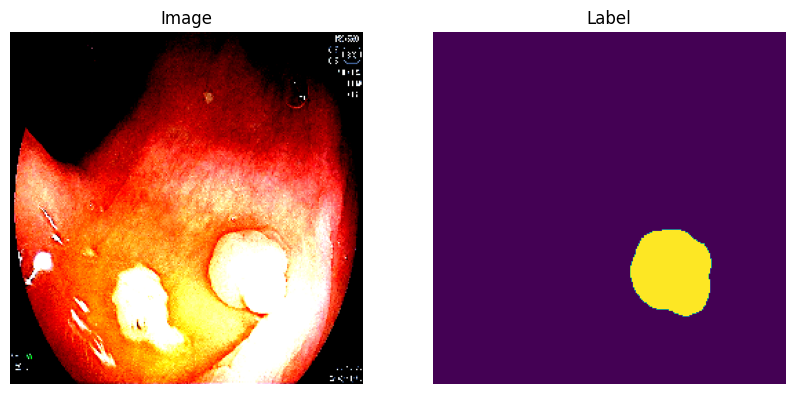

In [11]:
image, label = train_dataset[2]  # Load image and label from dataset  

label_array = label.permute(1, 2, 0).numpy()   
image_array = image.permute(1, 2, 0).numpy()  

fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create subplots  

axs[0].imshow(image_array)  # Display image  
axs[0].set_title('Image')  # Set subplot title for image  
axs[0].axis('off')  # Hide axes  

axs[1].imshow(label_array)  # Display label  
axs[1].set_title('Label')  # Set subplot title for label  
axs[1].axis('off')  # Hide axes  

plt.show() 

In [12]:
learning_rate = 0.0001  # lr
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # optimizer

In [13]:
color_dict= {0: (0, 0, 0),  
             1: (255, 0, 0),
             2: (0, 255, 0)}
def mask_to_rgb(mask, color_dict):  # Define a function
    output = np.zeros((mask.shape[0], mask.shape[1], 3))  

    for k in color_dict.keys():
        output[mask==k] = color_dict[k]

    return np.uint8(output)    

In [14]:
!pip install wandb
import wandb  # Import necessary libraries
!wandb login '2239cd9d93e77db267b258d6da608bf2a7e5a516'

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [15]:
wandb.init(
    project = 'Unet_polyp-Segmentation'  
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: duc-dq225483 (quaqducc). Use `wandb login --relogin` to force relogin


Epoch [1/200], Loss: 0.5397245746


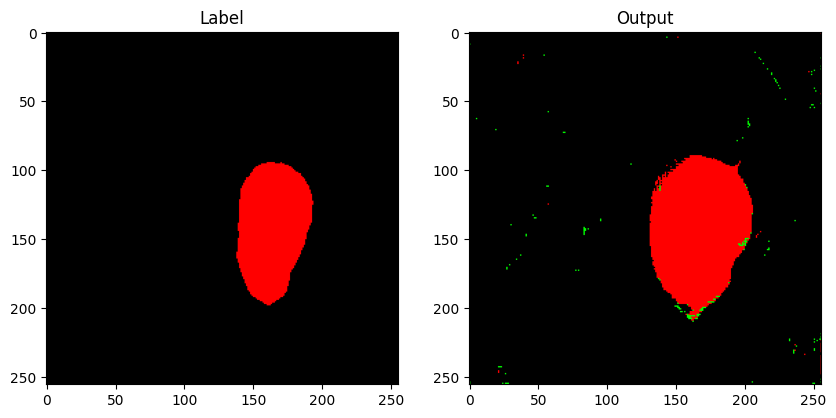

Epoch [2/200], Loss: 0.2730850807


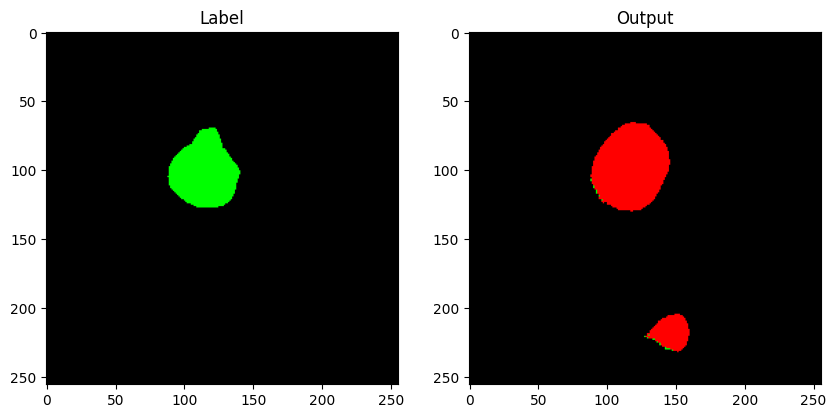

Epoch [3/200], Loss: 0.1686142316


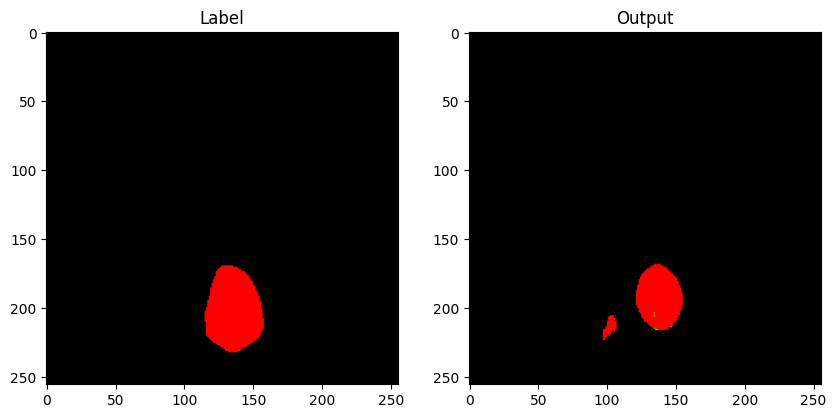

Epoch [4/200], Loss: 0.1320040570


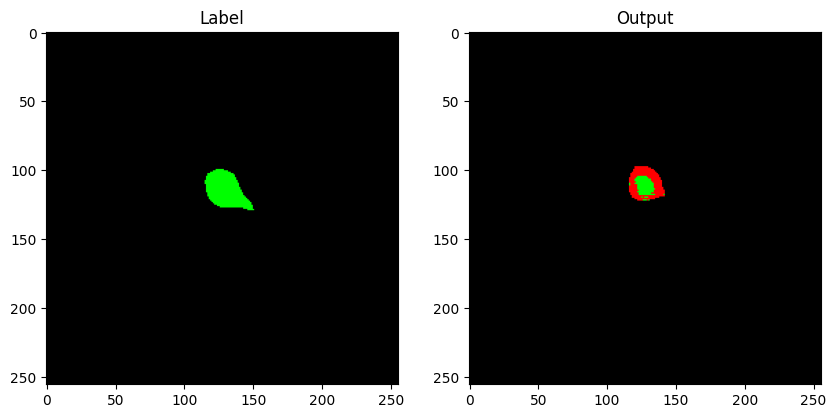

Epoch [5/200], Loss: 0.1053479245


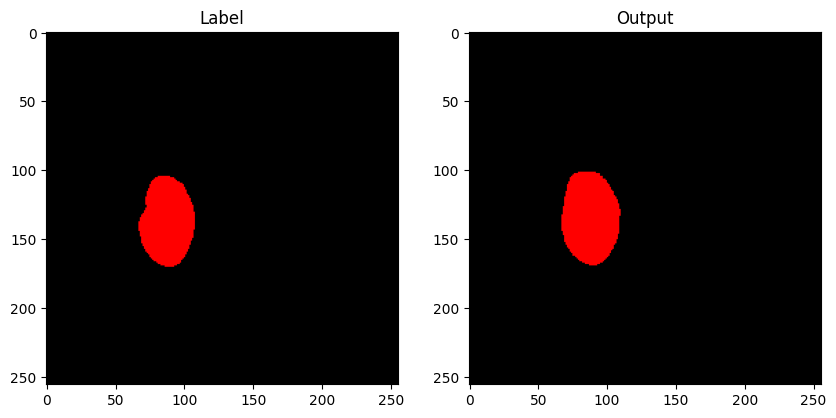

Epoch [6/200], Loss: 0.0875076379


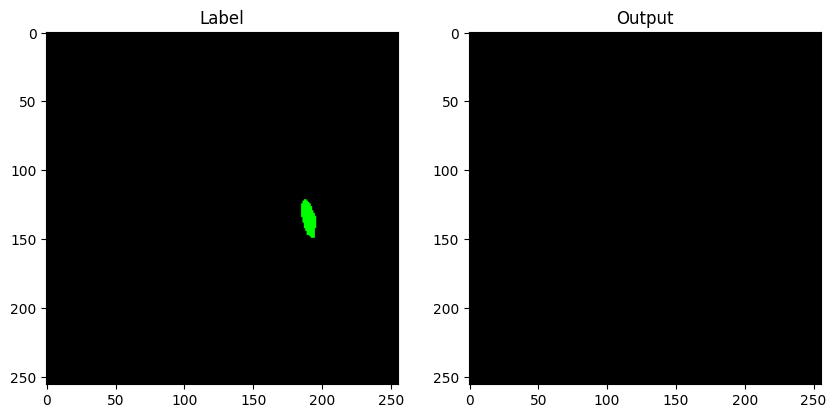

Epoch [7/200], Loss: 0.0789626335


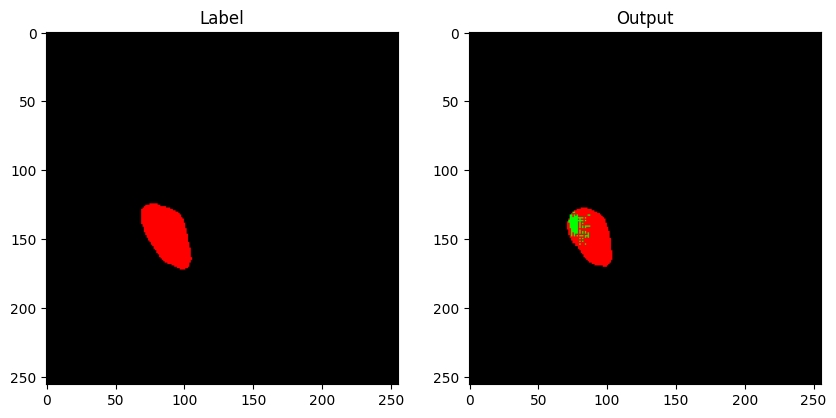

Epoch [8/200], Loss: 0.0711543382


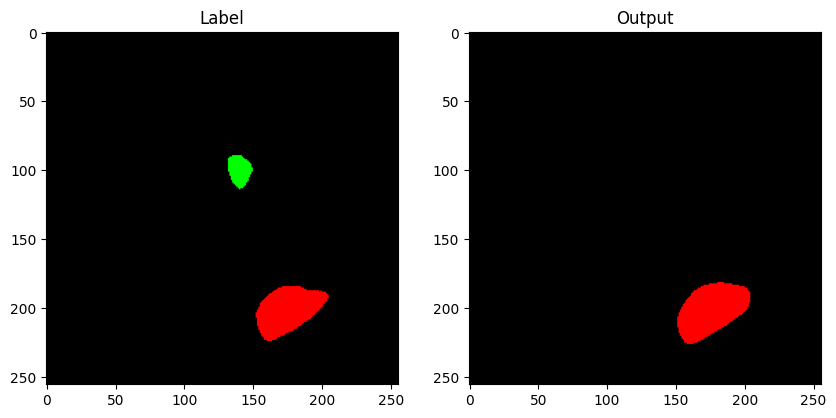

Epoch [9/200], Loss: 0.0685328431


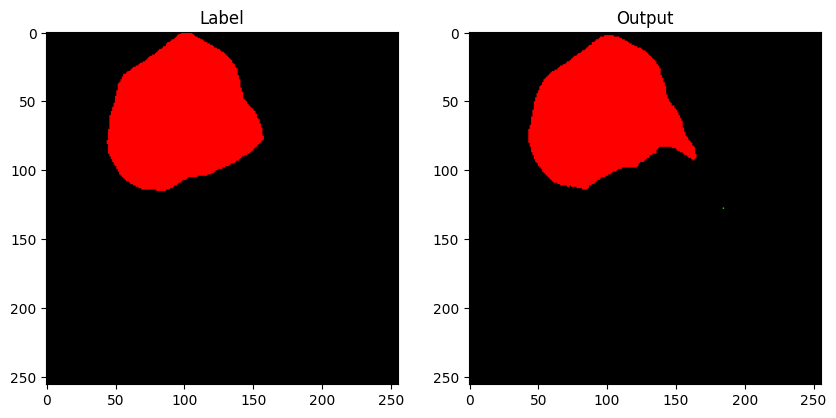

Epoch [10/200], Loss: 0.0640481710


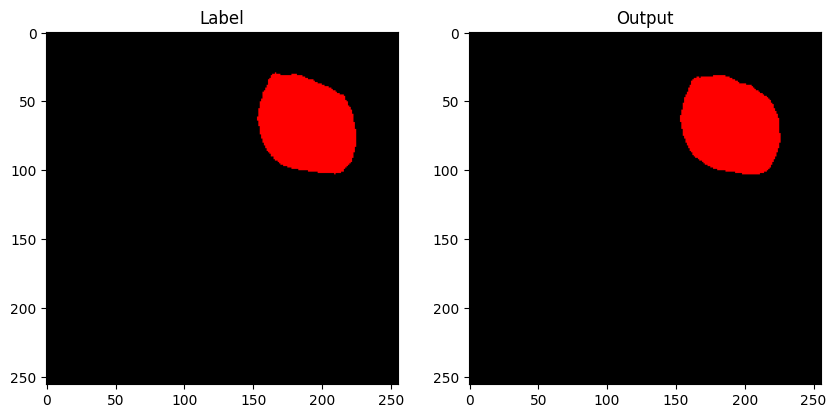

Epoch [11/200], Loss: 0.0712328573


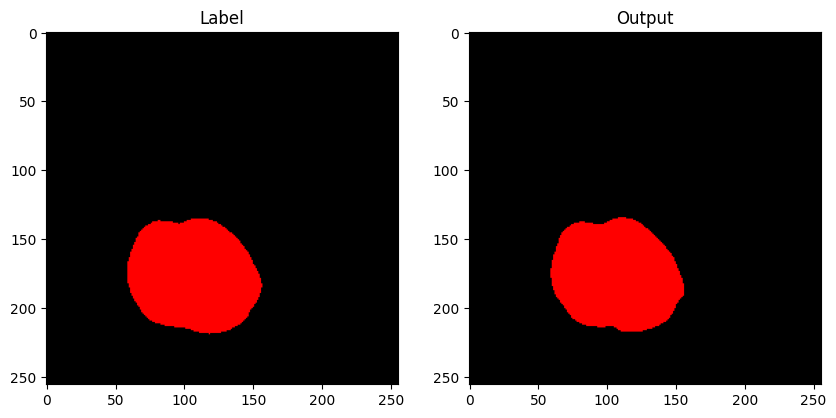

Epoch [12/200], Loss: 0.0651333024


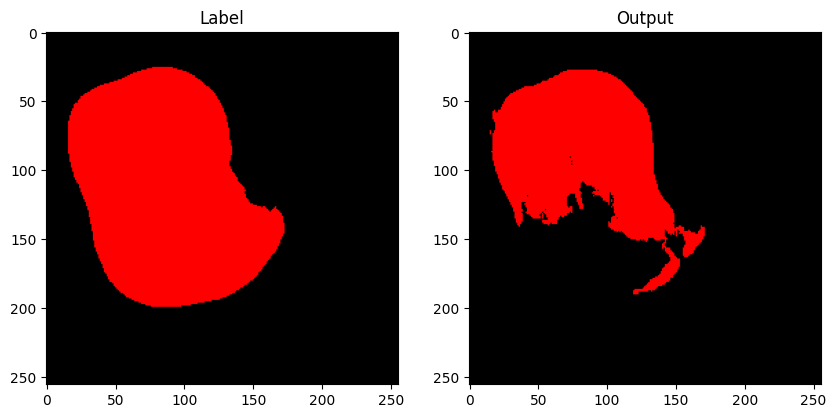

Epoch [13/200], Loss: 0.0555242082


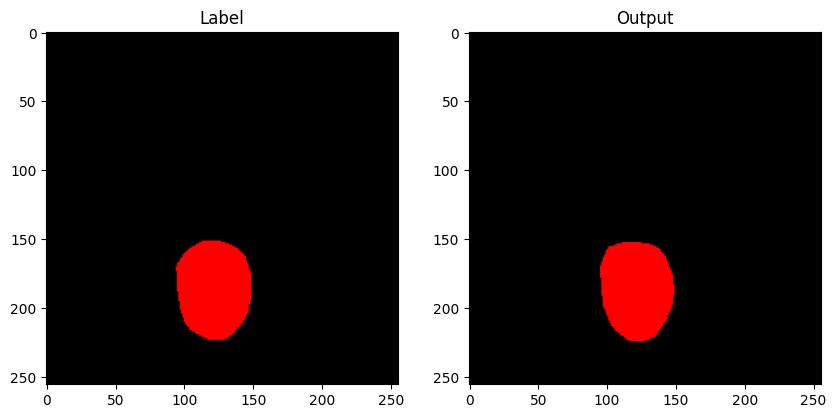

Epoch [14/200], Loss: 0.0586942449


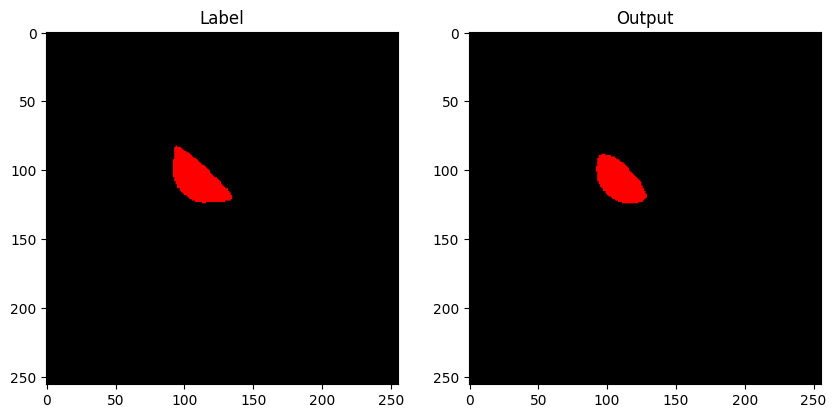

Epoch [15/200], Loss: 0.0523559573


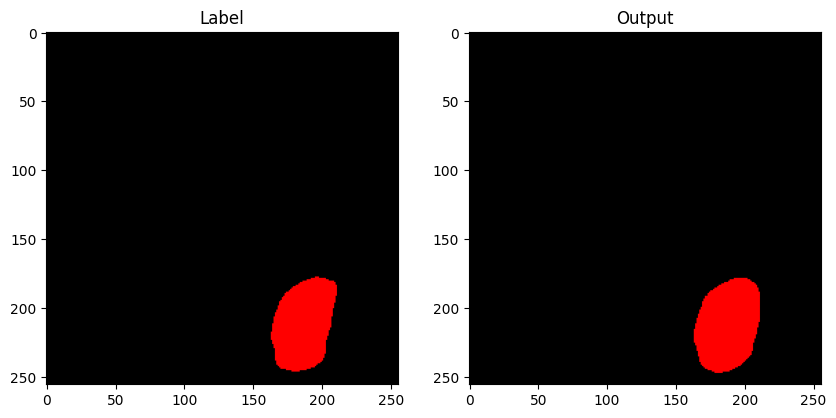

Epoch [16/200], Loss: 0.0581710472


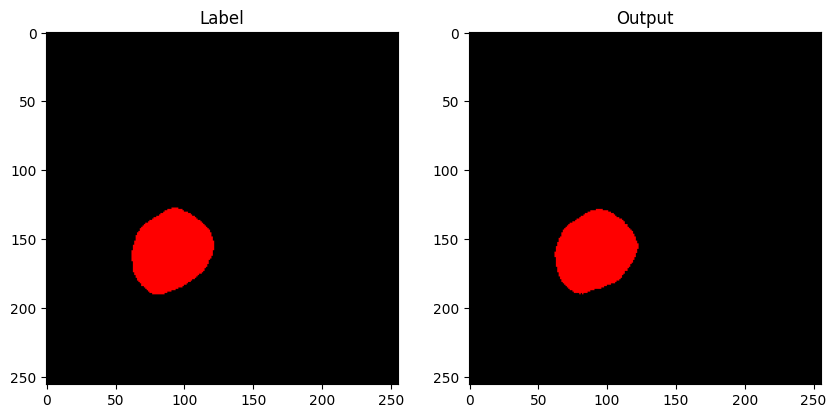

Epoch [17/200], Loss: 0.0577277202


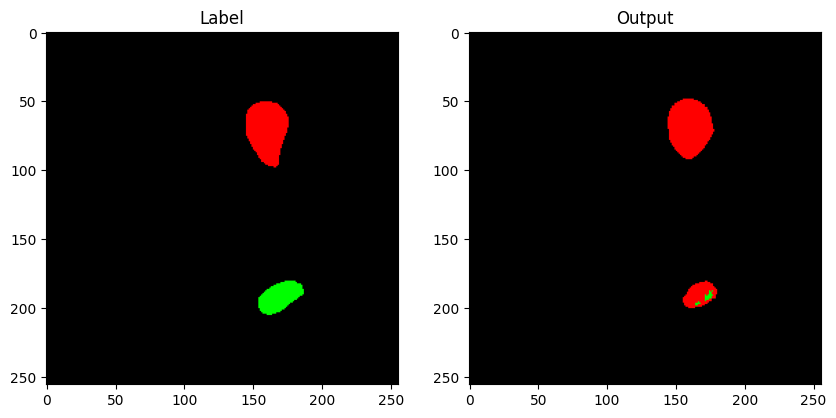

Epoch [18/200], Loss: 0.0582666143


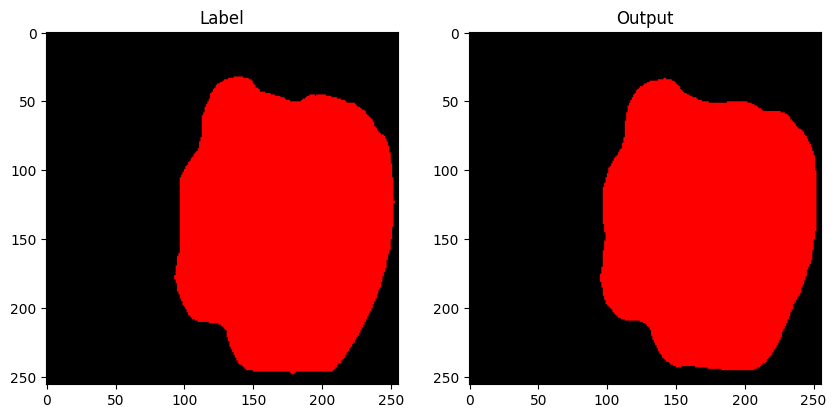

Epoch [19/200], Loss: 0.0606687704


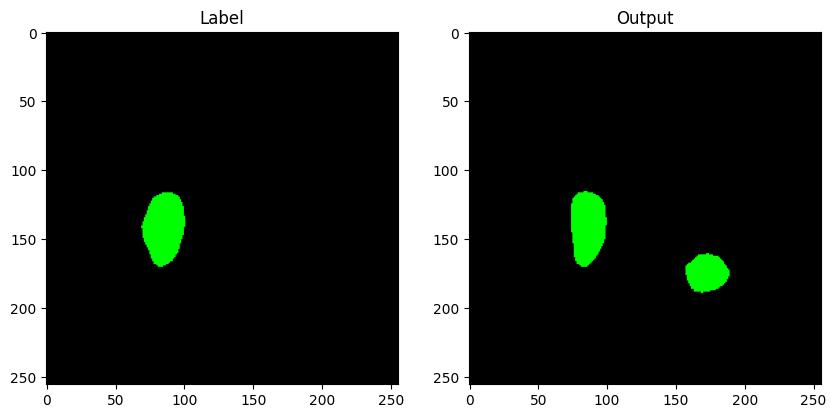

Epoch [20/200], Loss: 0.0507767928


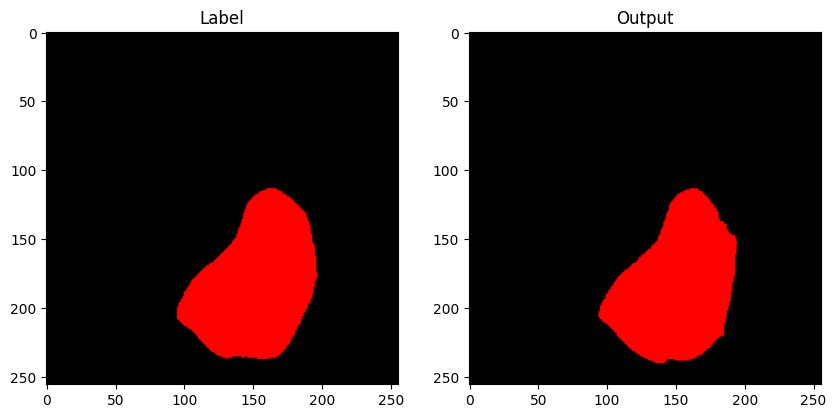

Epoch [21/200], Loss: 0.0599207659


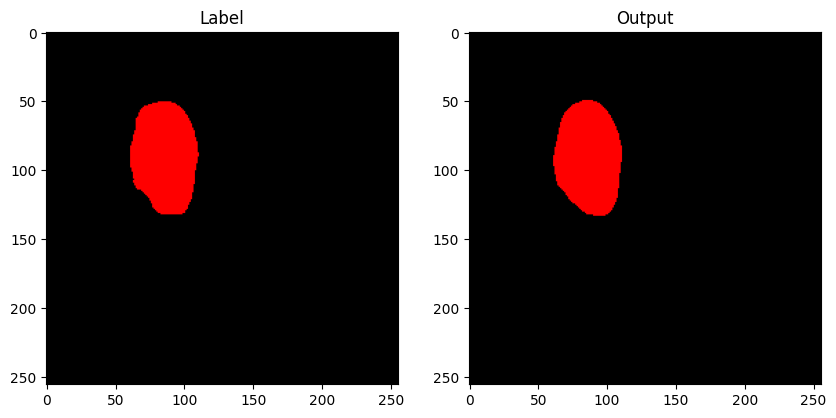

Epoch [22/200], Loss: 0.0510303001


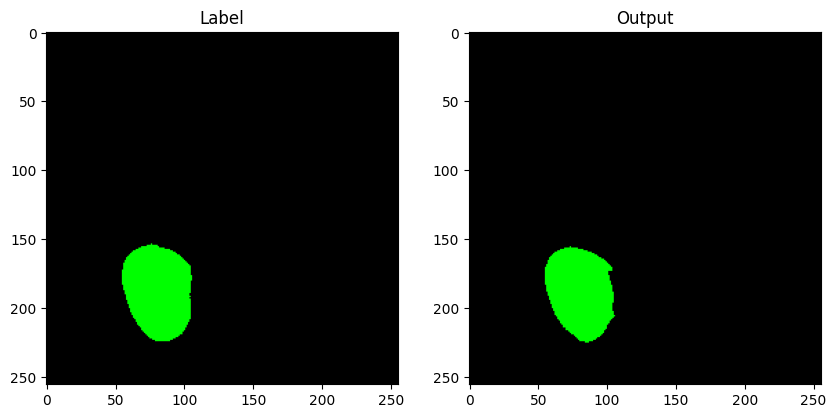

Epoch [23/200], Loss: 0.0603787971


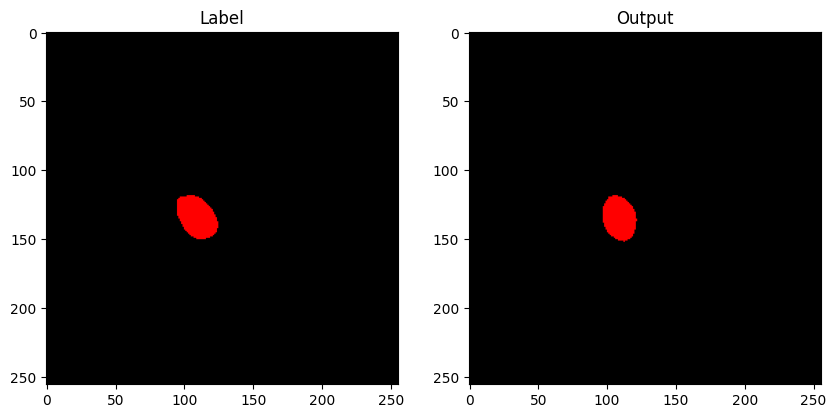

Epoch [24/200], Loss: 0.0511188390


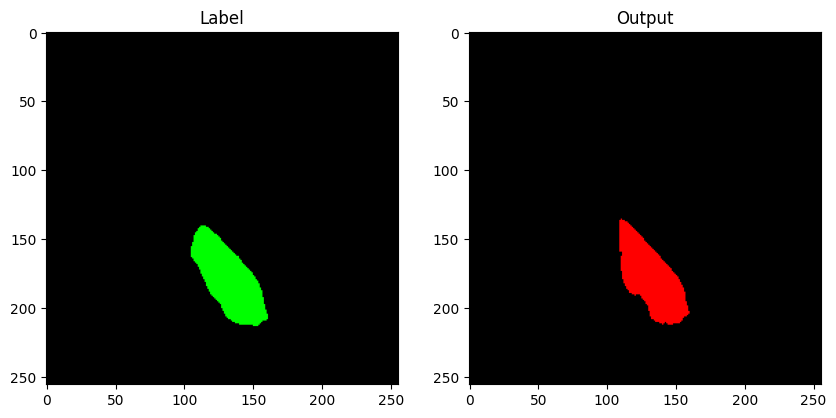

Epoch [25/200], Loss: 0.0520344997


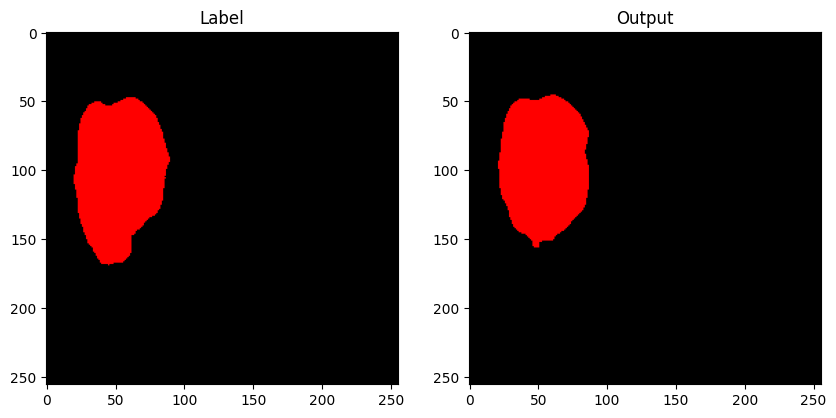

Epoch [26/200], Loss: 0.0523418870


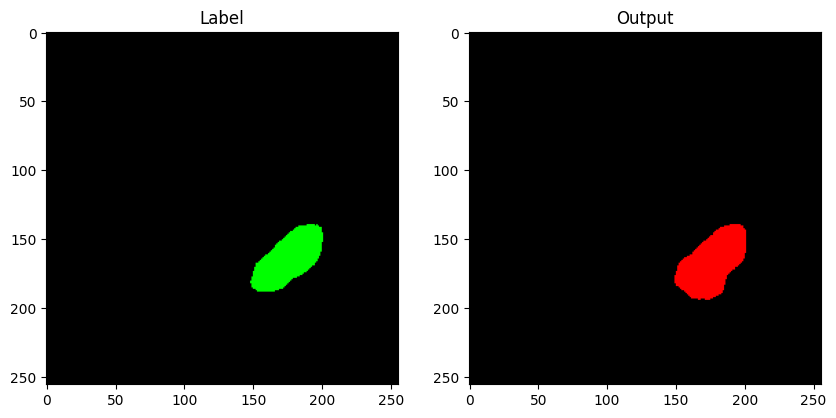

Epoch [27/200], Loss: 0.0608738572


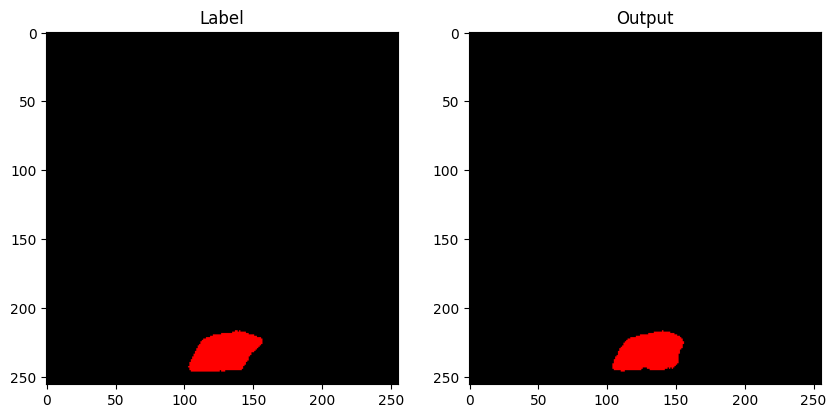

Epoch [28/200], Loss: 0.0534351419


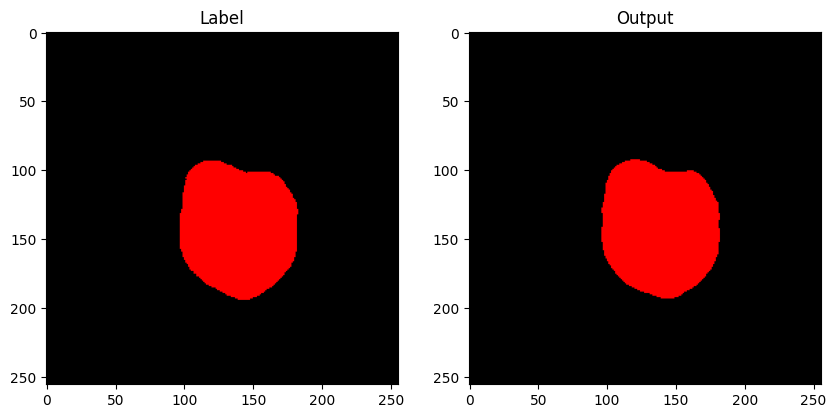

Epoch [29/200], Loss: 0.0619471542


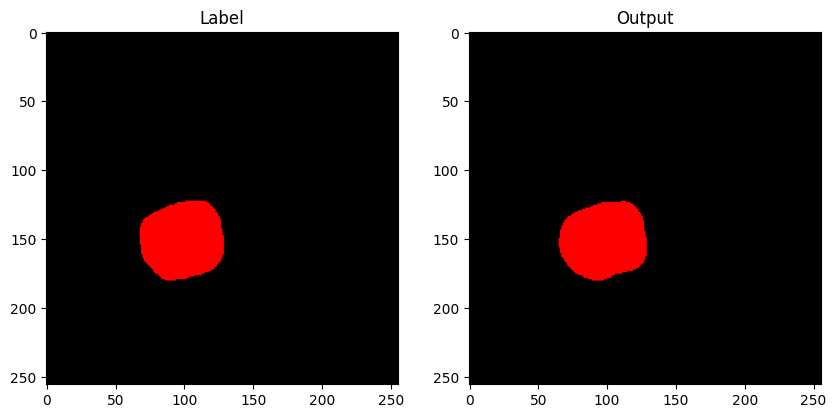

Epoch [30/200], Loss: 0.0538175231


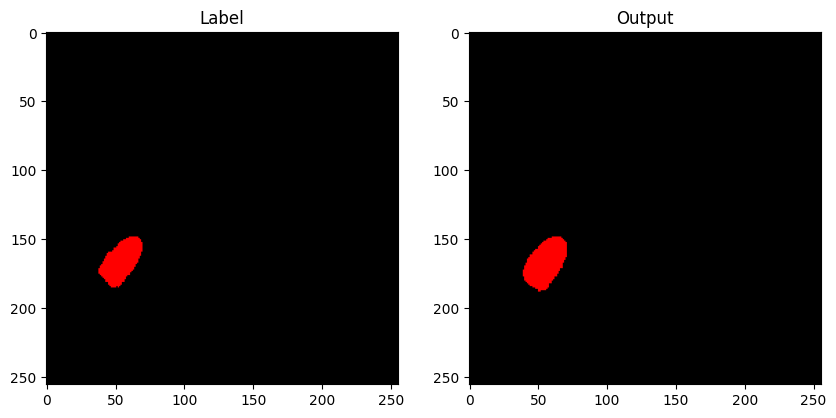

Epoch [31/200], Loss: 0.0545423290


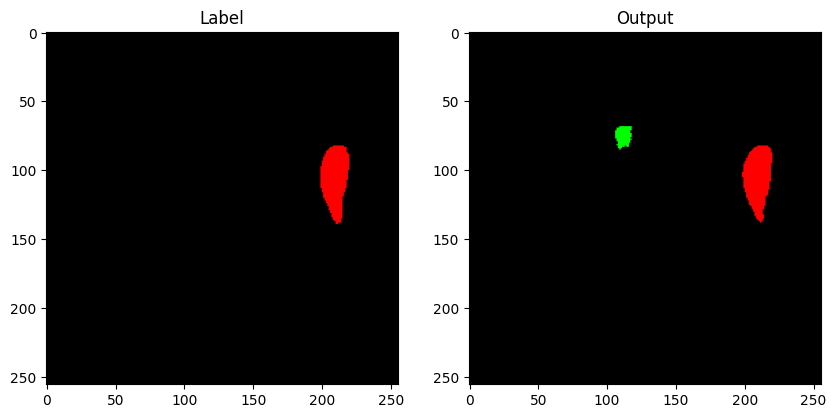

Epoch [32/200], Loss: 0.0556098127


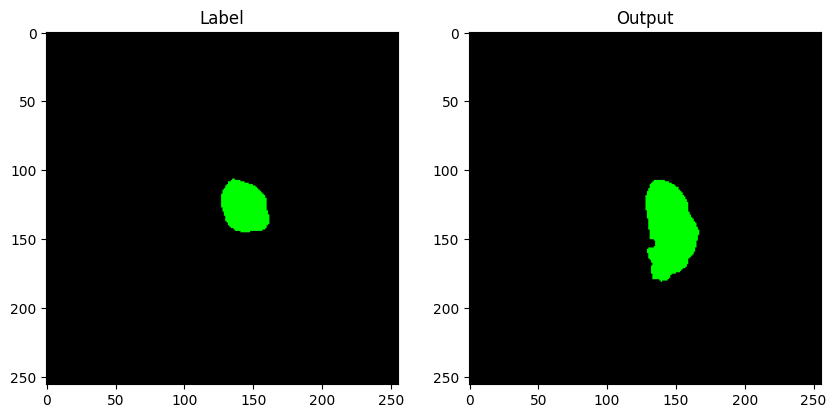

Epoch [33/200], Loss: 0.0561449890


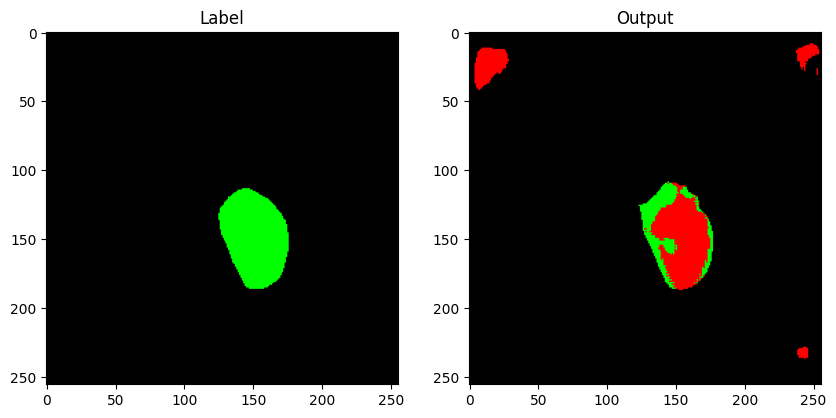

Epoch [34/200], Loss: 0.0488315435


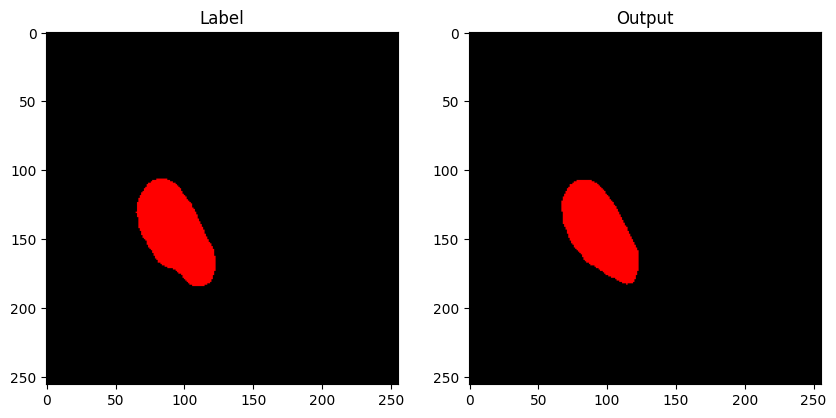

Epoch [35/200], Loss: 0.0577758706


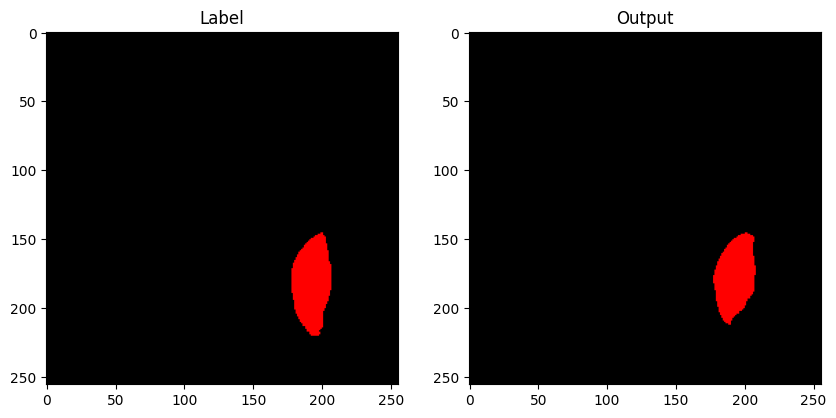

Epoch [36/200], Loss: 0.0541231949


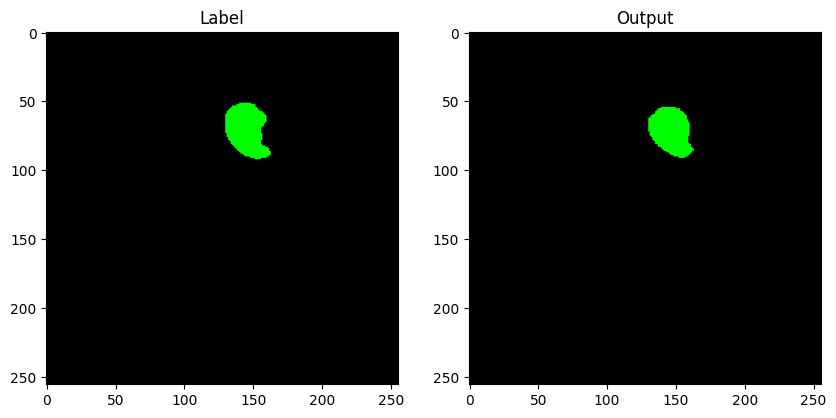

Epoch [37/200], Loss: 0.0508798602


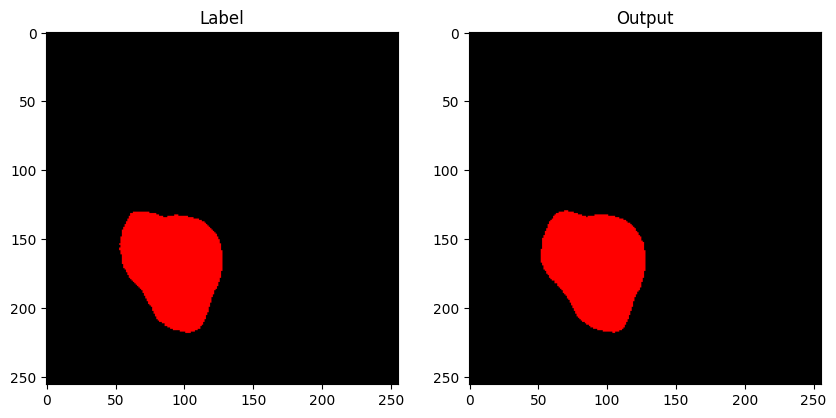

Epoch [38/200], Loss: 0.0572466329


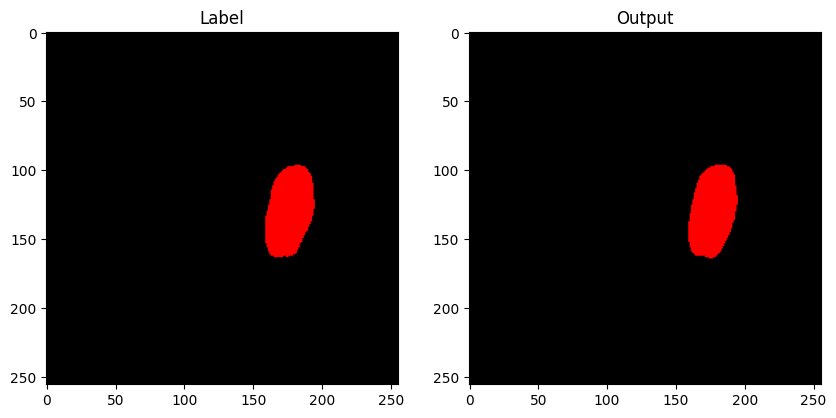

Epoch [39/200], Loss: 0.0625707772


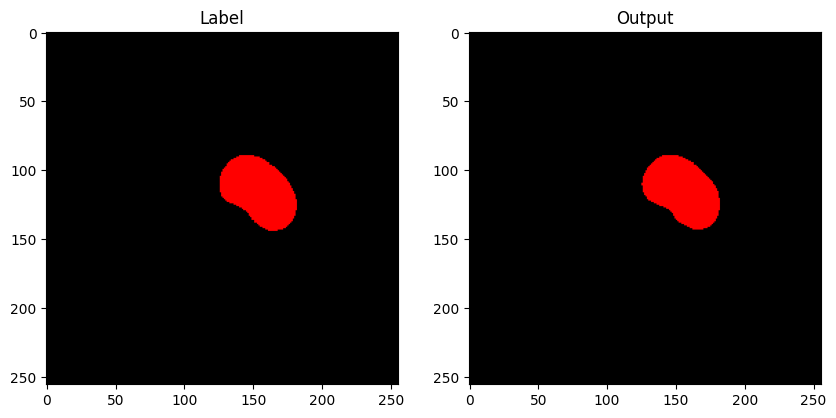

Epoch [40/200], Loss: 0.0543470057


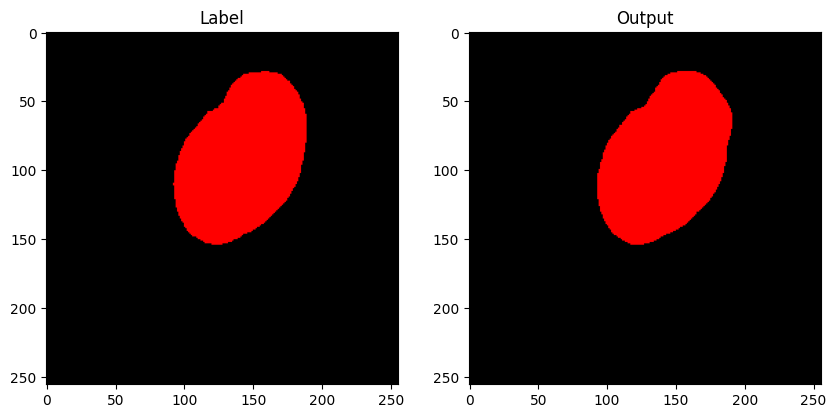

Epoch [41/200], Loss: 0.0710334128


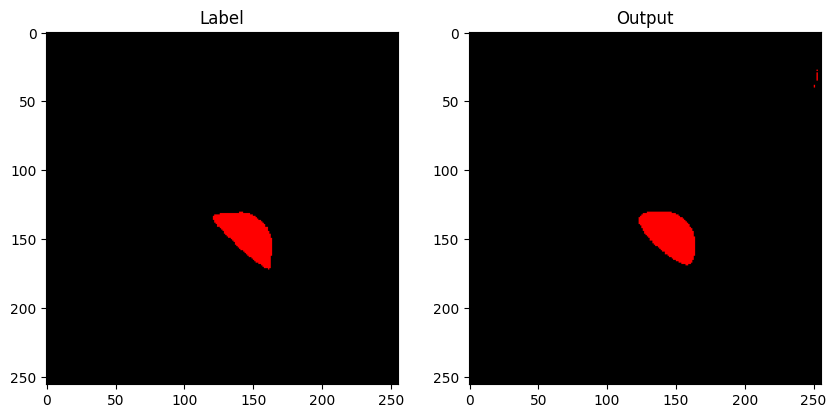

Epoch [42/200], Loss: 0.0616258538


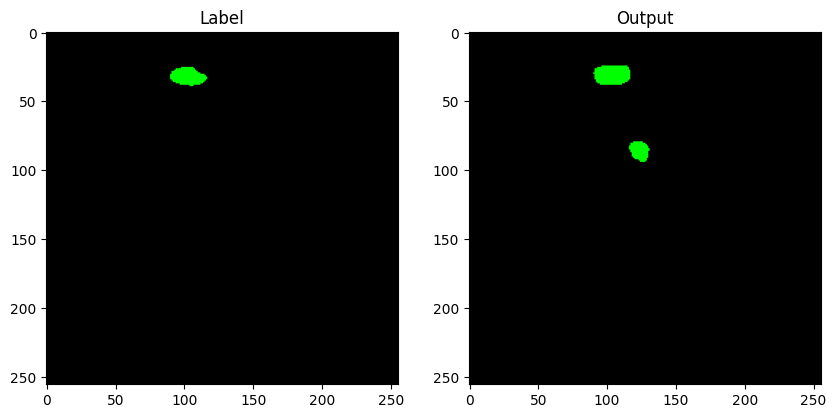

Epoch [43/200], Loss: 0.0570640510


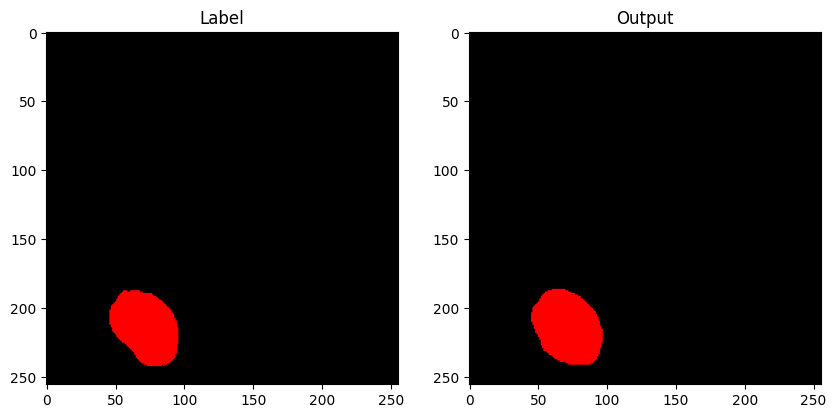

Epoch [44/200], Loss: 0.0530805841


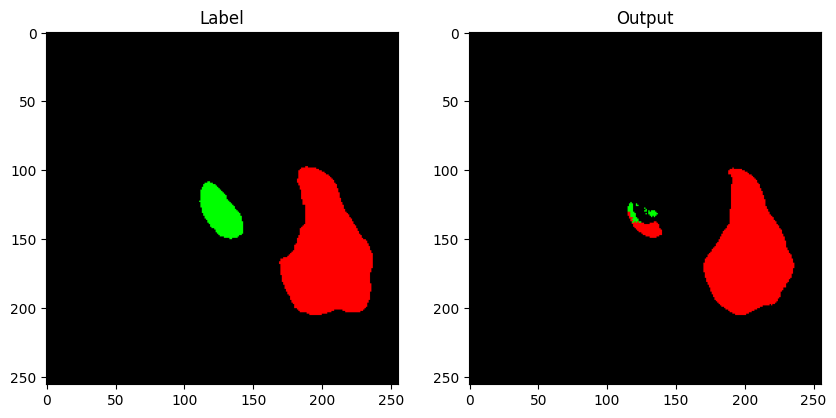

Epoch [45/200], Loss: 0.0567867687


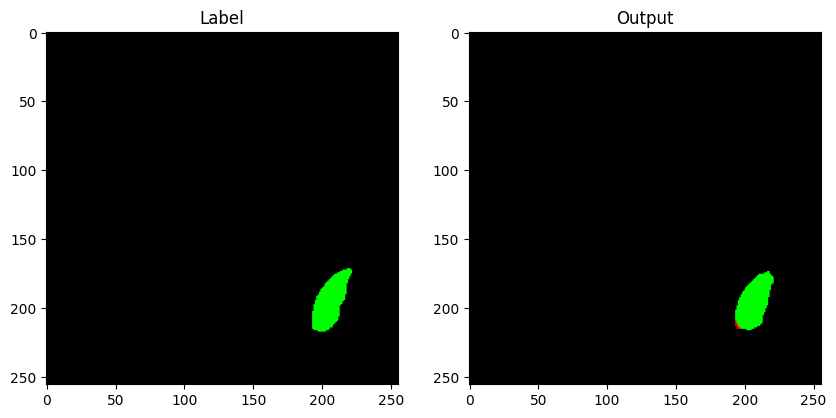

Epoch [46/200], Loss: 0.0626445163


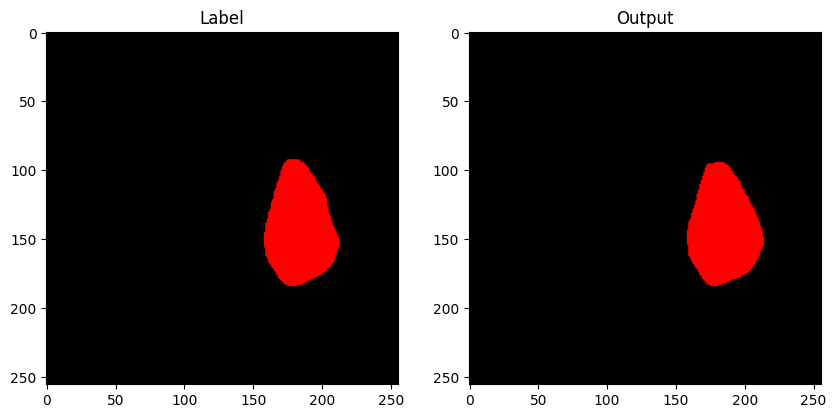

Epoch [47/200], Loss: 0.0616522011


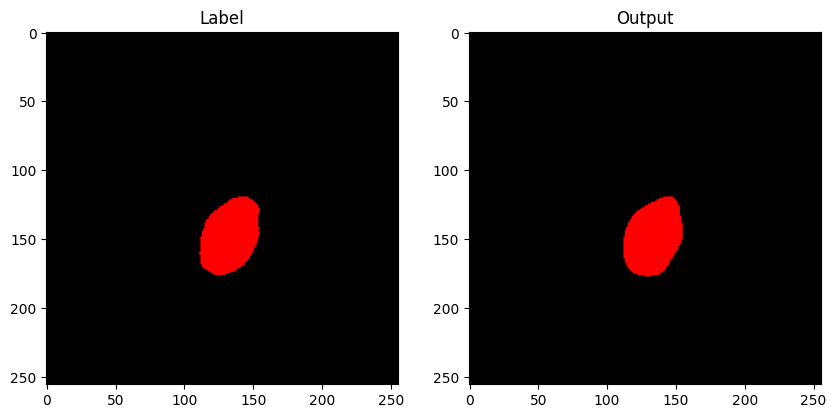

Epoch [48/200], Loss: 0.0556014603


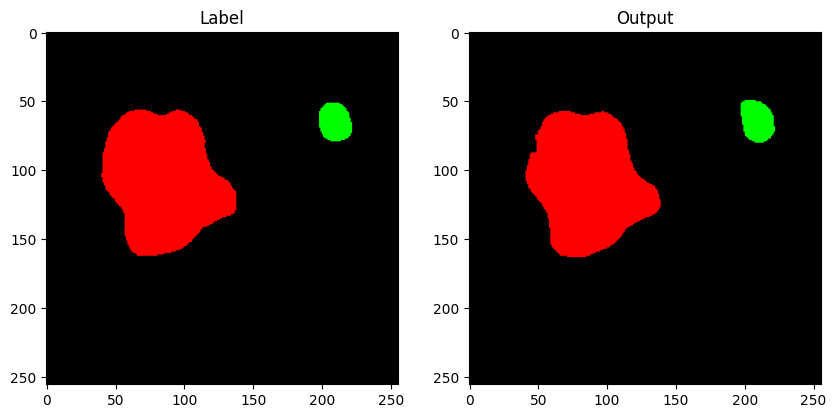

Epoch [49/200], Loss: 0.0551286593


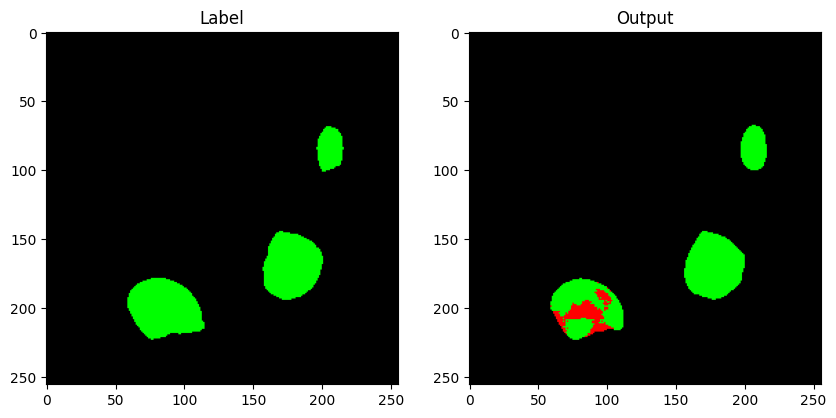

Epoch [50/200], Loss: 0.0576108625


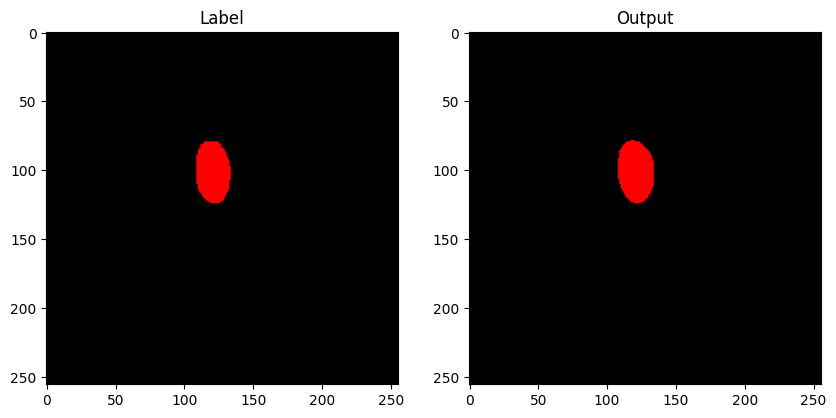

Epoch [51/200], Loss: 0.0642012404


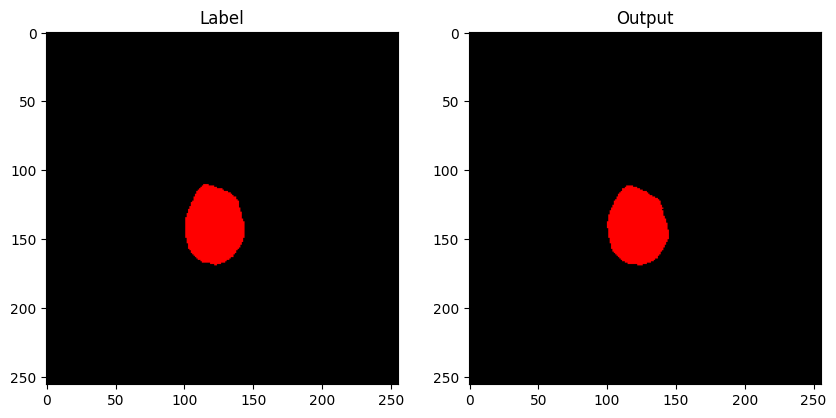

Epoch [52/200], Loss: 0.0667974029


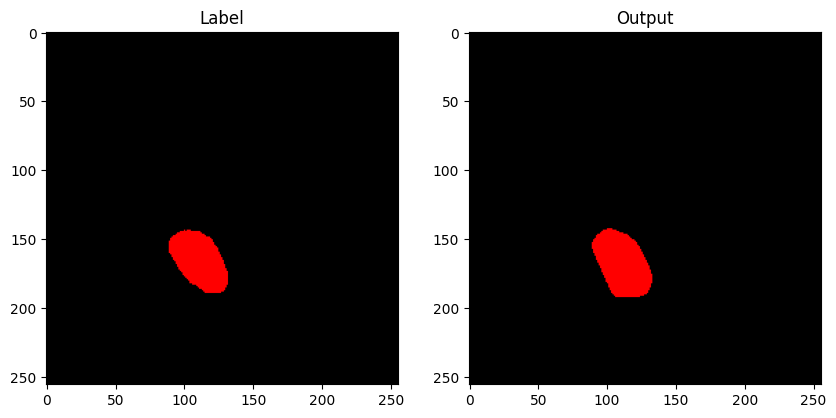

Epoch [53/200], Loss: 0.0617853773


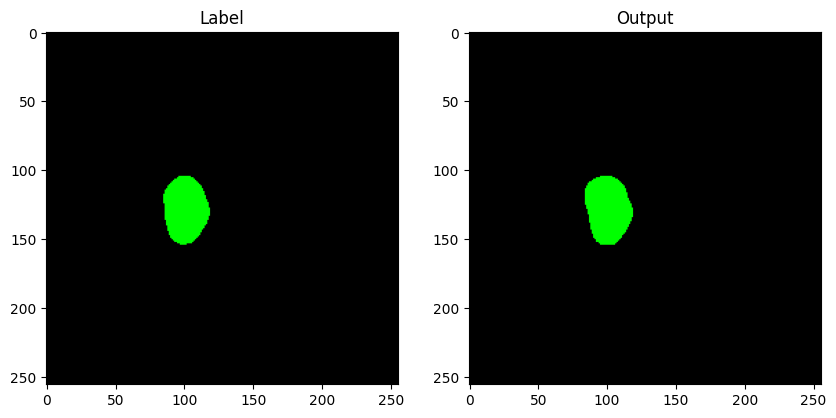

Epoch [54/200], Loss: 0.0596301181


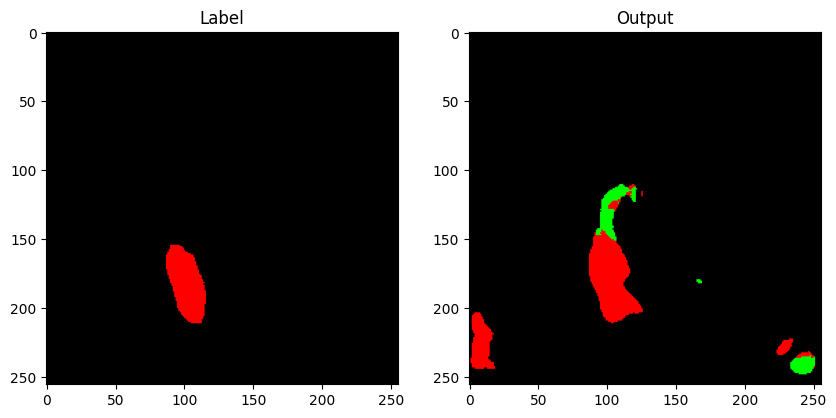

Epoch [55/200], Loss: 0.0667988582


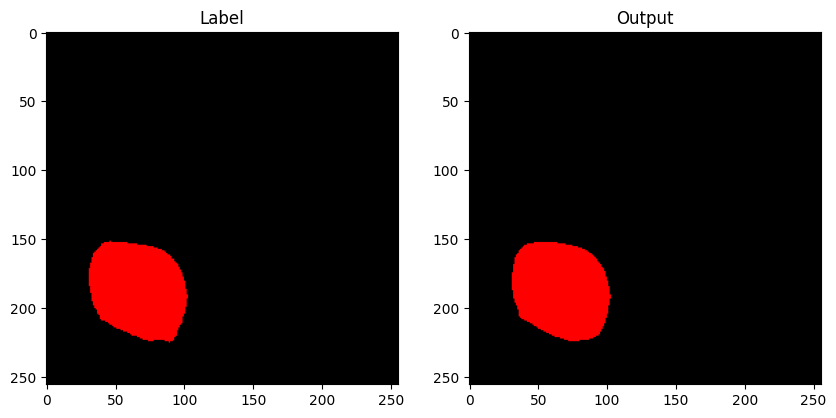

Epoch [56/200], Loss: 0.0615522234


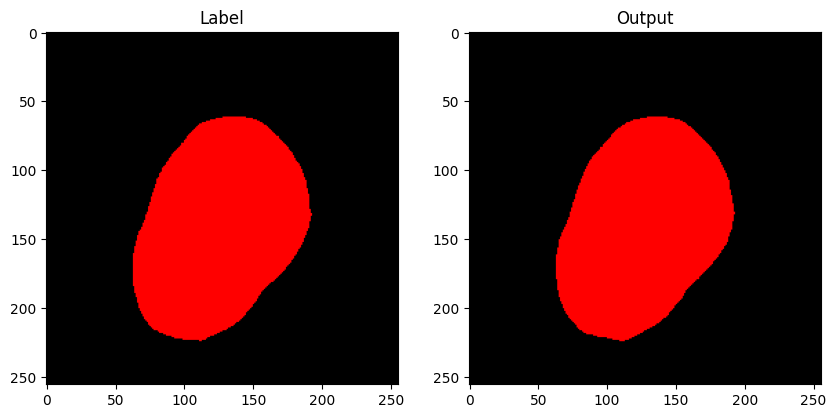

Epoch [57/200], Loss: 0.0612513753


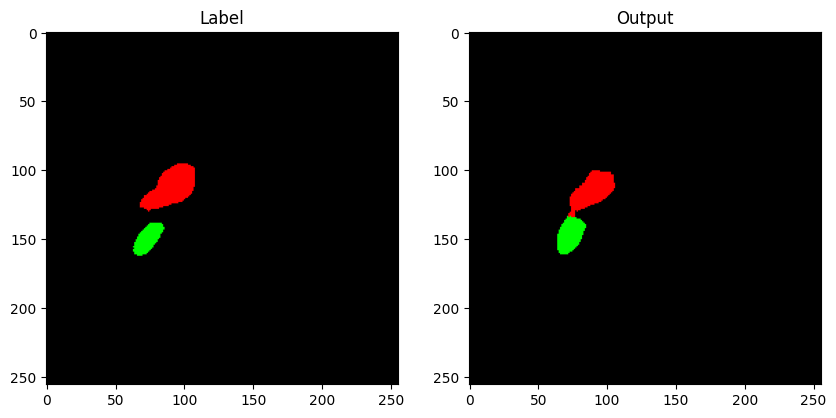

Epoch [58/200], Loss: 0.0661780780


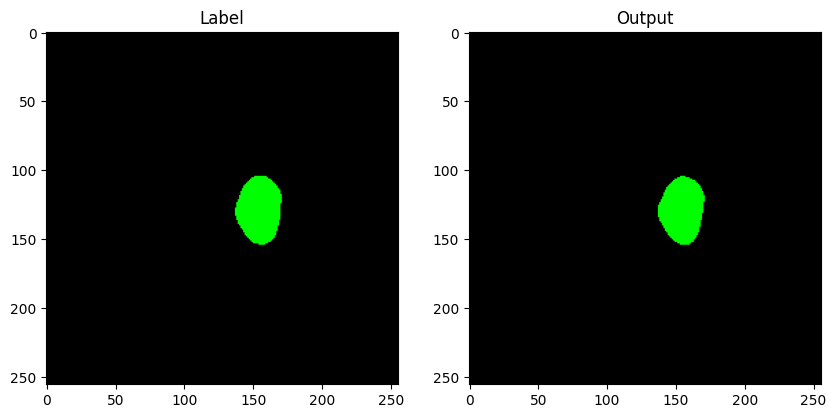

Epoch [59/200], Loss: 0.0686117628


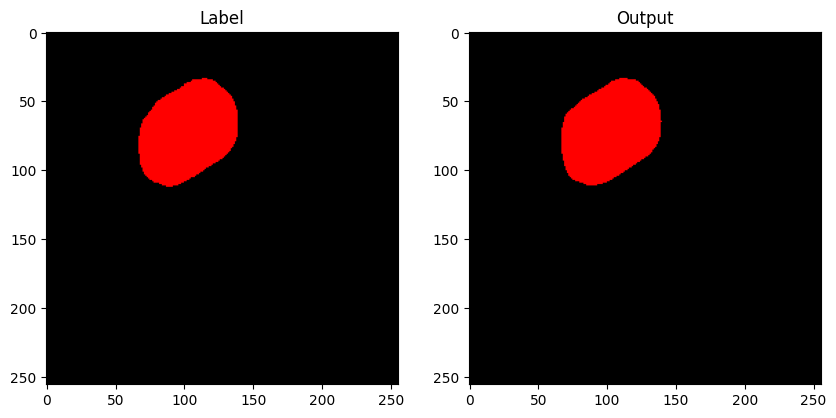

Epoch [60/200], Loss: 0.0643078723


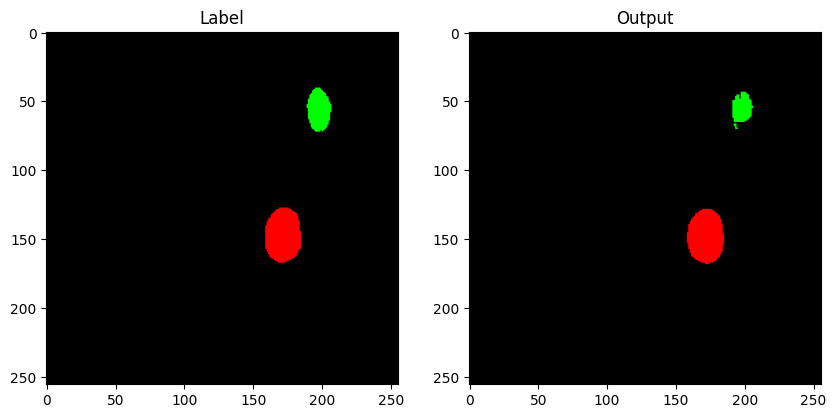

Epoch [61/200], Loss: 0.0619780582


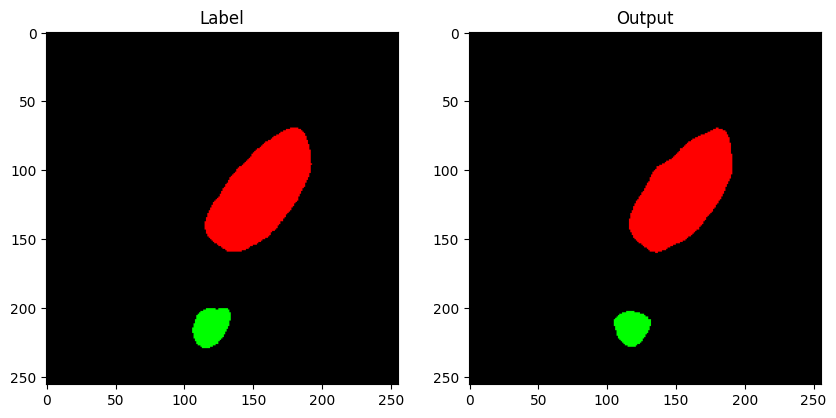

Epoch [62/200], Loss: 0.0725481345


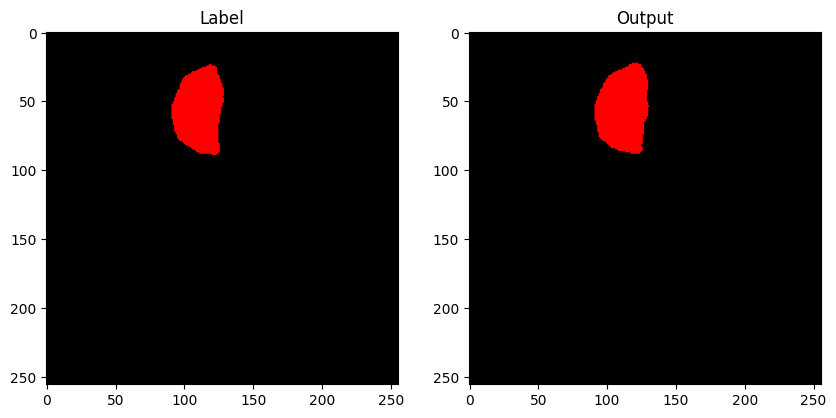

Epoch [63/200], Loss: 0.0836665965


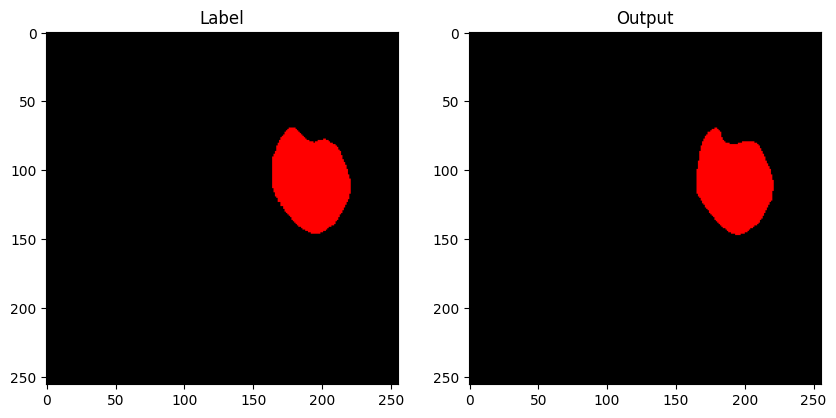

Epoch [64/200], Loss: 0.0605439659


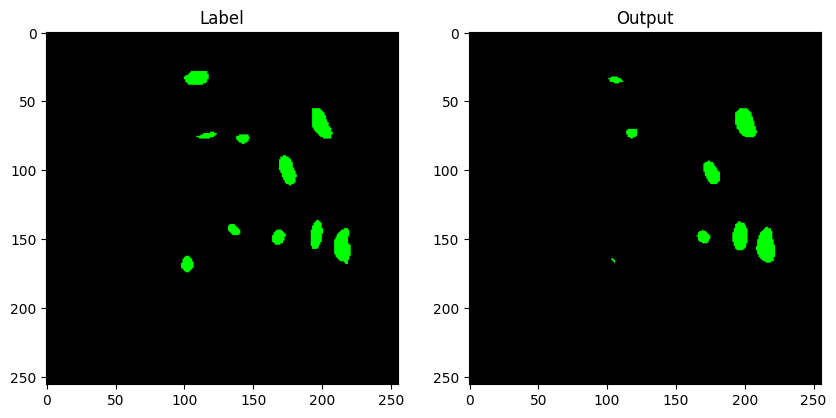

Epoch [65/200], Loss: 0.0689516641


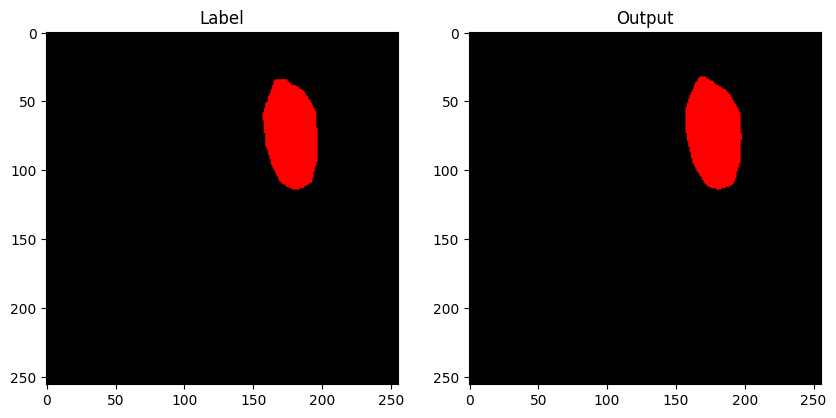

Epoch [66/200], Loss: 0.0634229125


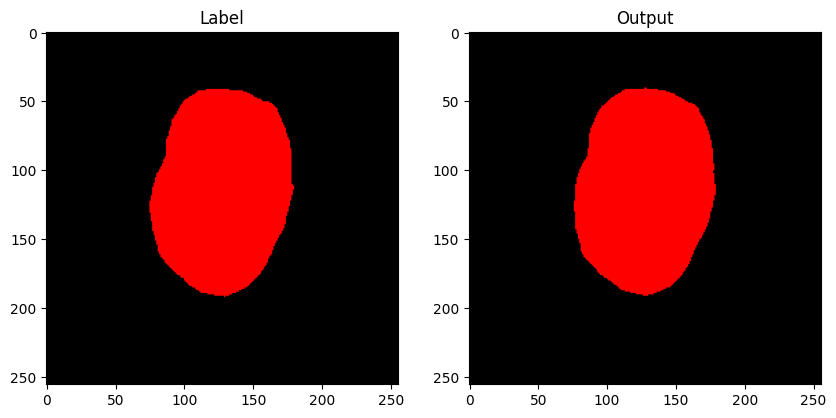

Epoch [67/200], Loss: 0.0496228650


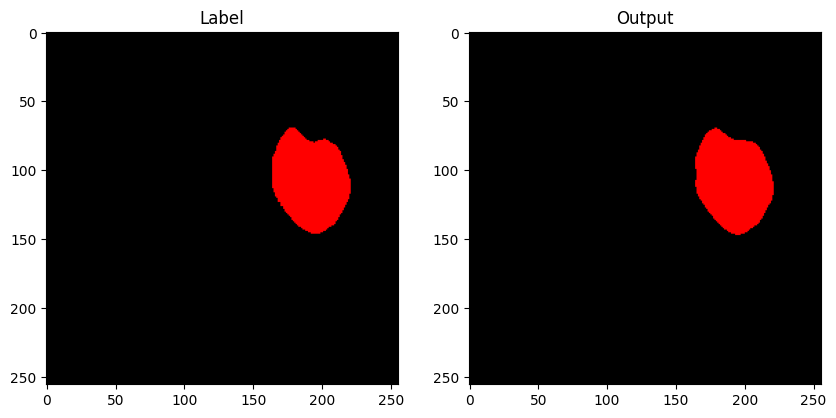

Epoch [68/200], Loss: 0.0535450983


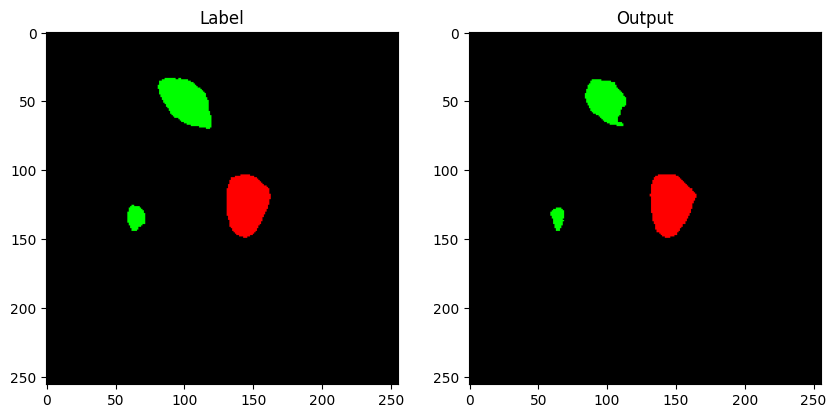

Epoch [69/200], Loss: 0.0596850652


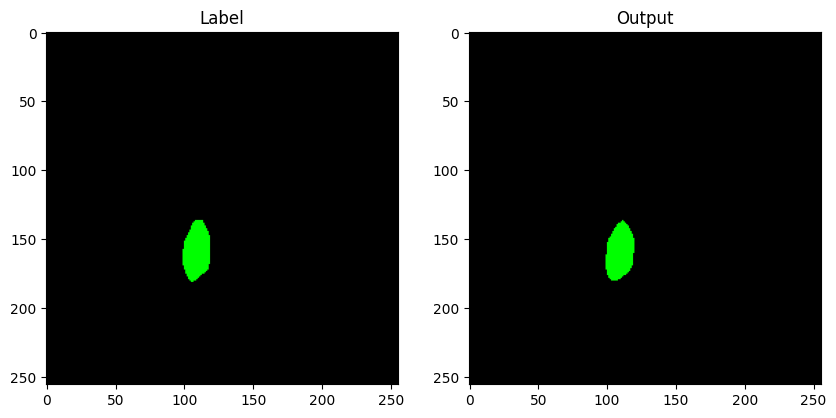

Epoch [70/200], Loss: 0.0494993977


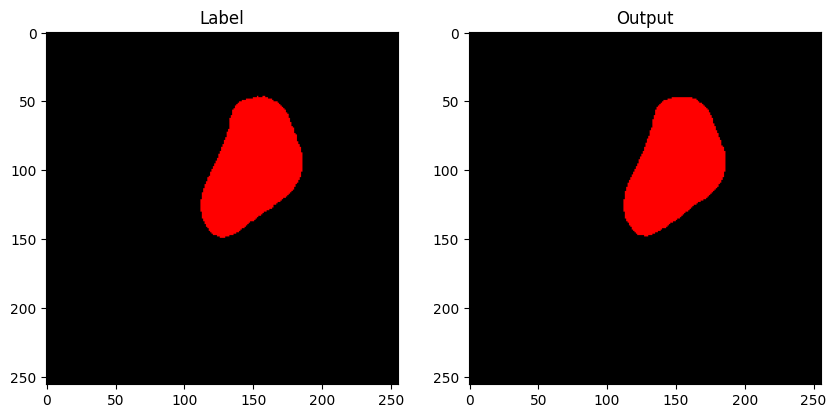

Epoch [71/200], Loss: 0.0515258957


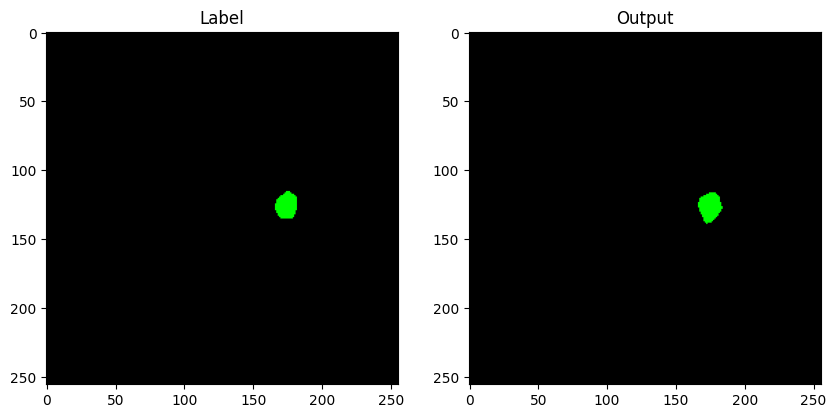

Epoch [72/200], Loss: 0.0528118949


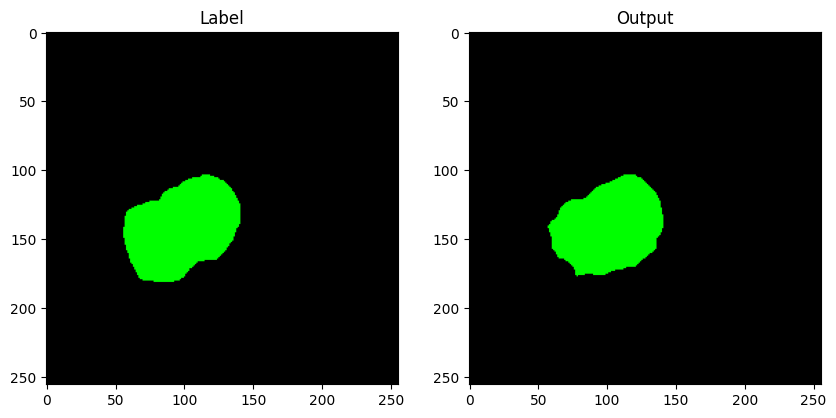

Epoch [73/200], Loss: 0.0636560484


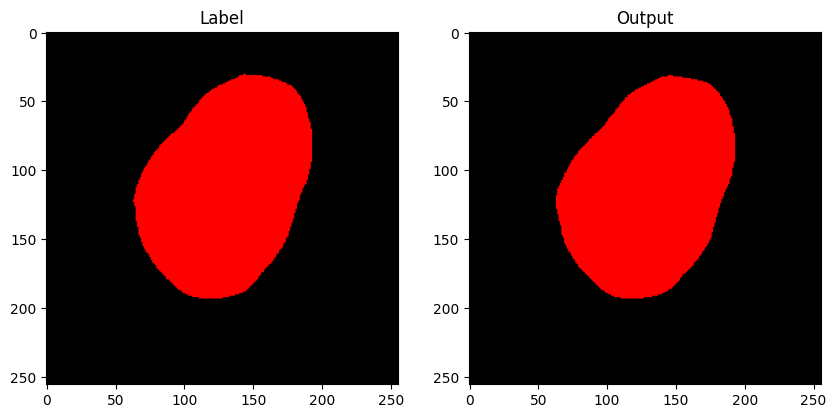

Epoch [74/200], Loss: 0.0541364176


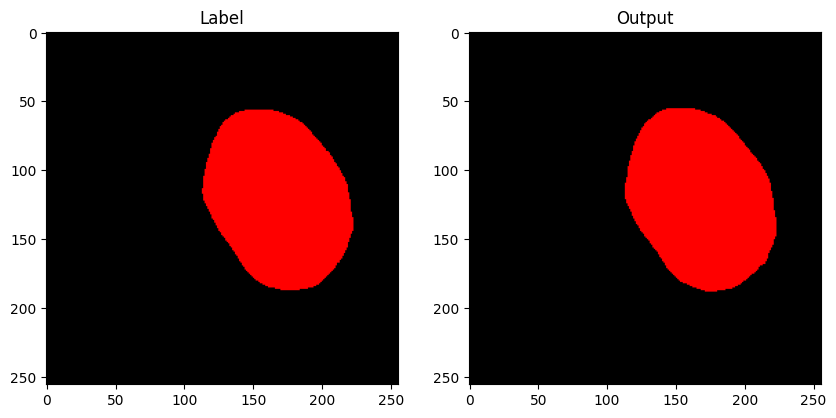

Epoch [75/200], Loss: 0.0673988972


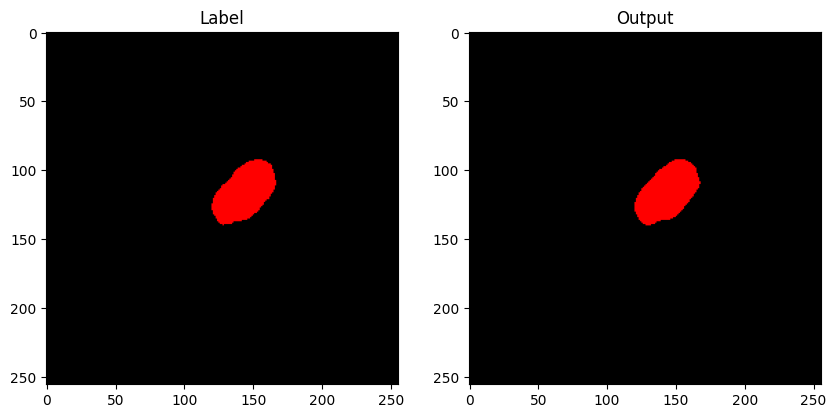

Epoch [76/200], Loss: 0.0617534533


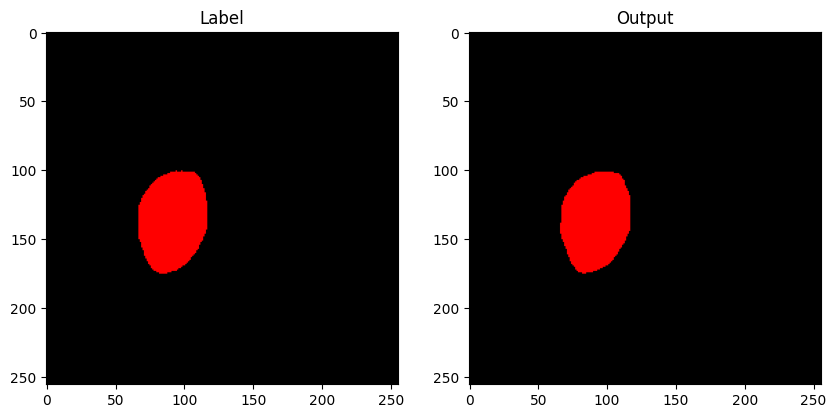

Epoch [77/200], Loss: 0.0554395402


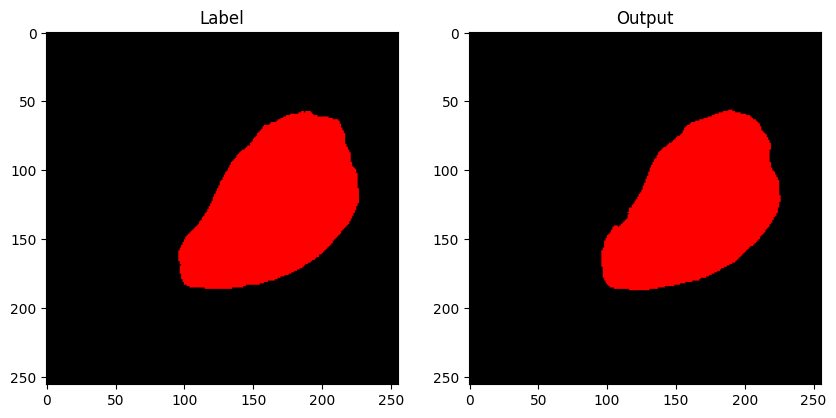

Epoch [78/200], Loss: 0.0570229151


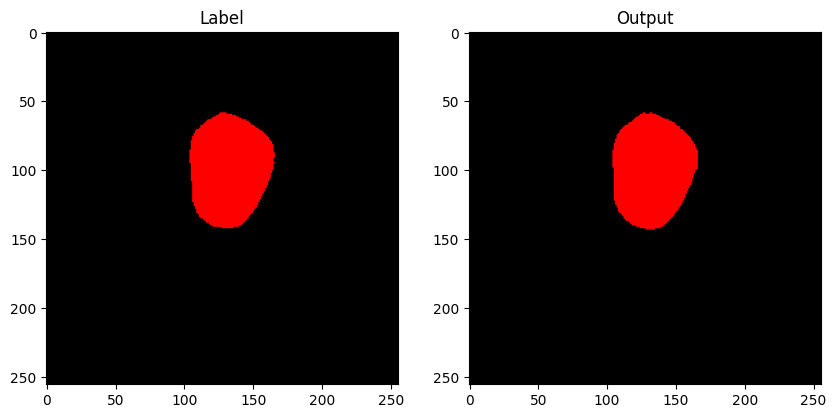

Epoch [79/200], Loss: 0.0624470307


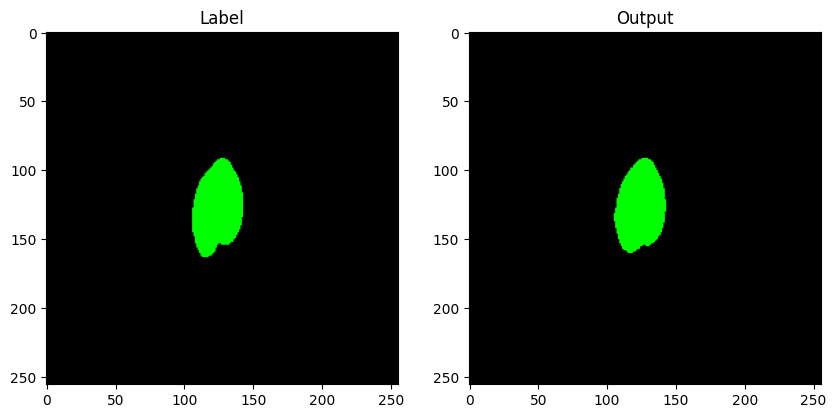

Epoch [80/200], Loss: 0.0661444072


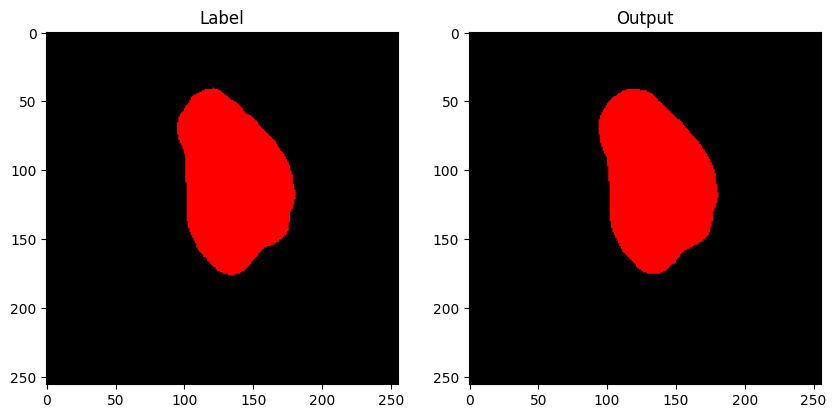

Epoch [81/200], Loss: 0.0614872828


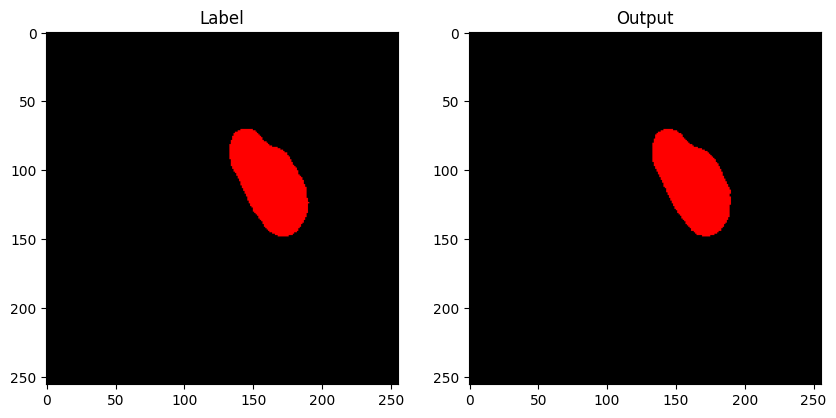

Epoch [82/200], Loss: 0.0639059291


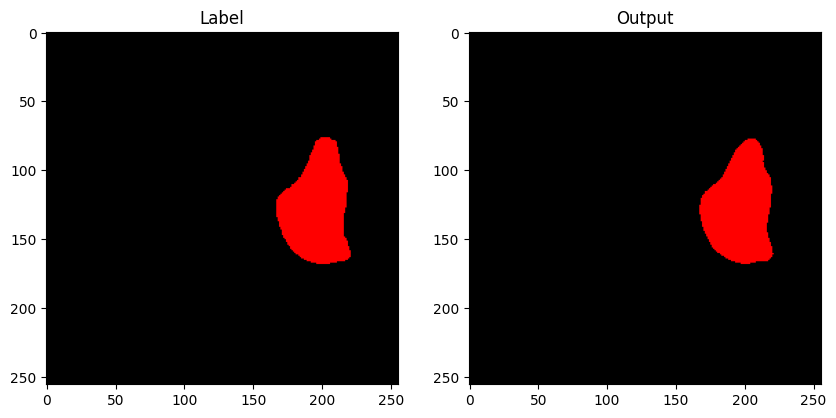

Epoch [83/200], Loss: 0.0596322210


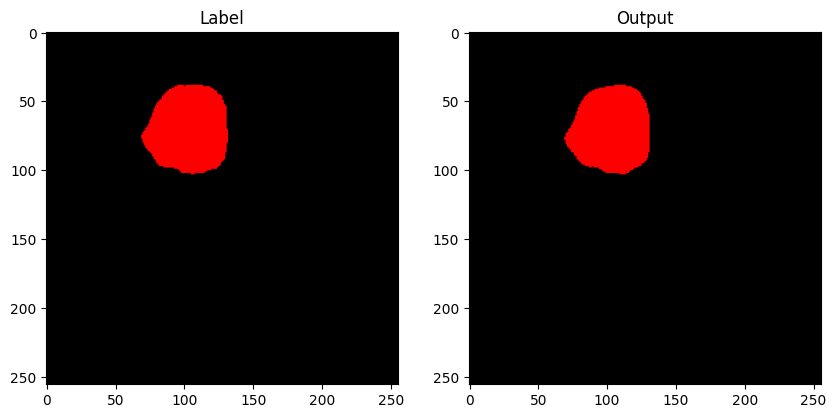

Epoch [84/200], Loss: 0.0636022741


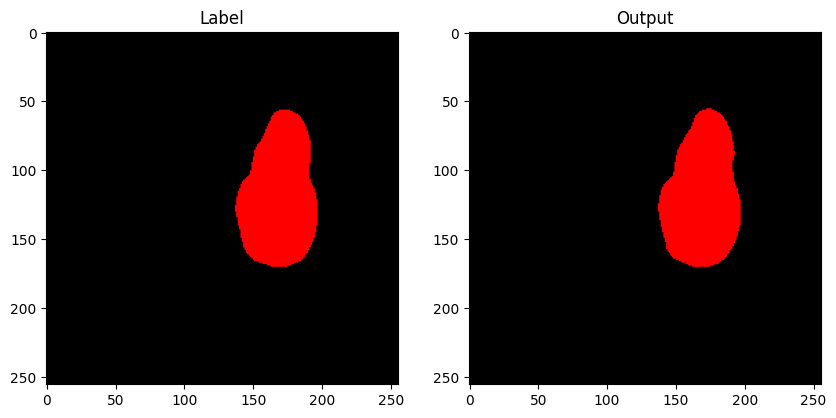

Epoch [85/200], Loss: 0.0632394726


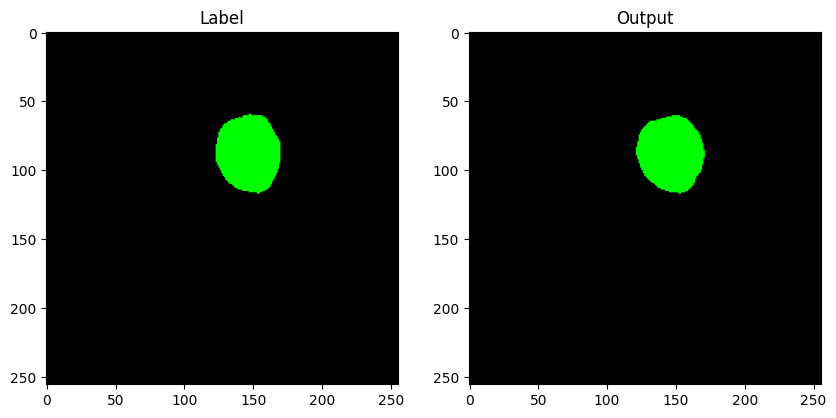

Epoch [86/200], Loss: 0.0591421339


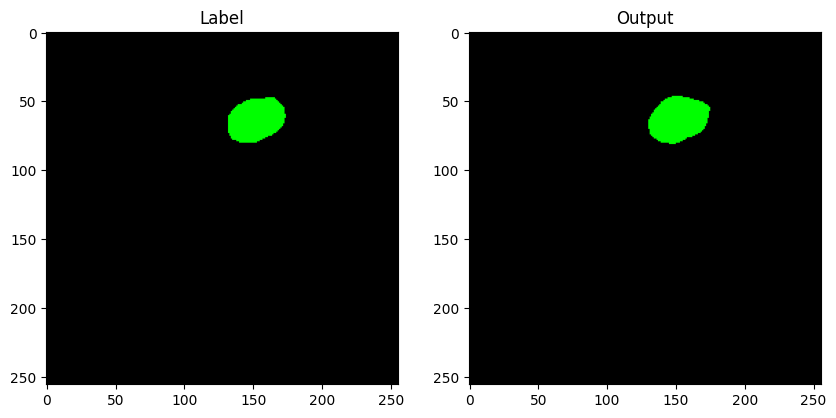

Epoch [87/200], Loss: 0.0727517399


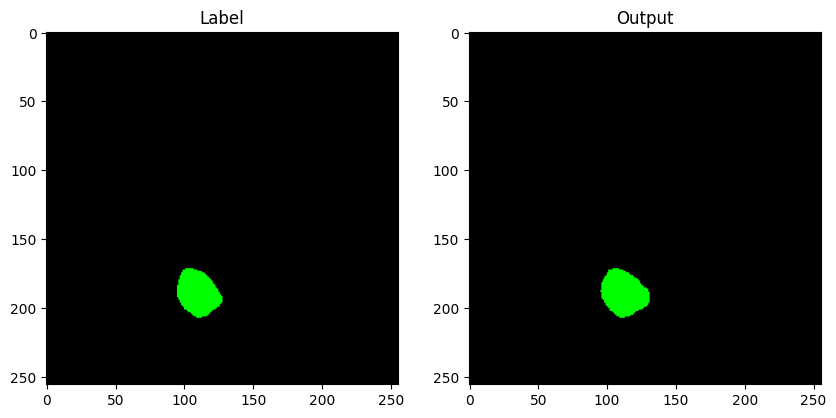

Epoch [88/200], Loss: 0.0696689403


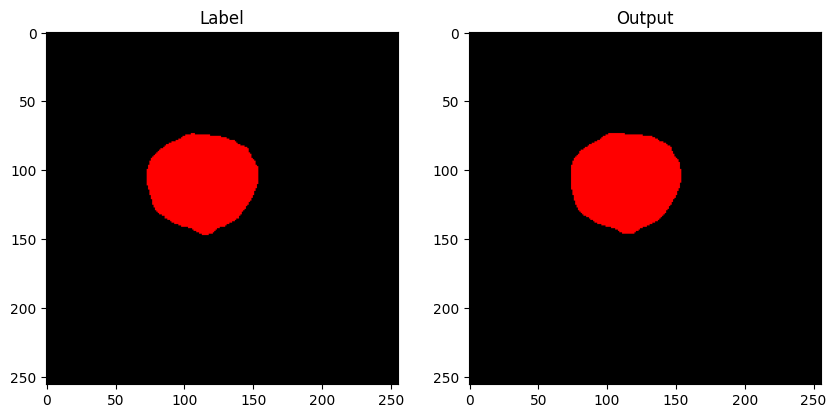

Epoch [89/200], Loss: 0.0698414376


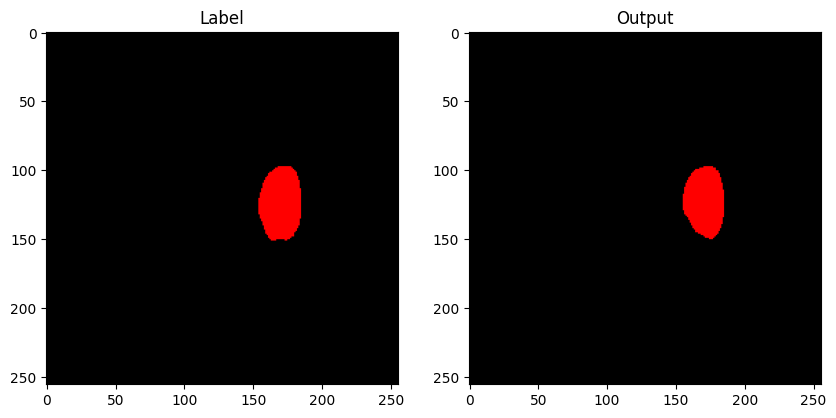

Epoch [90/200], Loss: 0.0645699345


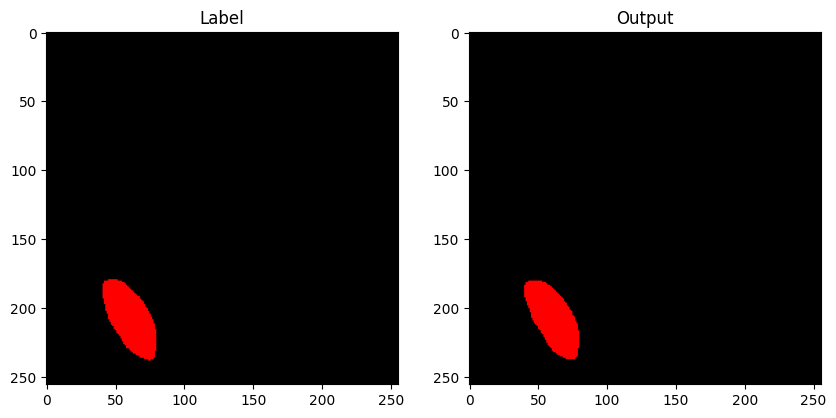

Epoch [91/200], Loss: 0.0722919512


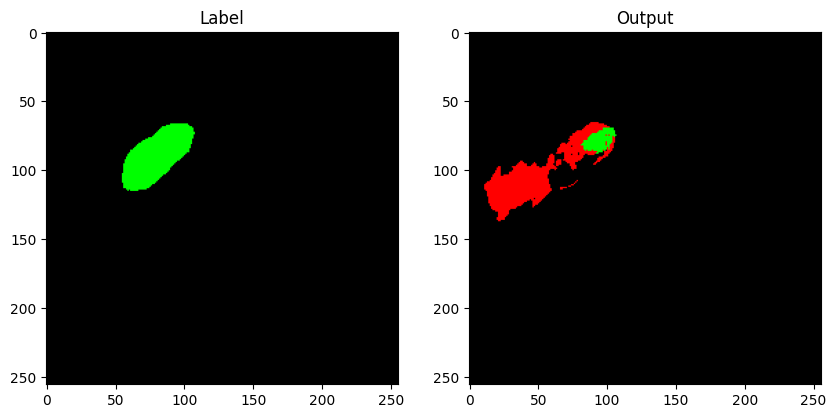

Epoch [92/200], Loss: 0.0665687018


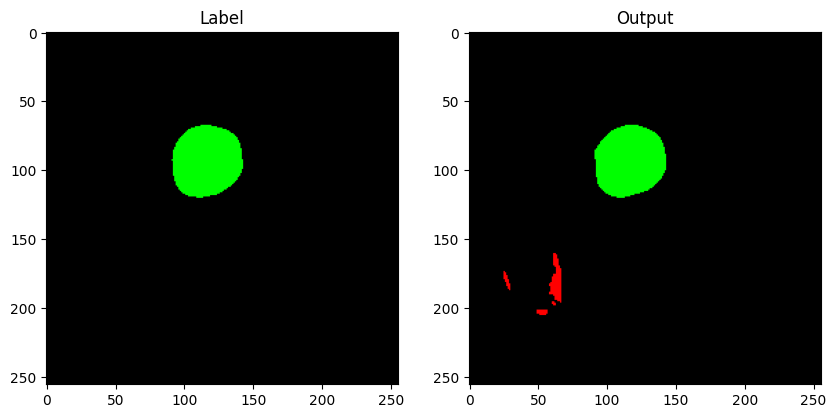

Epoch [93/200], Loss: 0.0629533669


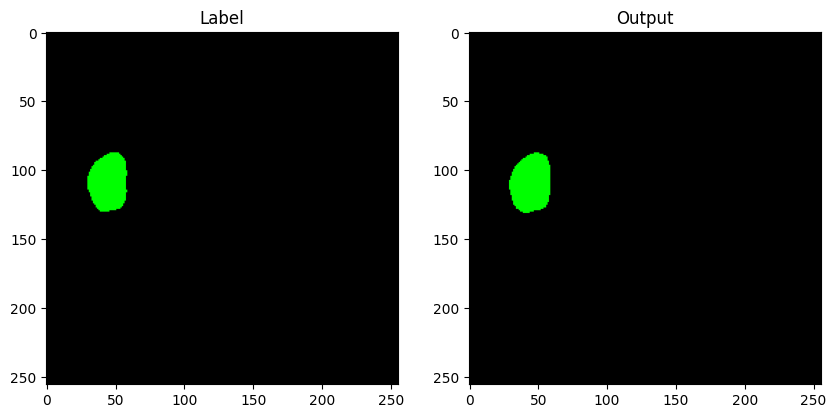

Epoch [94/200], Loss: 0.0655416246


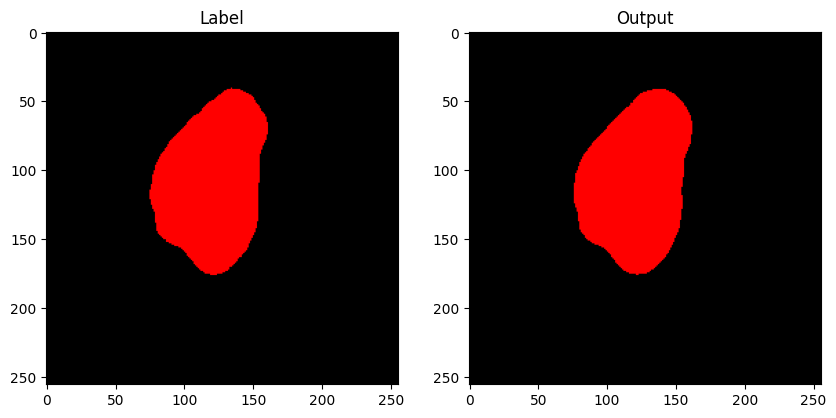

Epoch [95/200], Loss: 0.0616894446


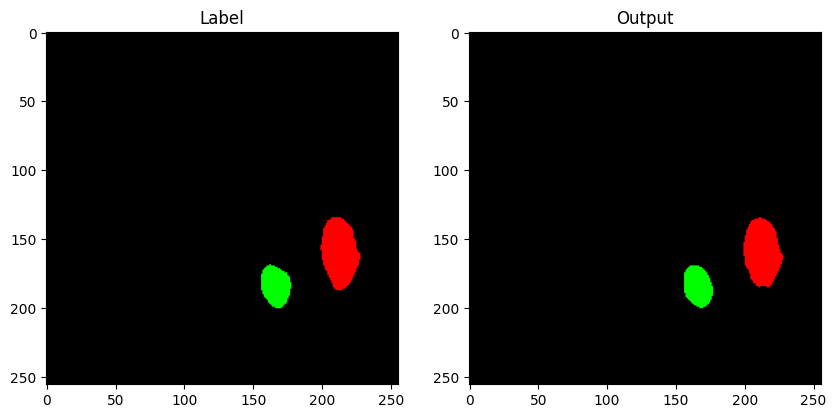

Epoch [96/200], Loss: 0.0650766598


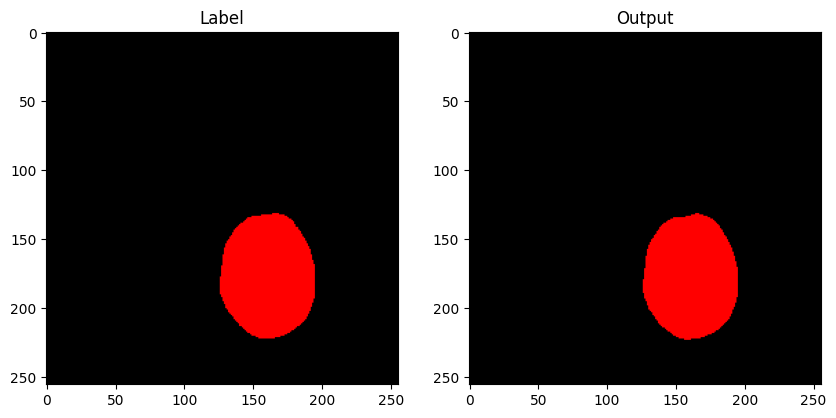

Epoch [97/200], Loss: 0.0669523534


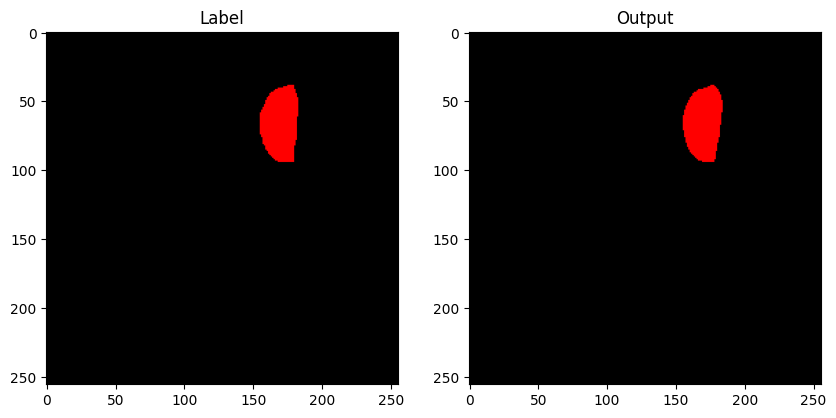

Epoch [98/200], Loss: 0.0768664565


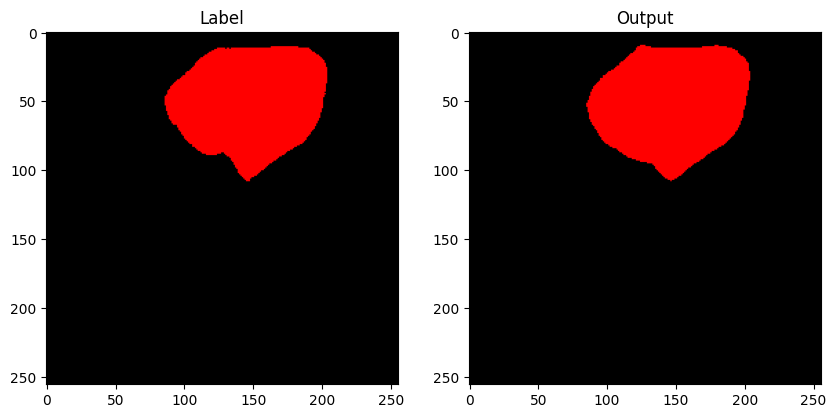

Epoch [99/200], Loss: 0.0701398320


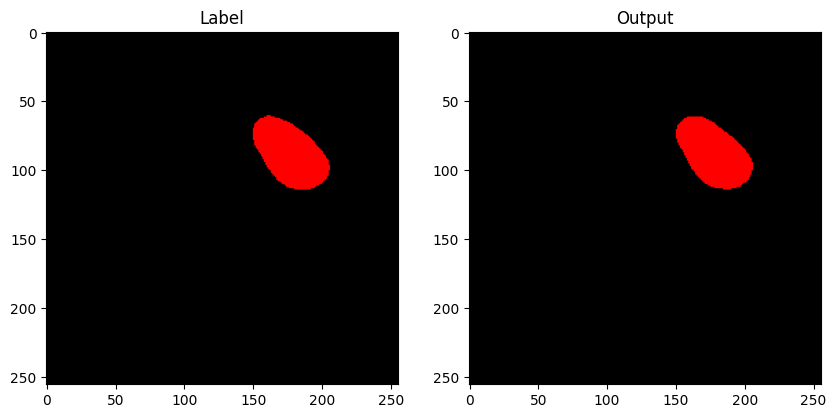

Epoch [100/200], Loss: 0.0810377220


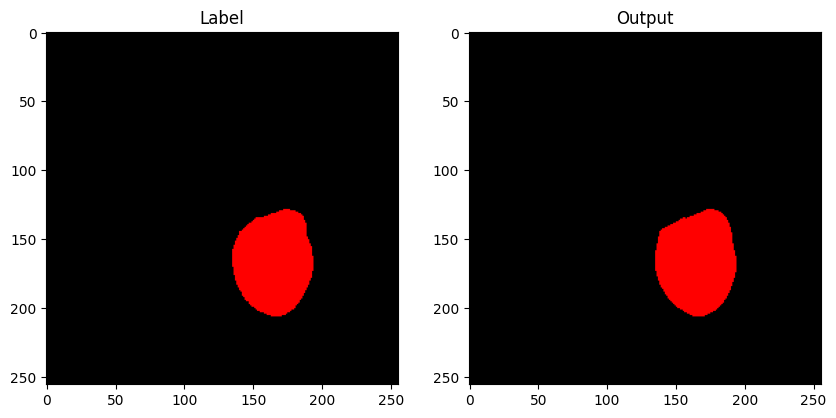

Epoch [101/200], Loss: 0.0950176408


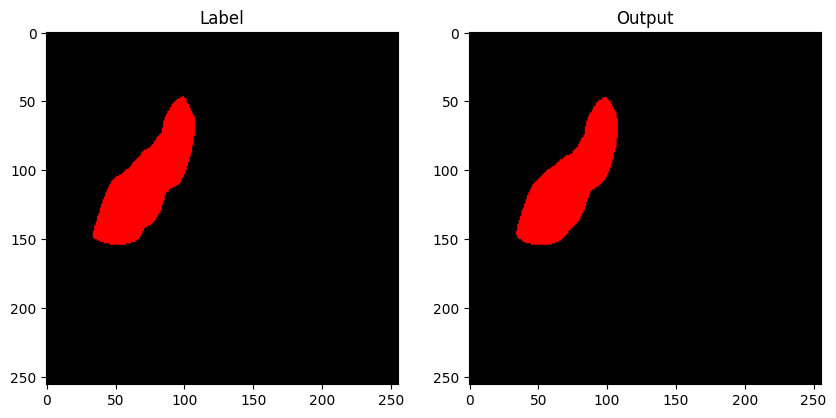

Epoch [102/200], Loss: 0.0862907935


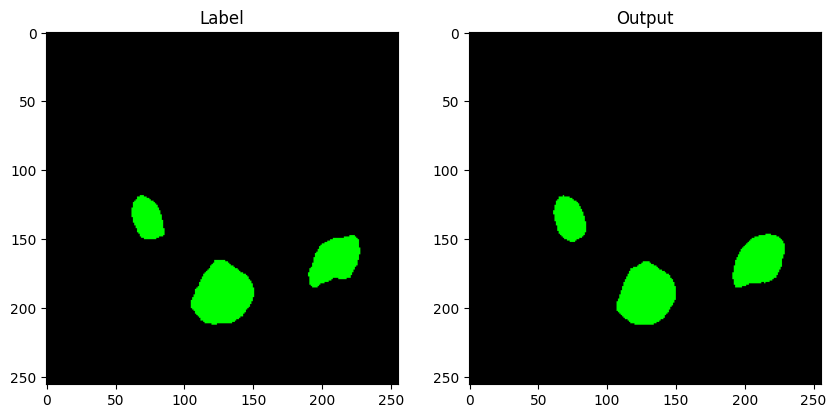

Epoch [103/200], Loss: 0.0722578234


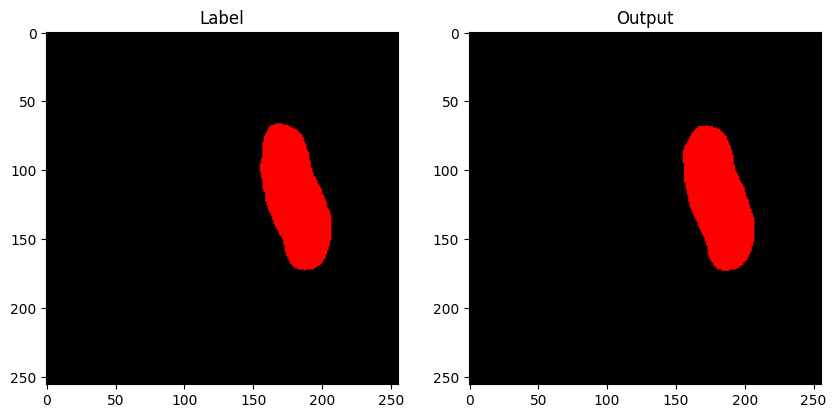

Epoch [104/200], Loss: 0.0944378463


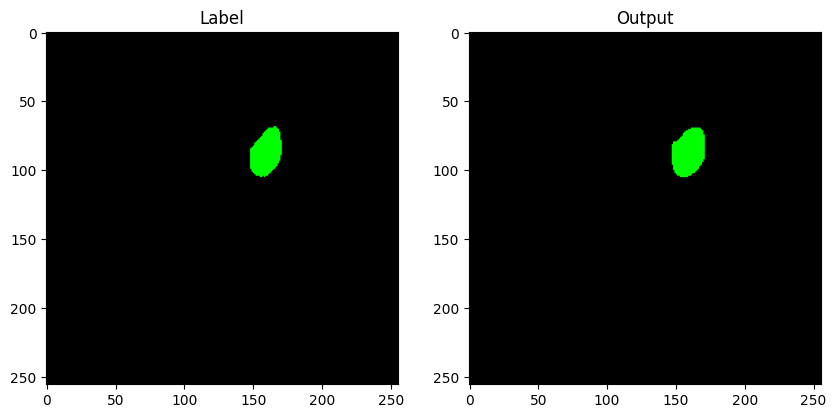

Epoch [105/200], Loss: 0.0777891646


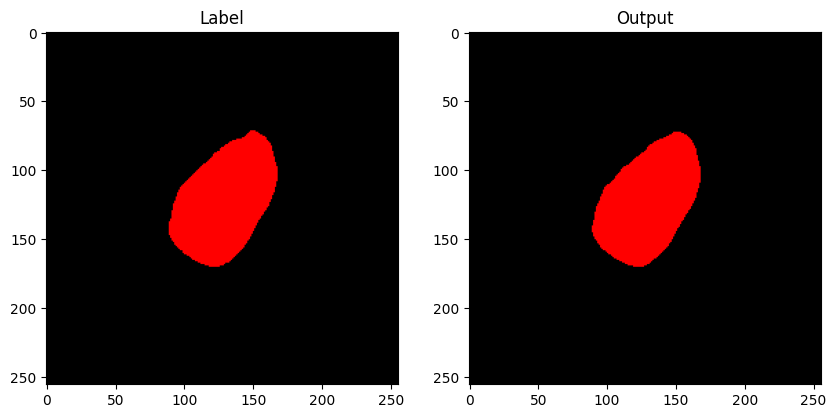

Epoch [106/200], Loss: 0.0873484849


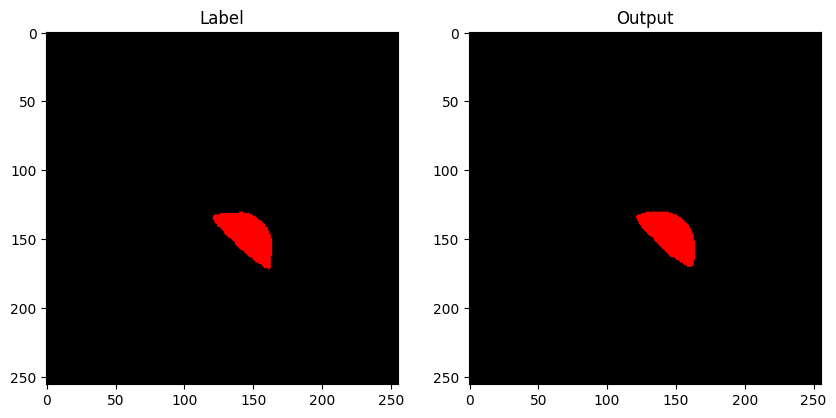

Epoch [107/200], Loss: 0.0771020313


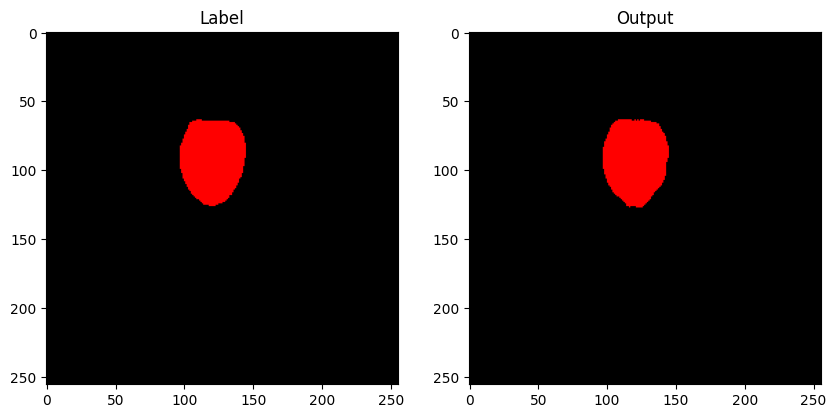

Epoch [108/200], Loss: 0.0706463407


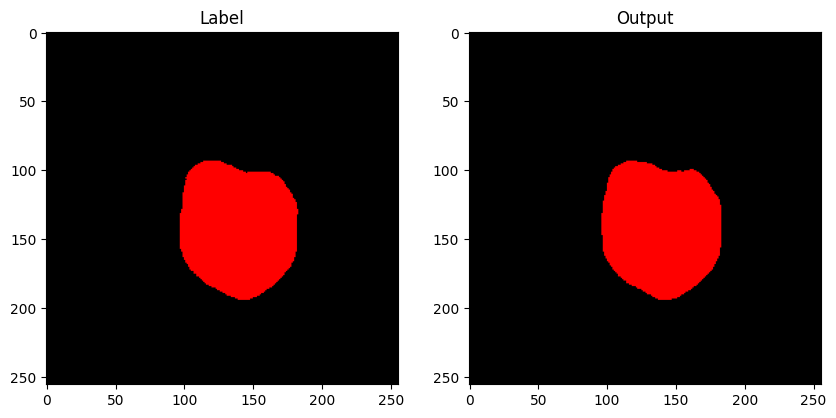

Epoch [109/200], Loss: 0.0664029379


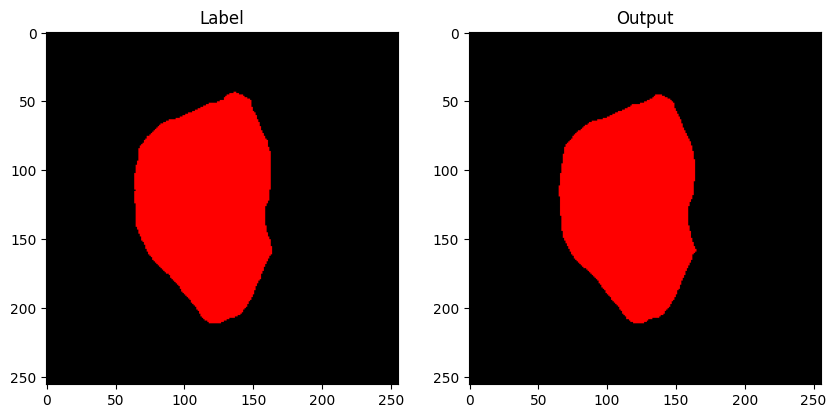

Epoch [110/200], Loss: 0.0808943900


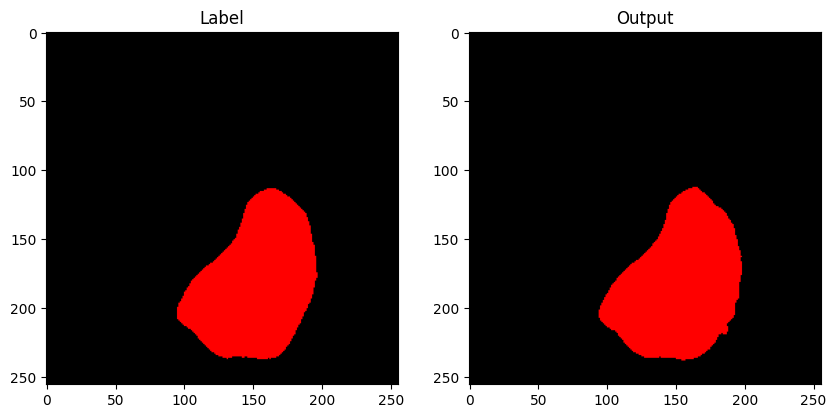

Epoch [111/200], Loss: 0.0658626985


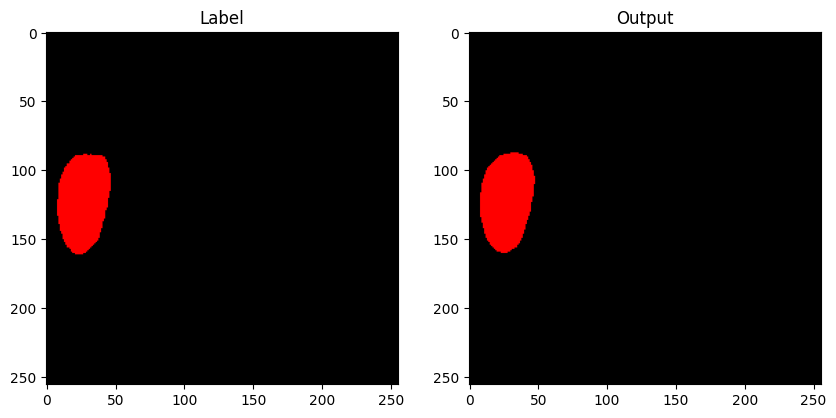

Epoch [112/200], Loss: 0.0725364146


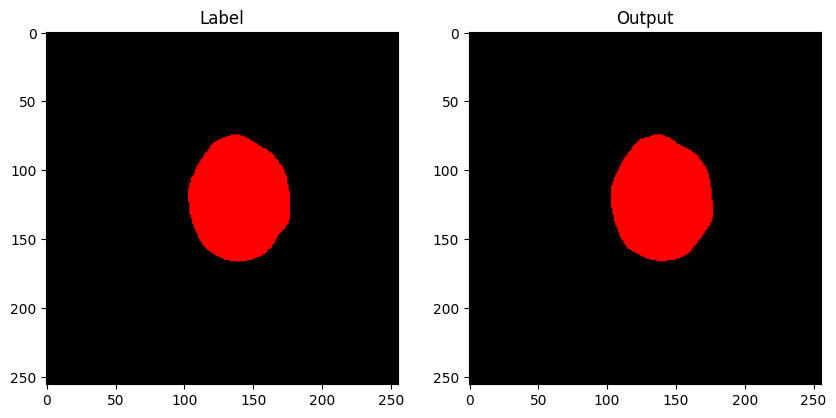

Epoch [113/200], Loss: 0.0738983716


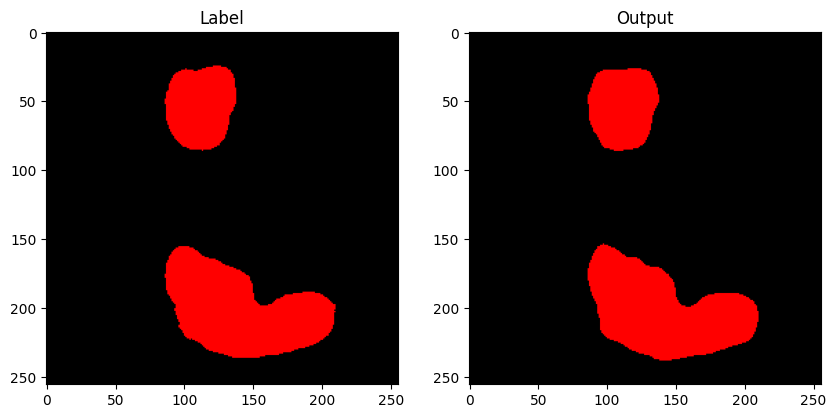

Epoch [114/200], Loss: 0.0767925326


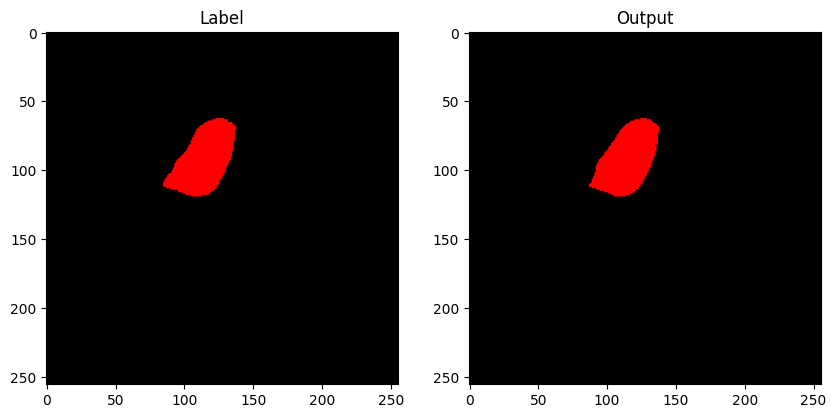

Epoch [115/200], Loss: 0.0737530884


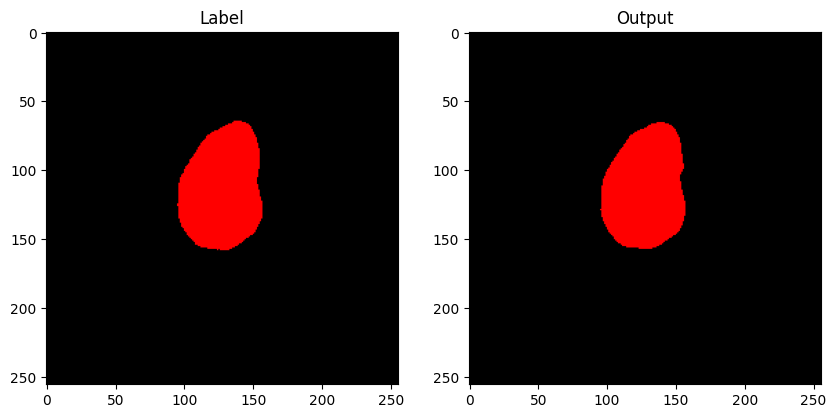

Epoch [116/200], Loss: 0.0739782838


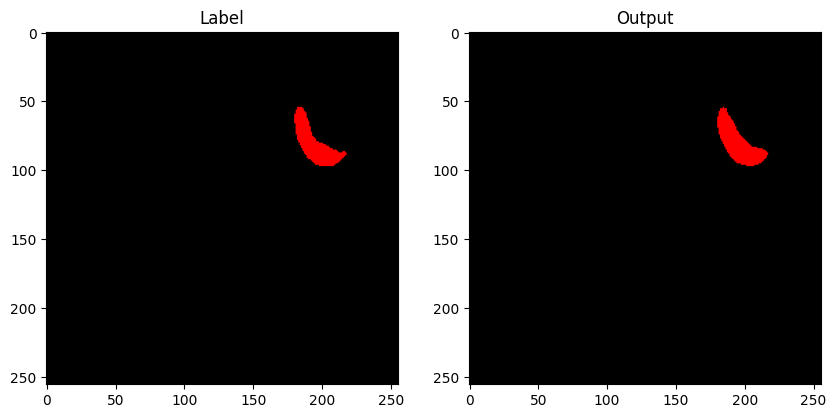

Epoch [117/200], Loss: 0.0800999513


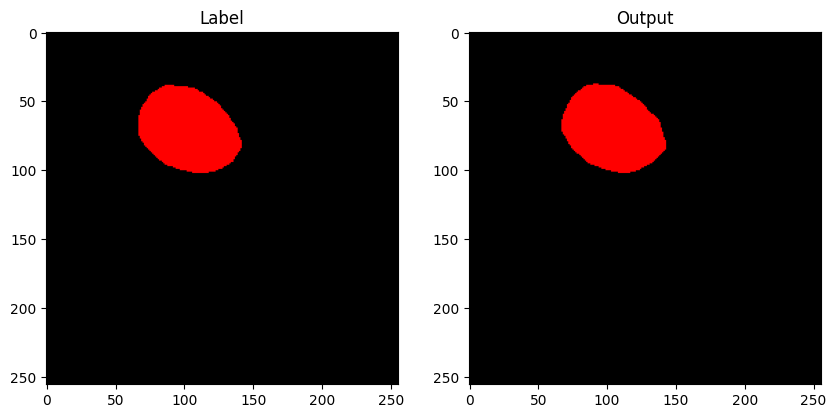

Epoch [118/200], Loss: 0.0816887812


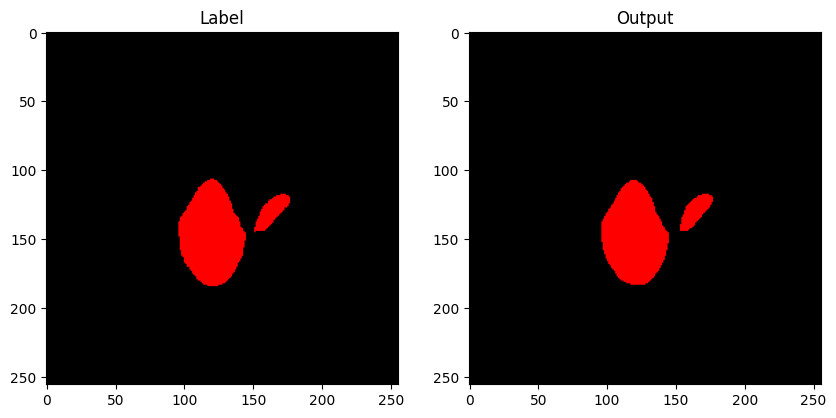

Epoch [119/200], Loss: 0.0776841205


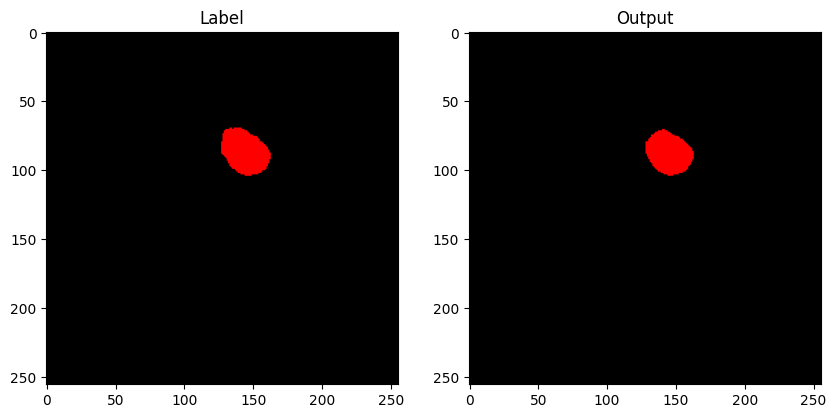

Epoch [120/200], Loss: 0.0880185734


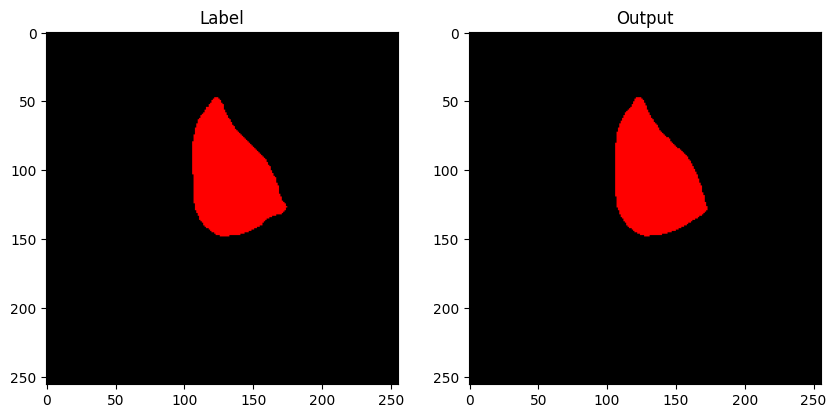

Epoch [121/200], Loss: 0.0797142592


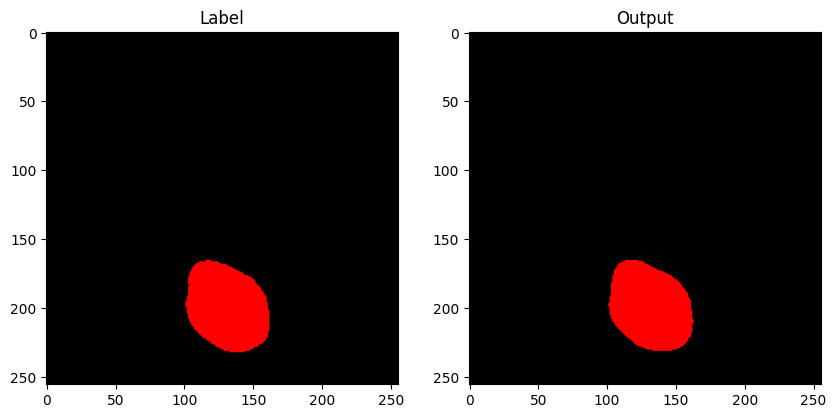

Epoch [122/200], Loss: 0.0734795793


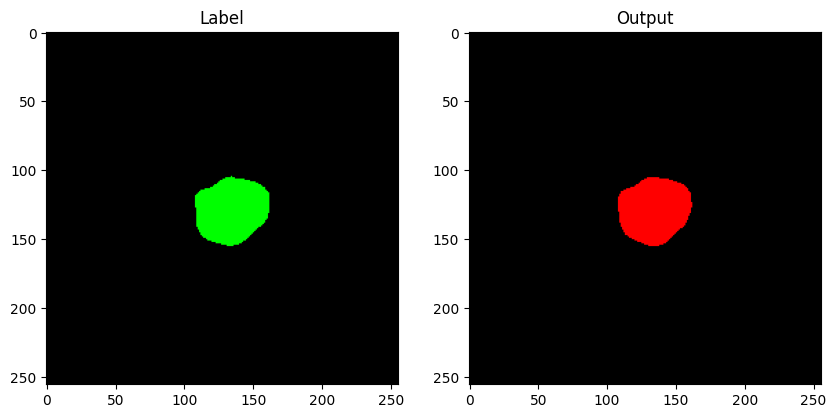

Epoch [123/200], Loss: 0.0956320662


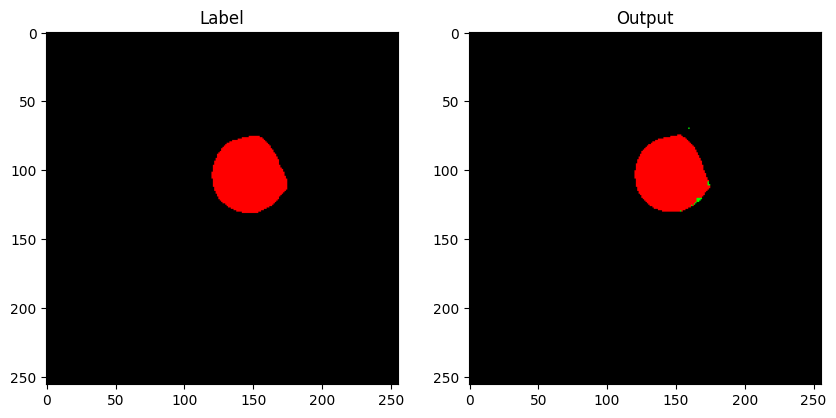

Epoch [124/200], Loss: 0.0830502990


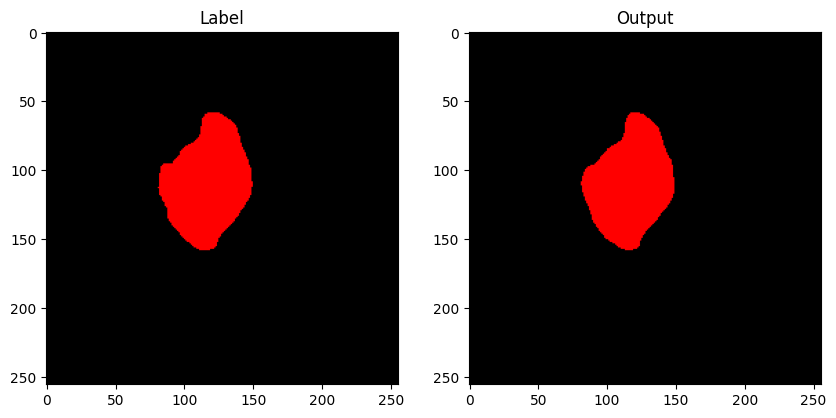

Epoch [125/200], Loss: 0.0903303613


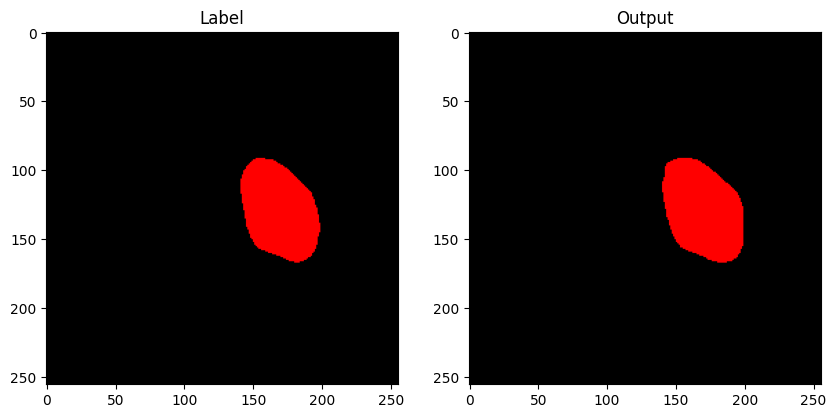

Epoch [126/200], Loss: 0.0919280675


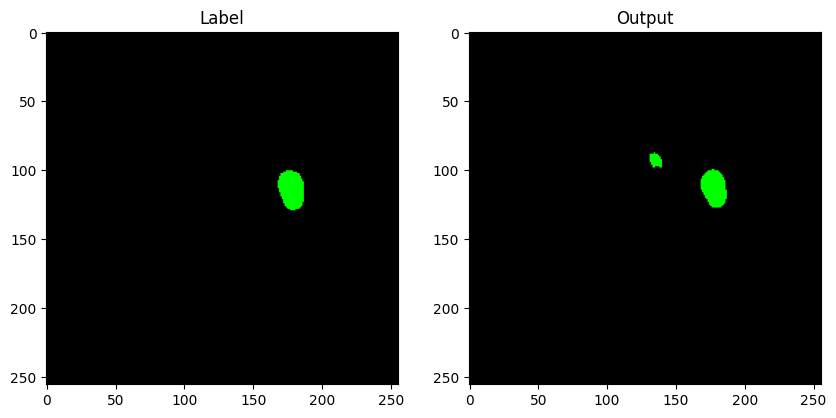

Epoch [127/200], Loss: 0.0749864074


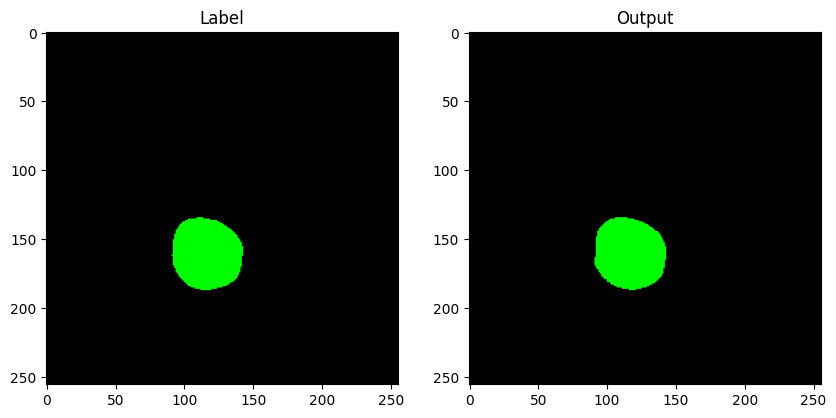

Epoch [128/200], Loss: 0.0760021187


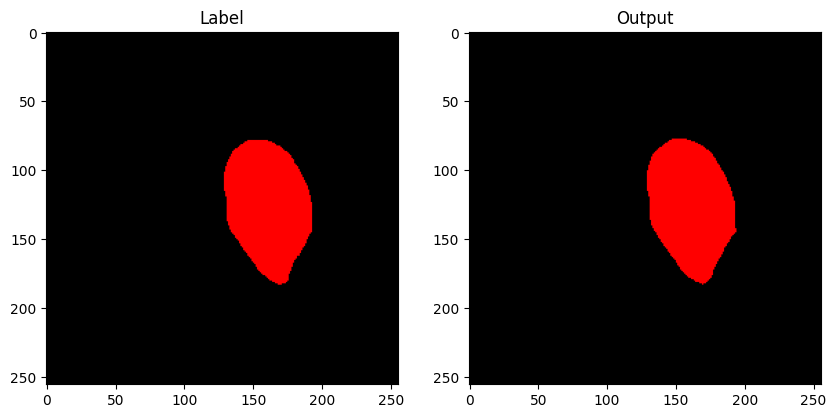

Epoch [129/200], Loss: 0.0771181346


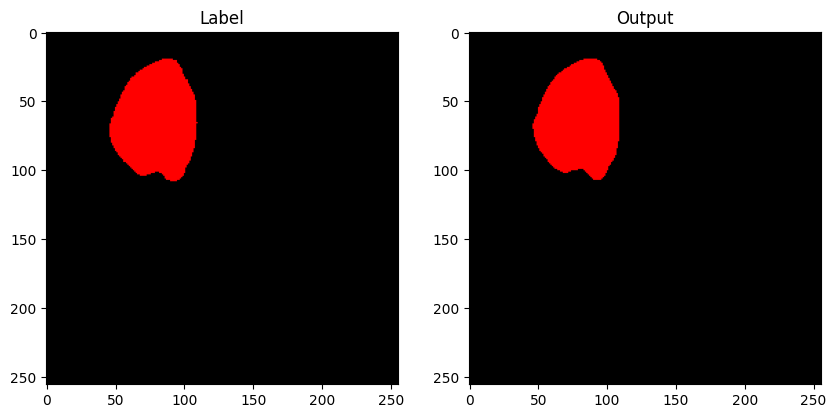

Epoch [130/200], Loss: 0.0714144837


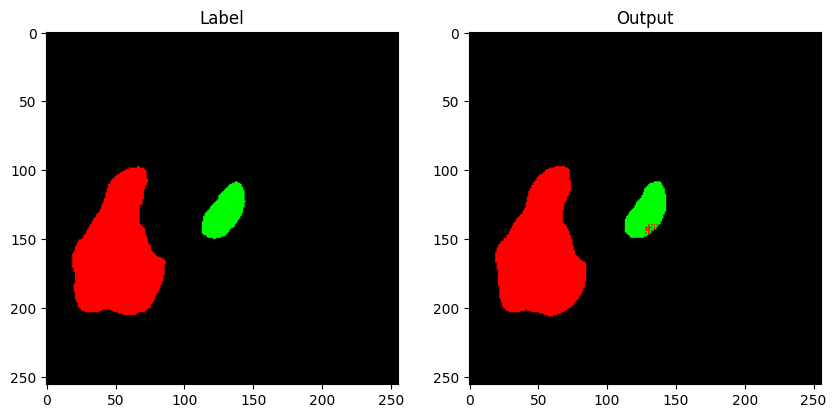

Epoch [131/200], Loss: 0.0856746275


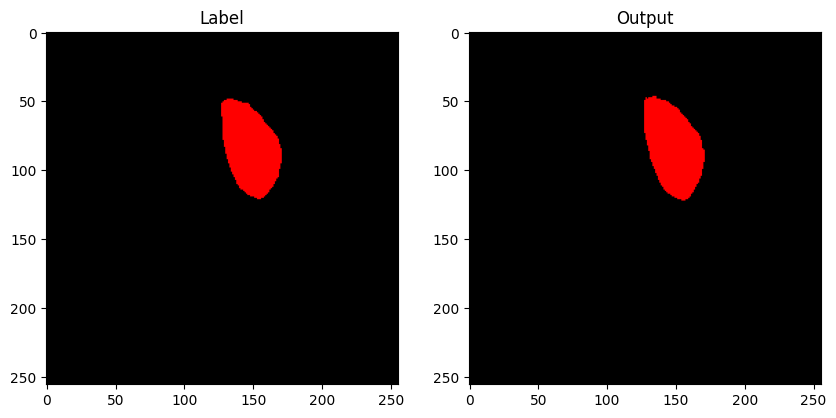

Epoch [132/200], Loss: 0.0849402654


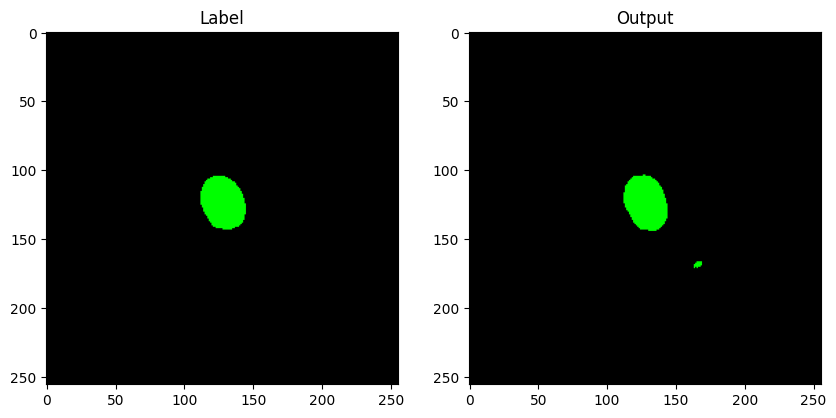

Epoch [133/200], Loss: 0.0748308964


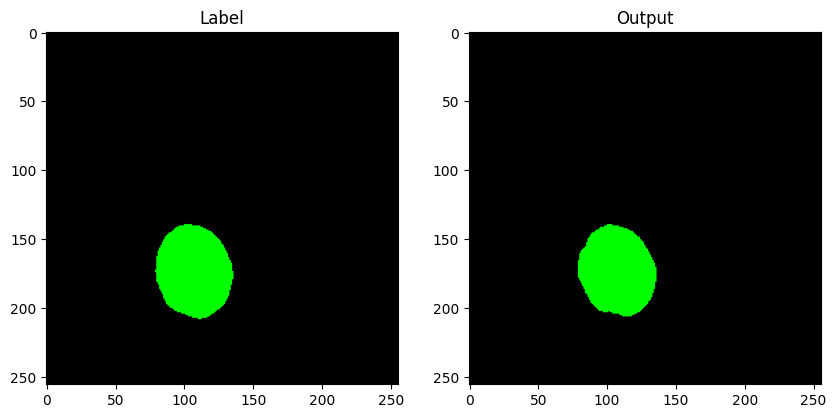

Epoch [134/200], Loss: 0.0768645834


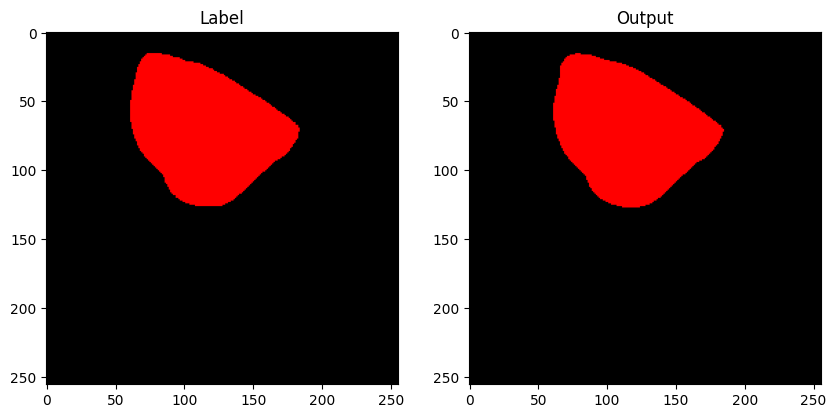

Epoch [135/200], Loss: 0.0781935509


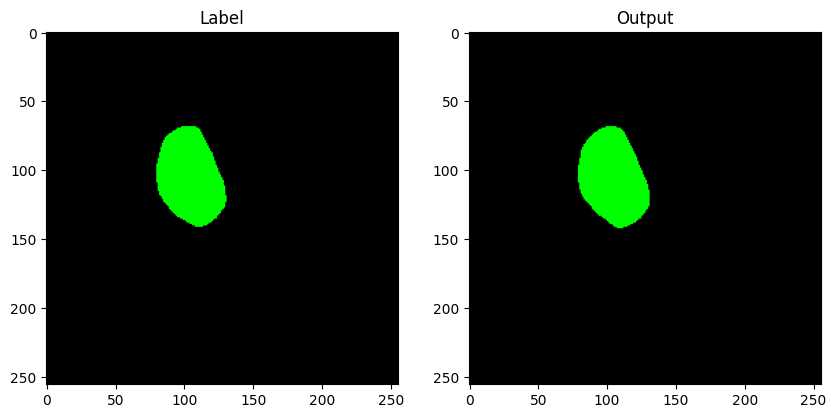

Epoch [136/200], Loss: 0.0779566424


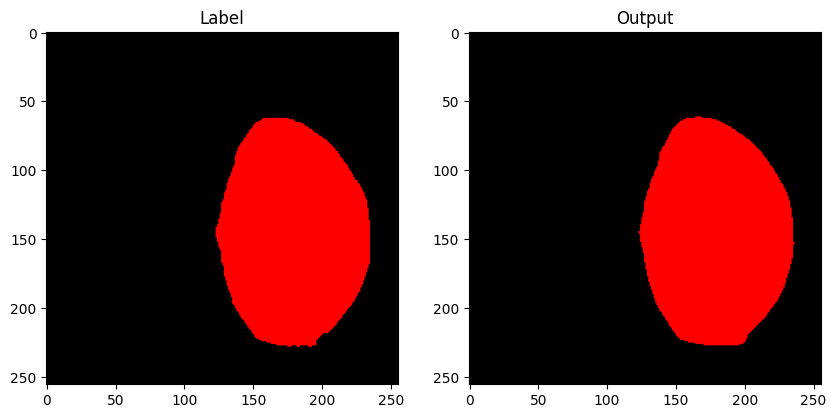

Epoch [137/200], Loss: 0.0806638637


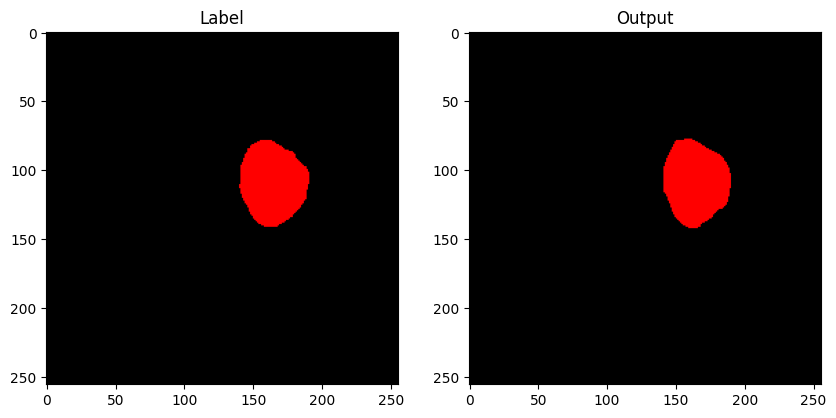

Epoch [138/200], Loss: 0.0839049507


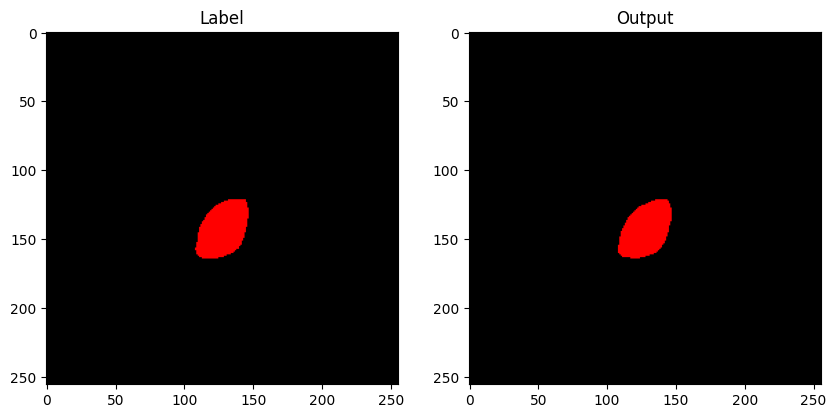

Epoch [139/200], Loss: 0.0816753388


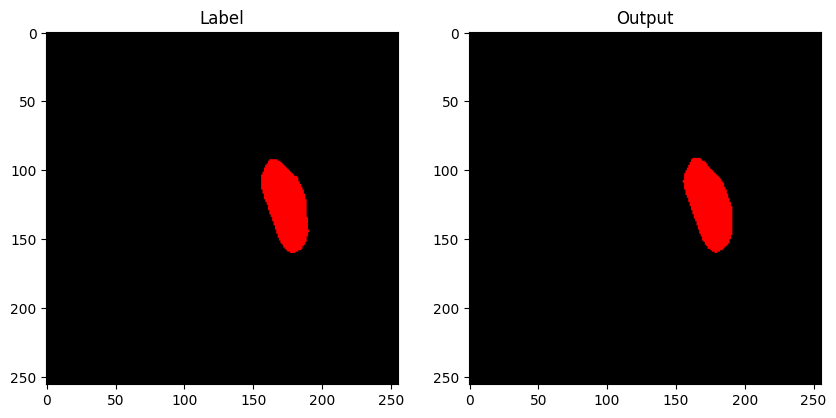

Epoch [140/200], Loss: 0.0822814786


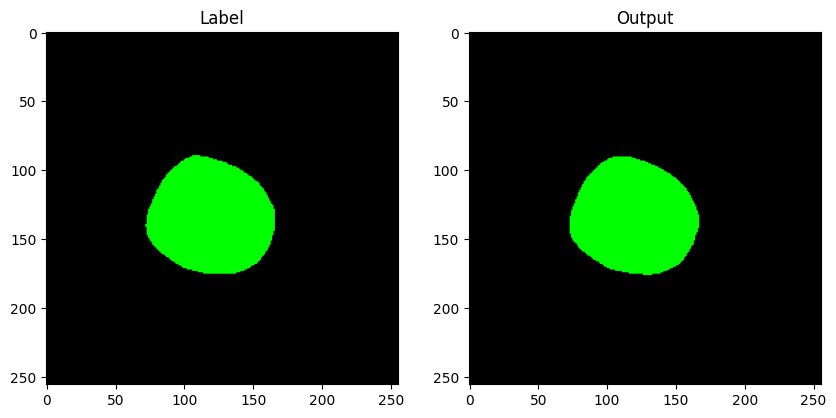

Epoch [141/200], Loss: 0.0872374337


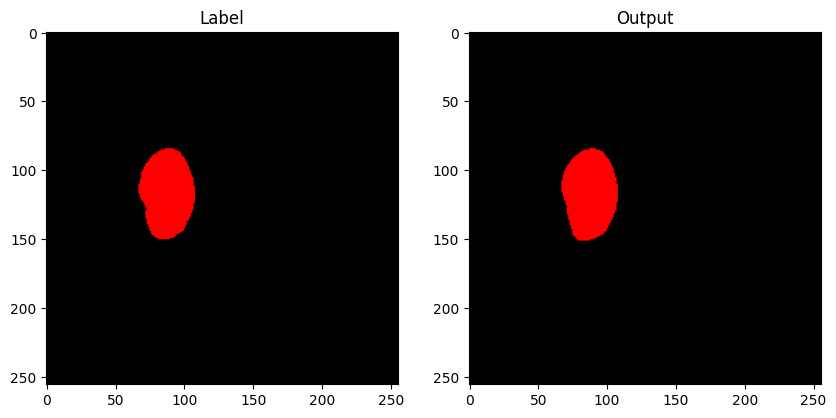

Epoch [142/200], Loss: 0.0854035009


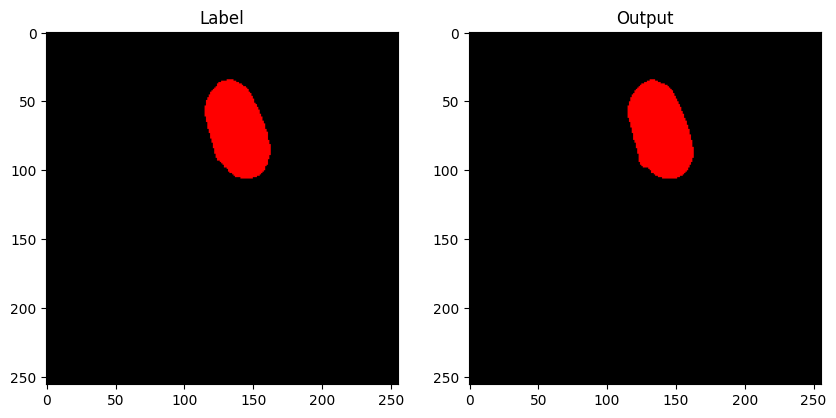

Epoch [143/200], Loss: 0.0892693626


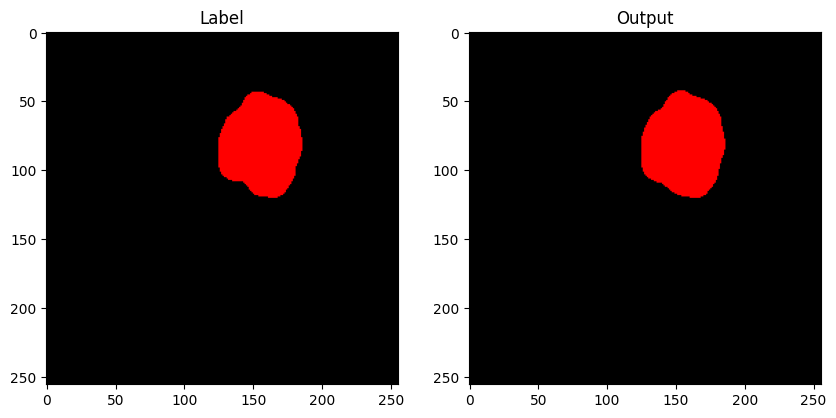

Epoch [144/200], Loss: 0.0969967040


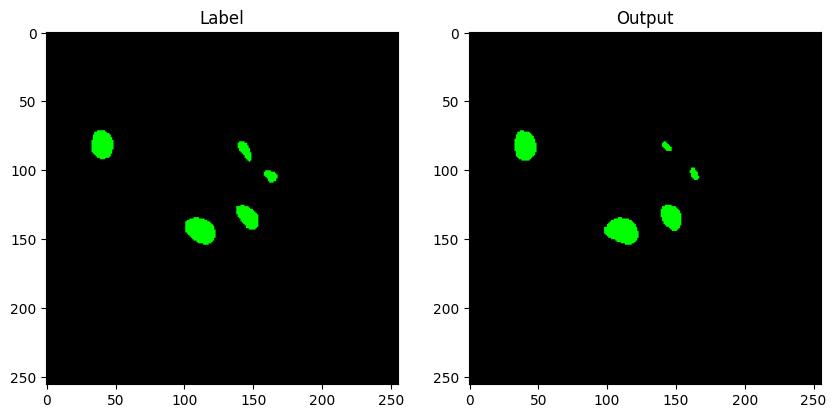

Epoch [145/200], Loss: 0.0744611153


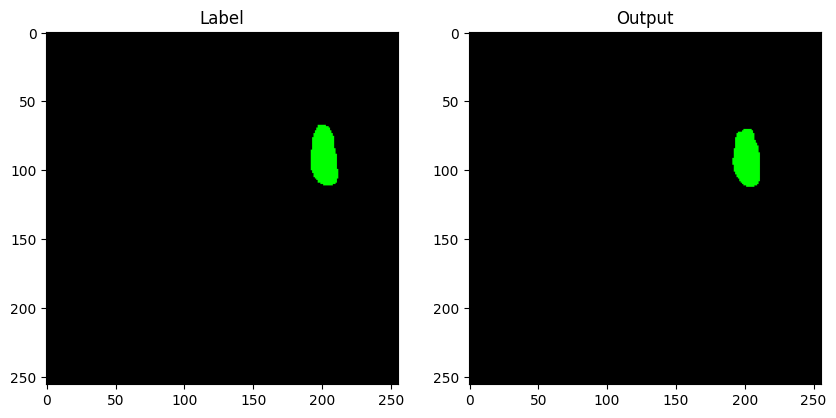

Epoch [146/200], Loss: 0.0701599027


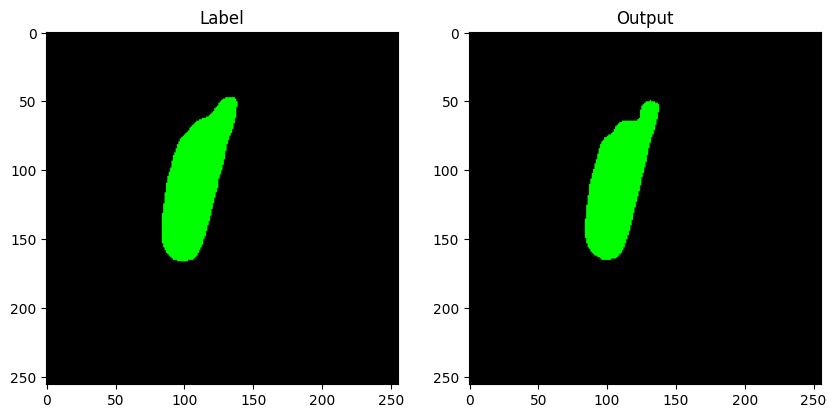

Epoch [147/200], Loss: 0.0789922585


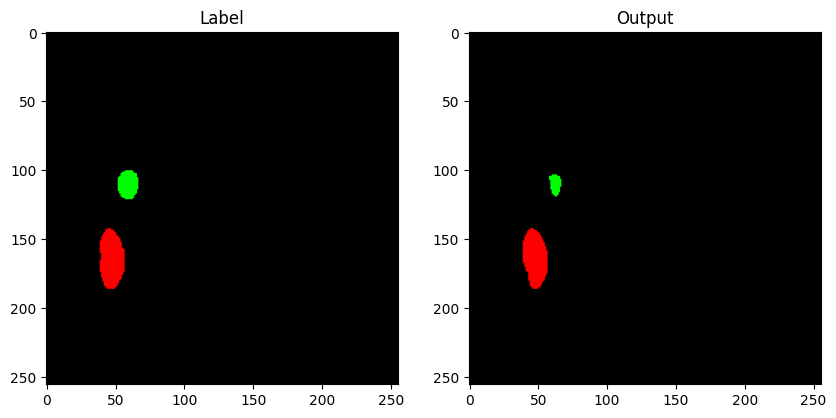

Epoch [148/200], Loss: 0.0903748287


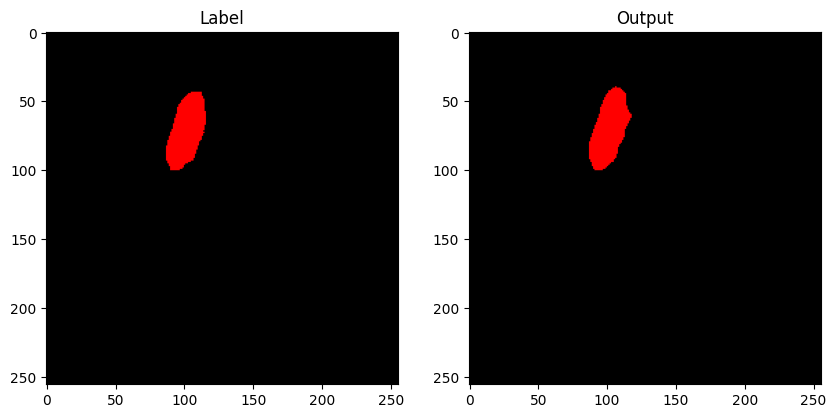

Epoch [149/200], Loss: 0.0946014277


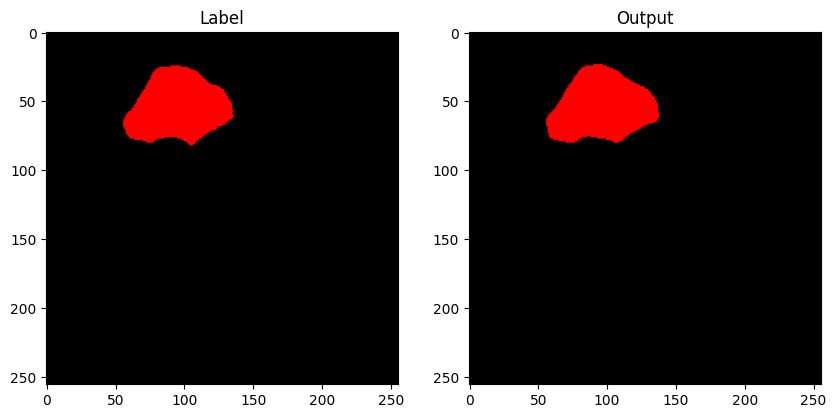

Epoch [150/200], Loss: 0.0811400349


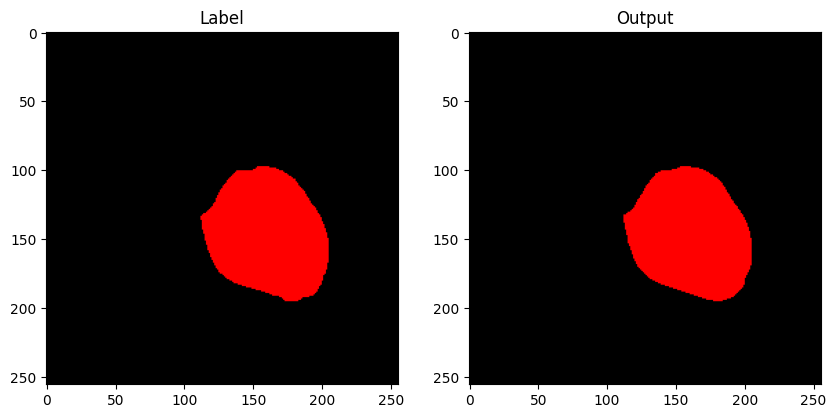

Epoch [151/200], Loss: 0.0912830551


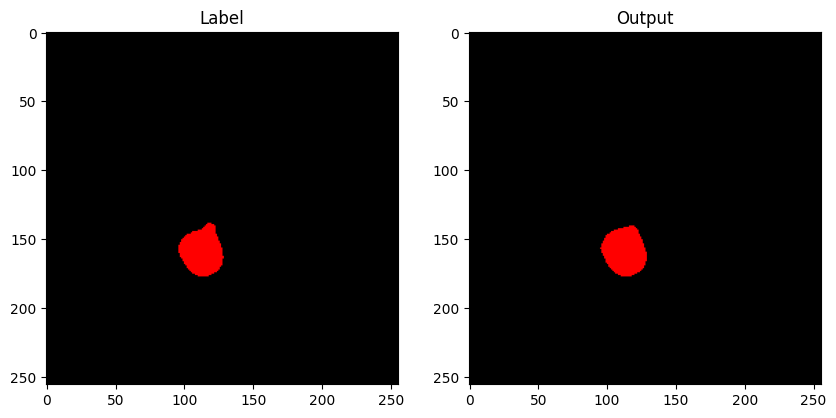

Epoch [152/200], Loss: 0.0963529708


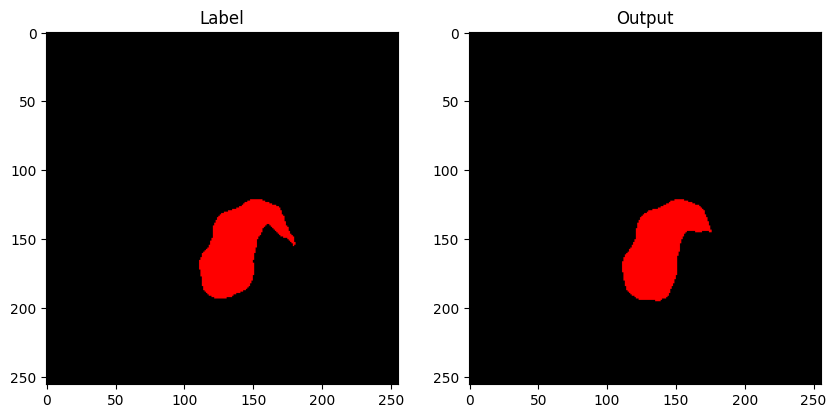

Epoch [153/200], Loss: 0.0829196442


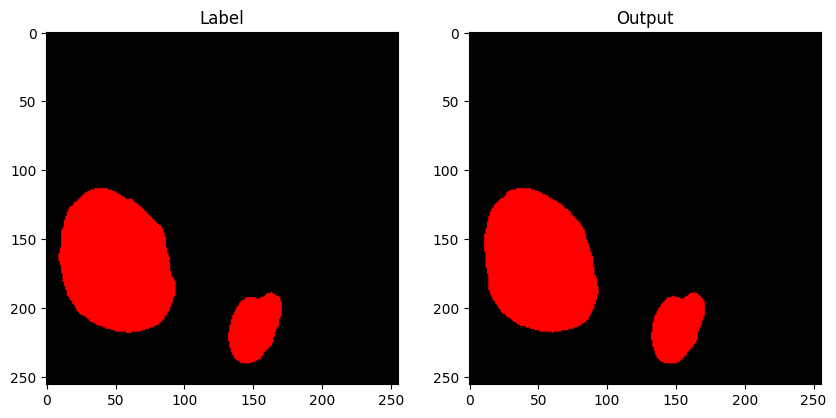

Epoch [154/200], Loss: 0.0857769158


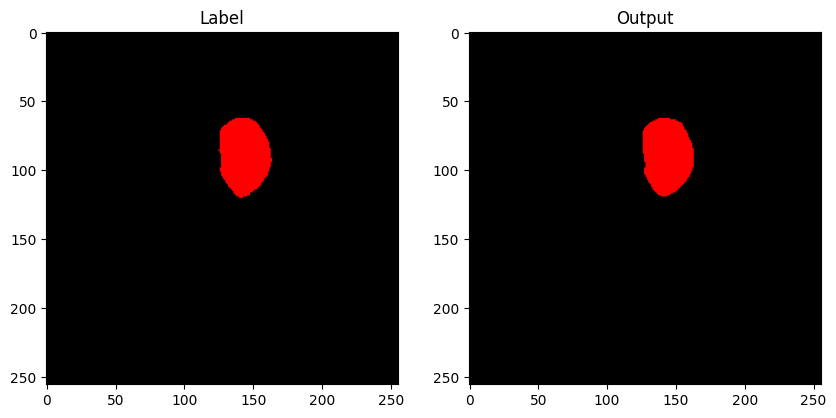

Epoch [155/200], Loss: 0.0825220776


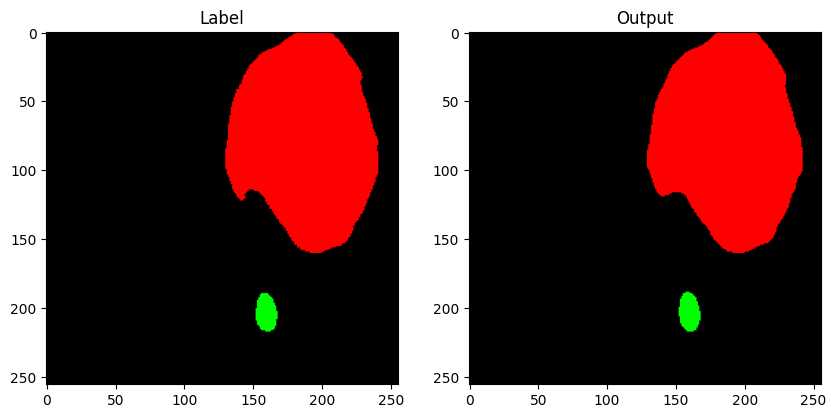

Epoch [156/200], Loss: 0.0925458064


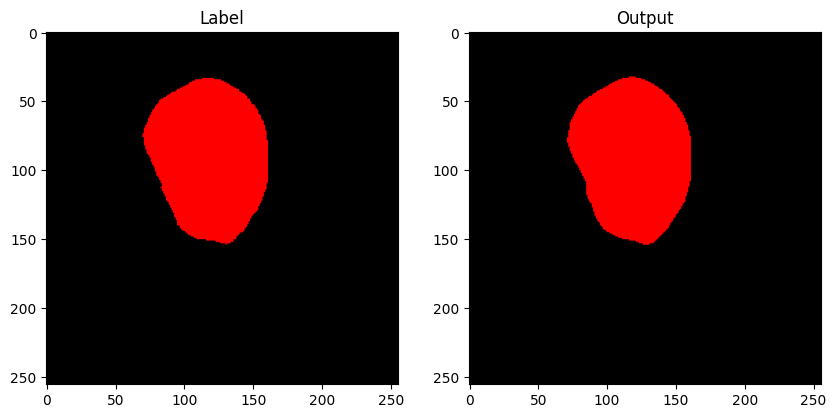

Epoch [157/200], Loss: 0.1096294719


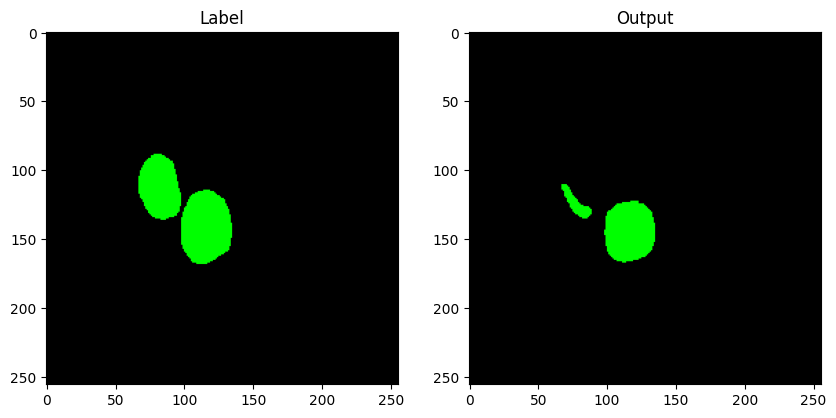

Epoch [158/200], Loss: 0.0887856269


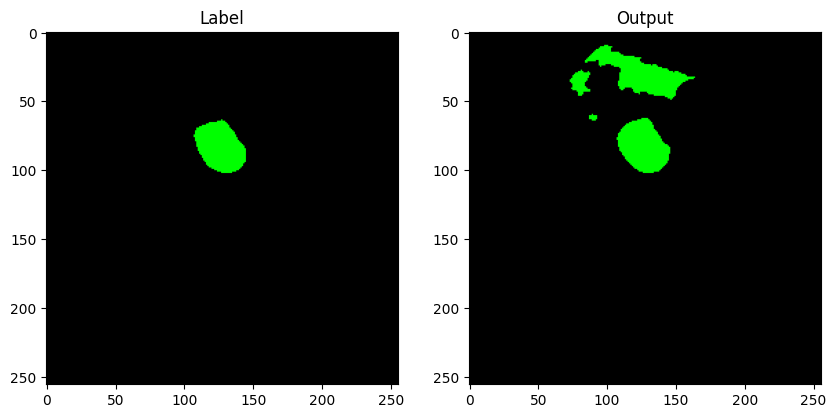

Epoch [159/200], Loss: 0.0622223848


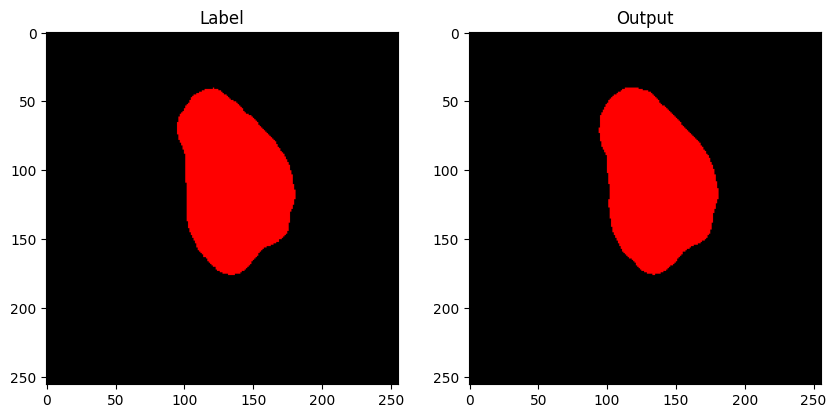

Epoch [160/200], Loss: 0.0691654030


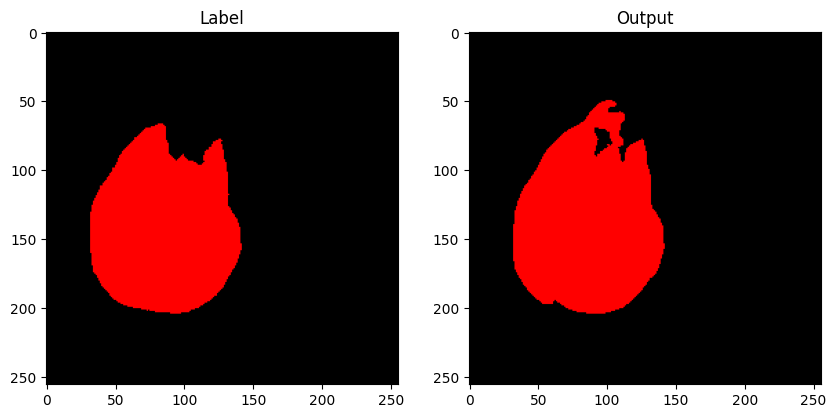

Epoch [161/200], Loss: 0.0748195901


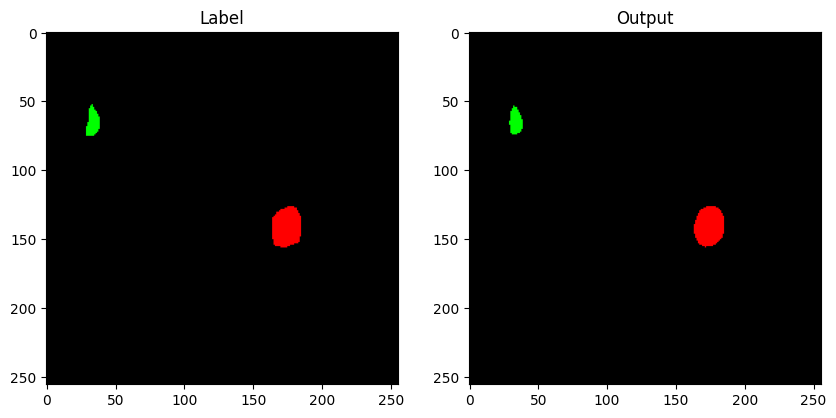

Epoch [162/200], Loss: 0.0760458318


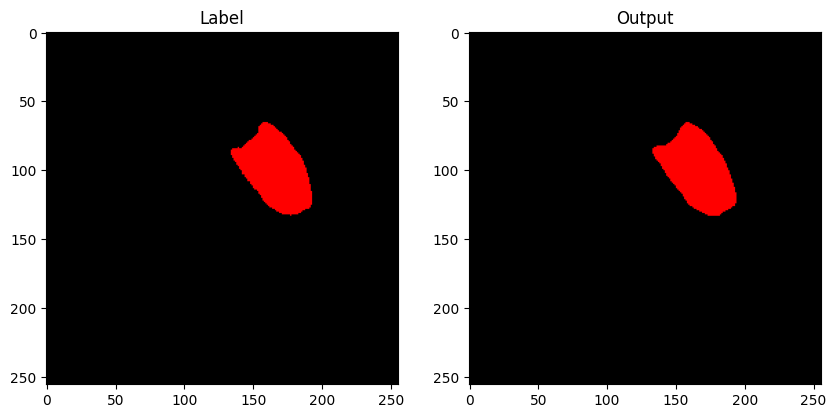

Epoch [163/200], Loss: 0.0752041370


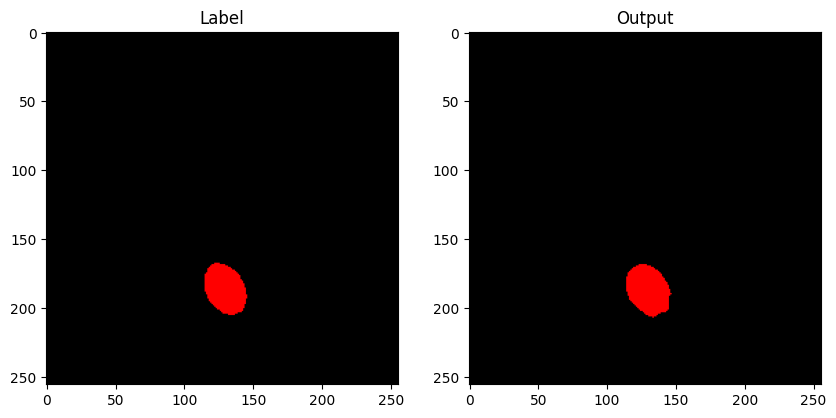

Epoch [164/200], Loss: 0.0709423139


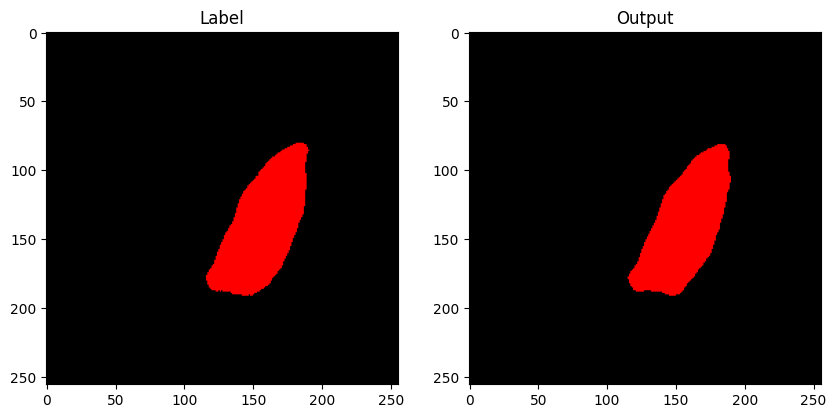

Epoch [165/200], Loss: 0.0690015448


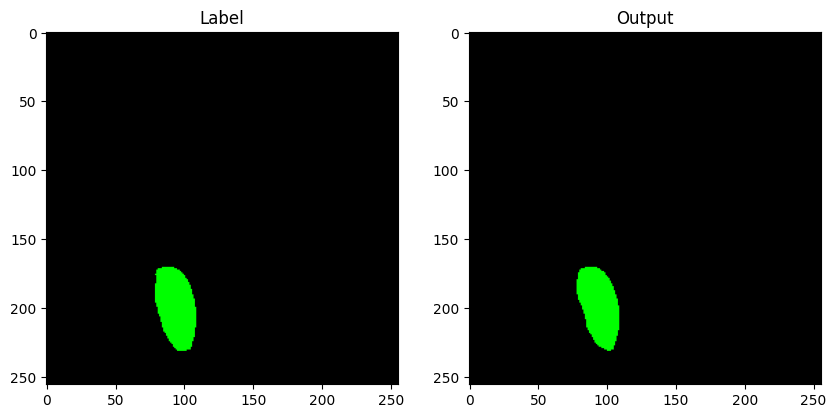

Epoch [166/200], Loss: 0.0717375546


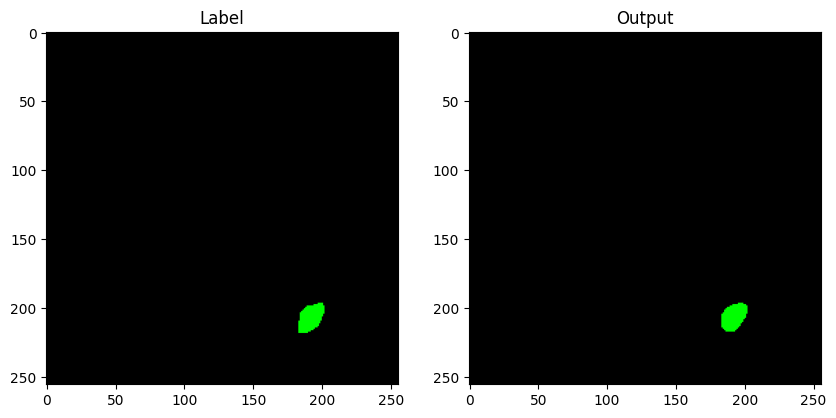

Epoch [167/200], Loss: 0.0733865635


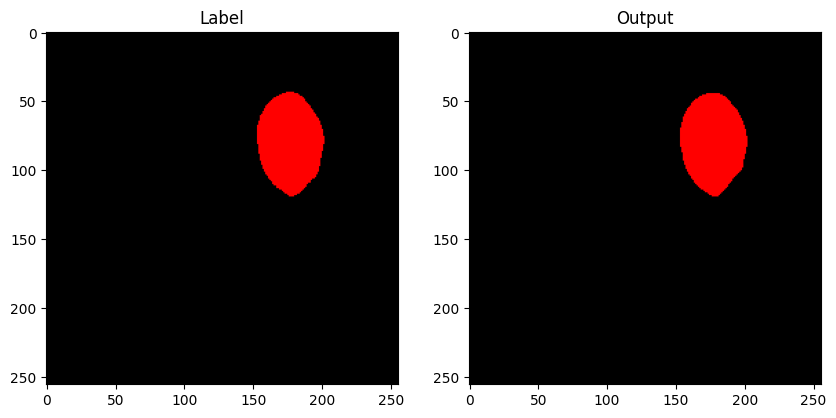

Epoch [168/200], Loss: 0.0720181106


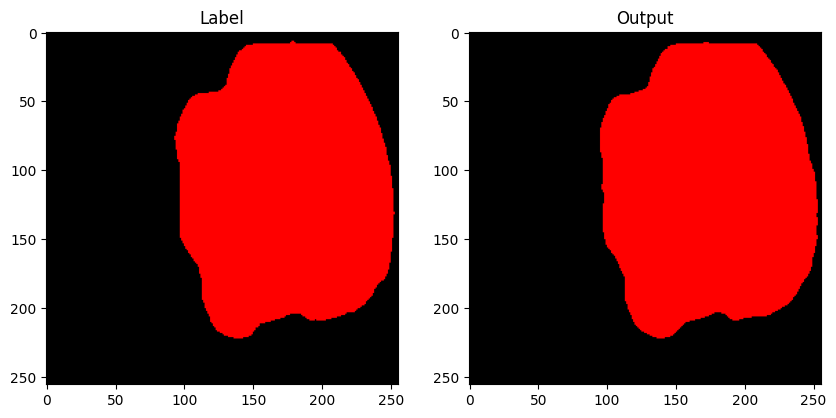

Epoch [169/200], Loss: 0.0727886657


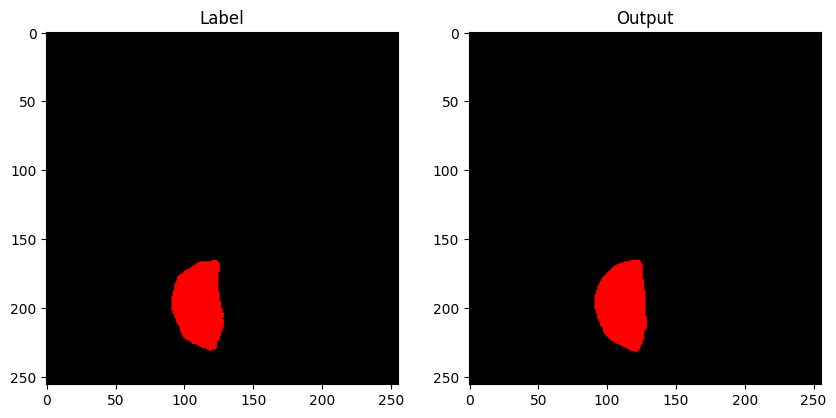

Epoch [170/200], Loss: 0.0732829712


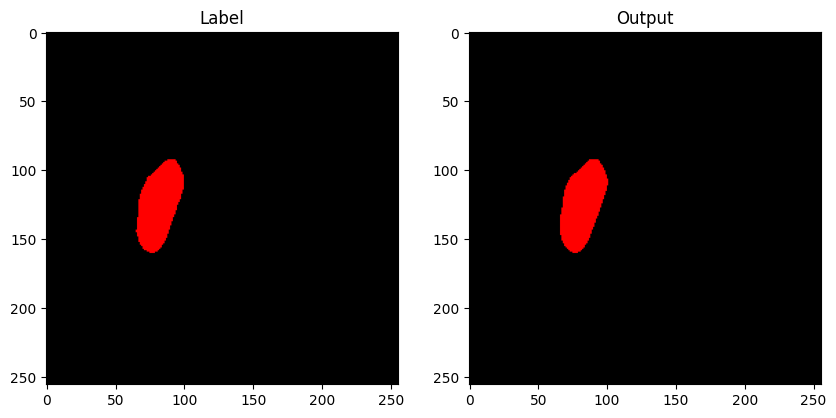

Epoch [171/200], Loss: 0.0994451930


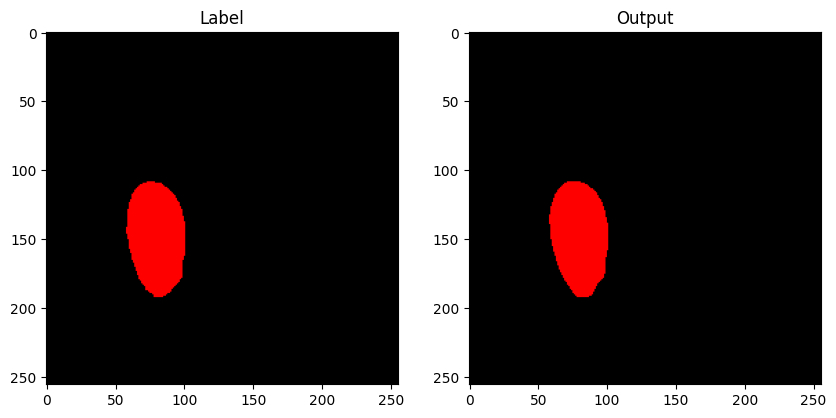

Epoch [172/200], Loss: 0.0780358570


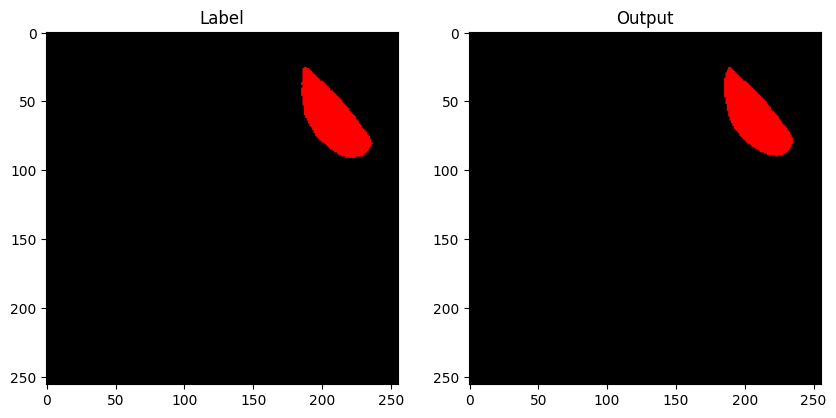

Epoch [173/200], Loss: 0.0811453932


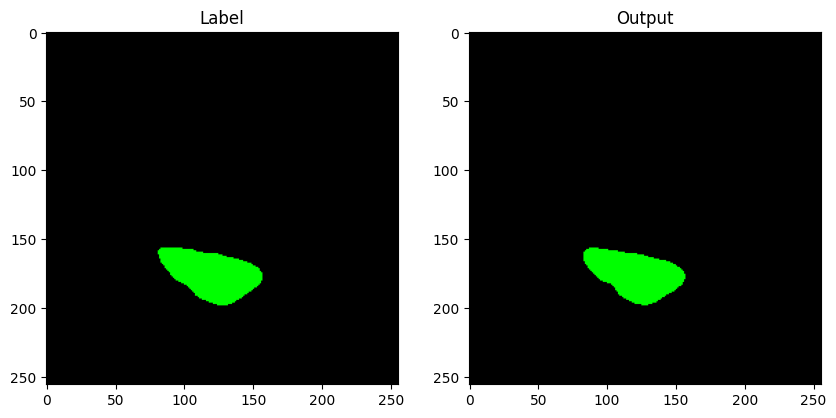

Epoch [174/200], Loss: 0.0852701313


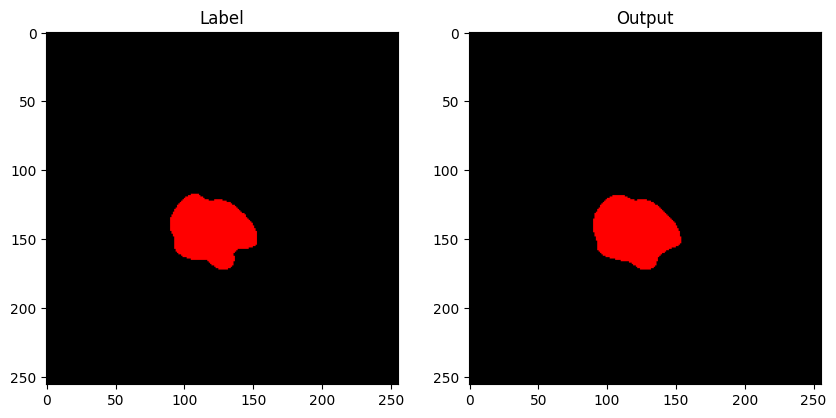

Epoch [175/200], Loss: 0.0805180553


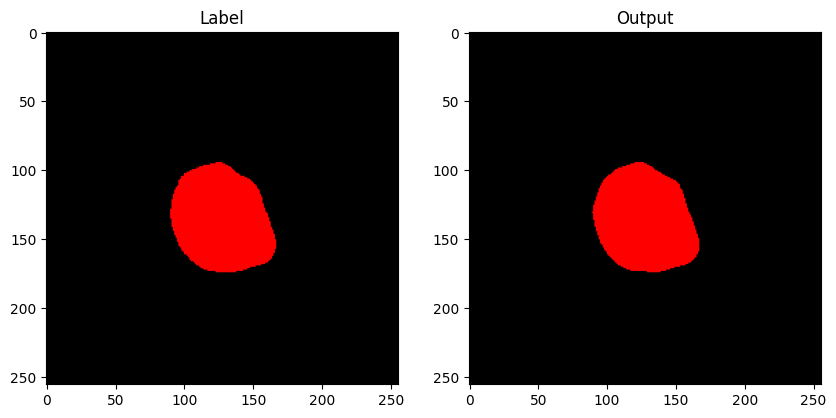

Epoch [176/200], Loss: 0.0812994141


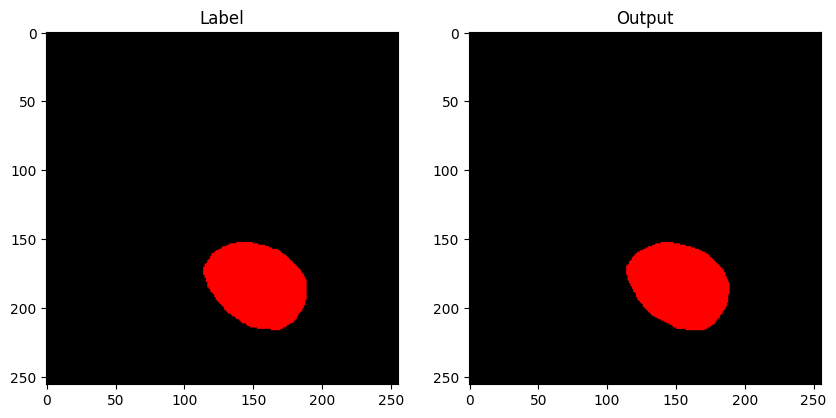

Epoch [177/200], Loss: 0.0828108177


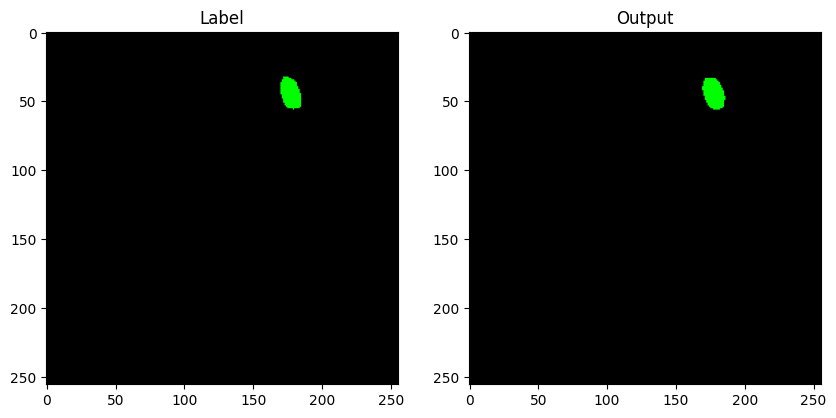

Epoch [178/200], Loss: 0.0861497185


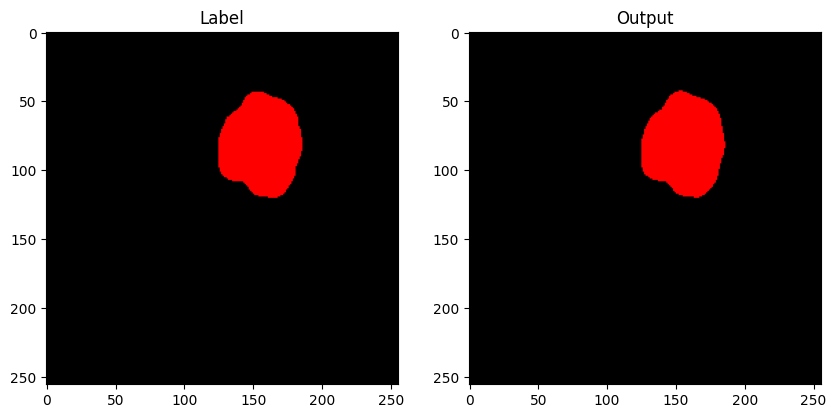

Epoch [179/200], Loss: 0.0896255740


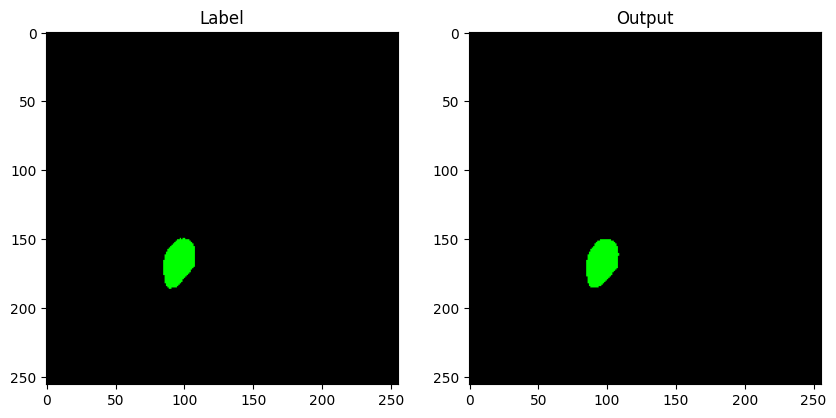

Epoch [180/200], Loss: 0.0915811755


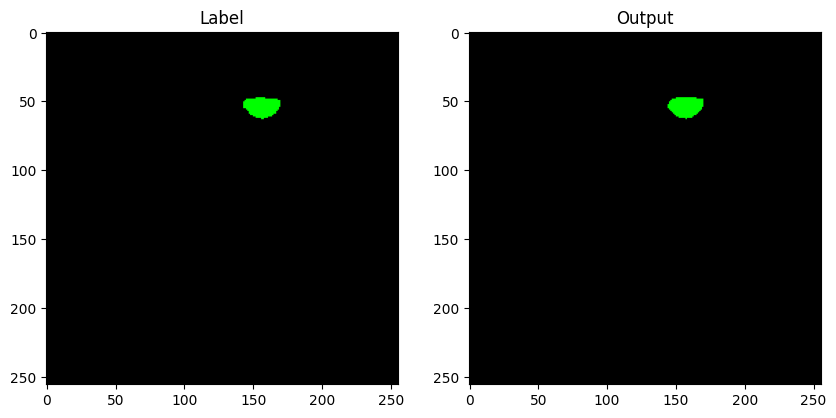

Epoch [181/200], Loss: 0.0908916047


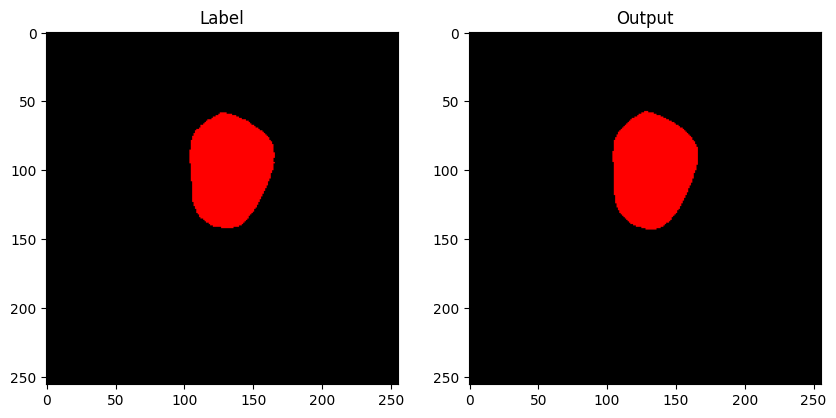

Epoch [182/200], Loss: 0.0978691274


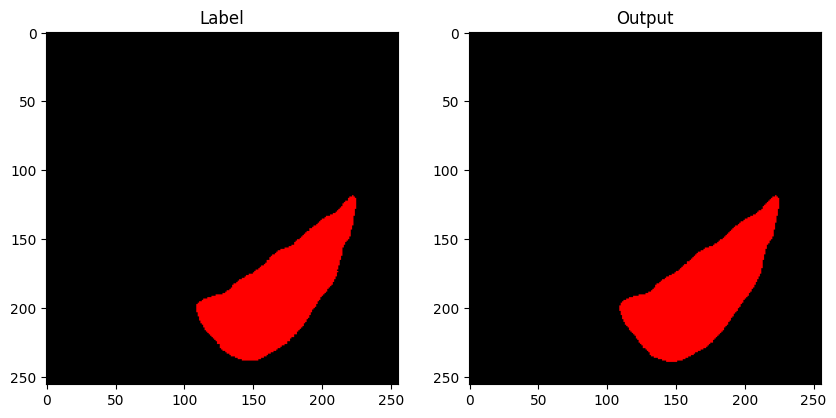

Epoch [183/200], Loss: 0.0915773238


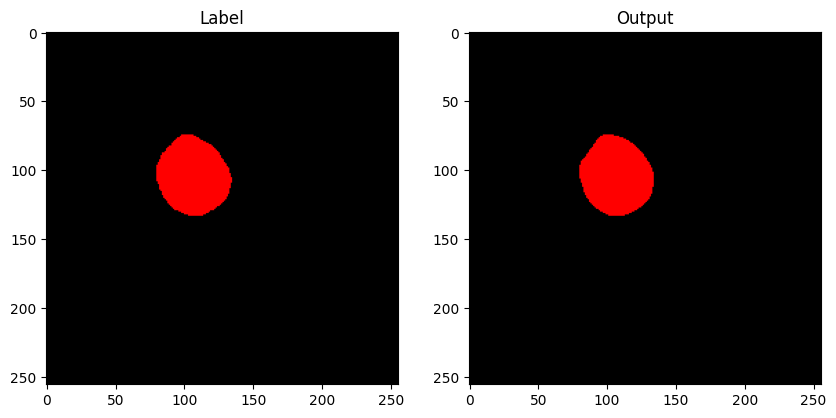

Epoch [184/200], Loss: 0.0848859782


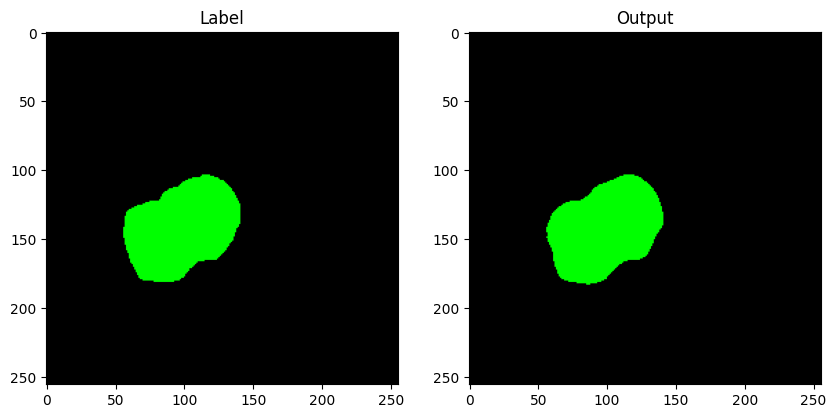

Epoch [185/200], Loss: 0.0907495170


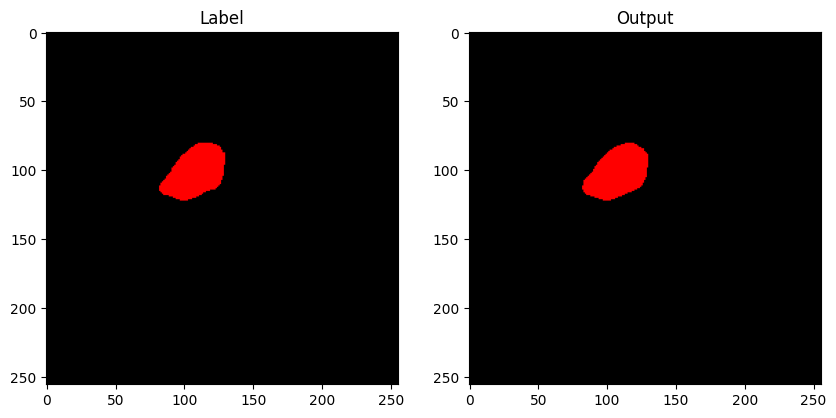

Epoch [186/200], Loss: 0.1100497932


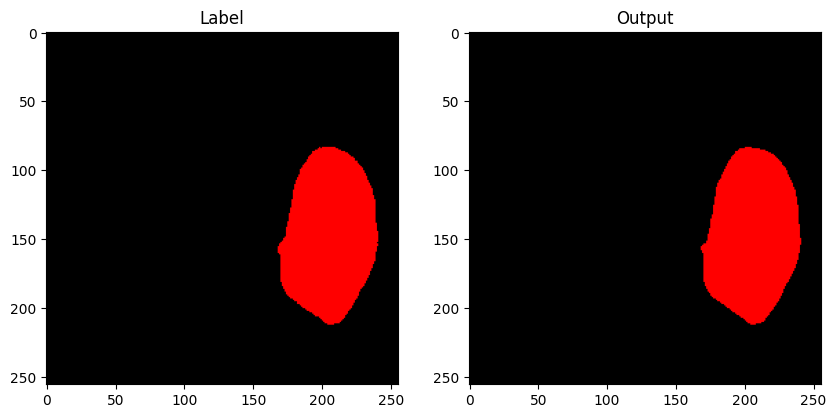

Epoch [187/200], Loss: 0.0998857844


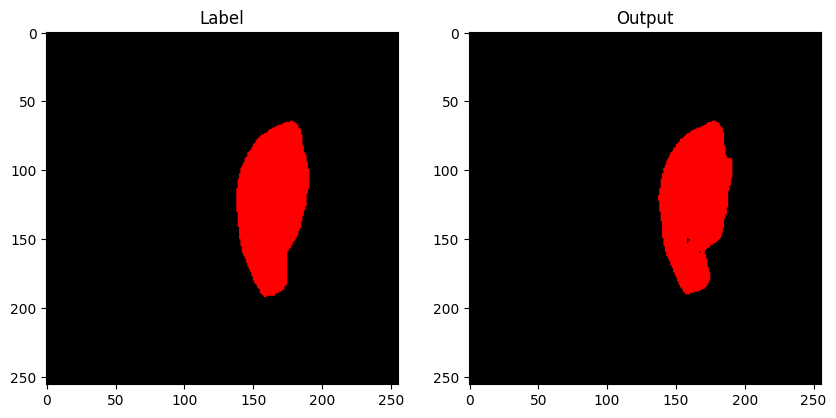

Epoch [188/200], Loss: 0.0671972569


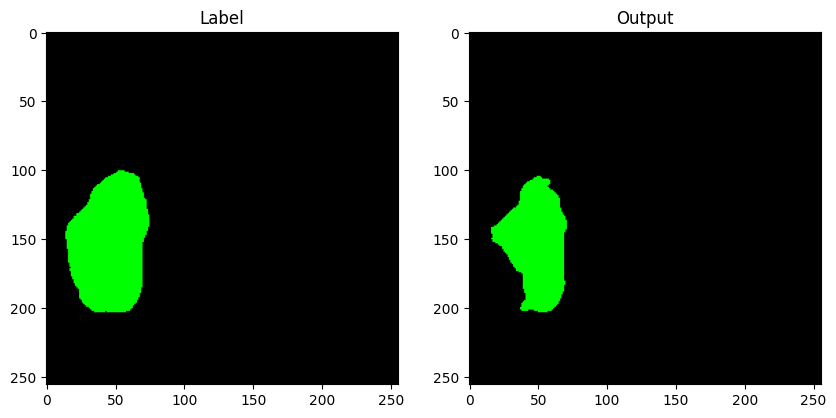

Epoch [189/200], Loss: 0.0732221229


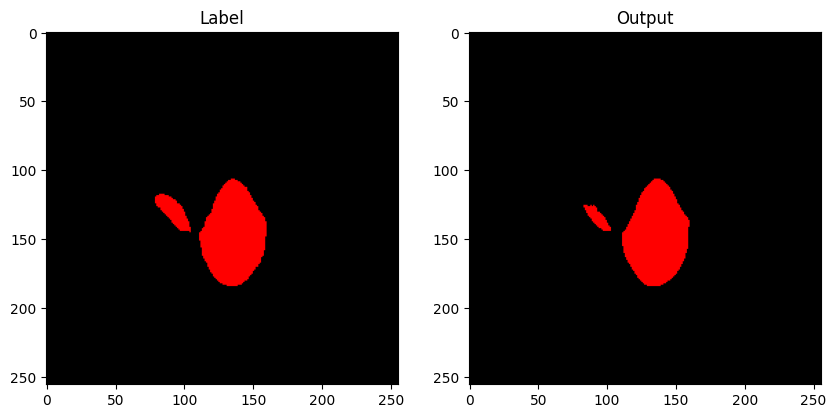

Epoch [190/200], Loss: 0.0760768110


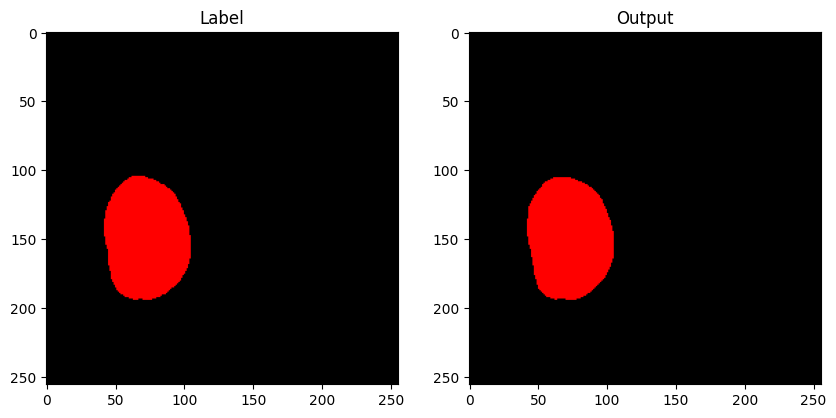

Epoch [191/200], Loss: 0.0816000744


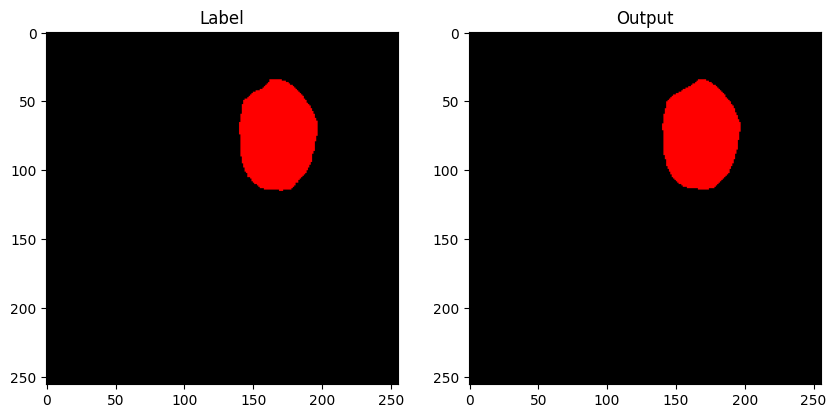

Epoch [192/200], Loss: 0.0930711436


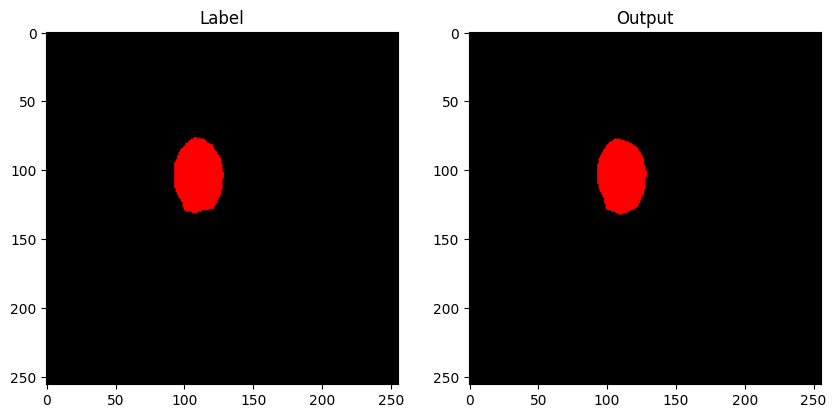

Epoch [193/200], Loss: 0.0868484792


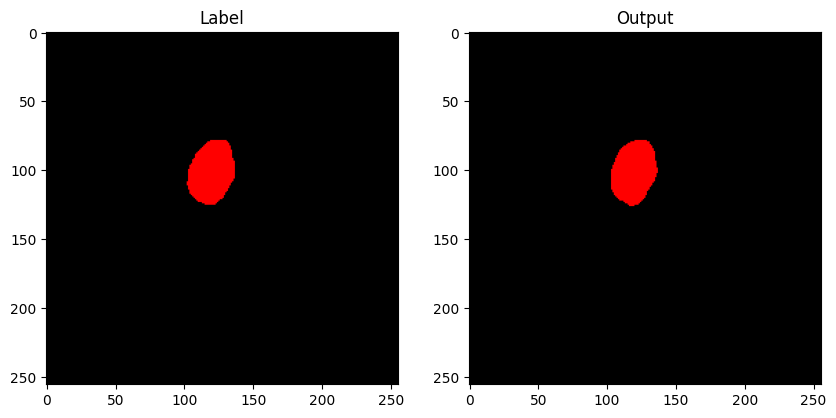

Epoch [194/200], Loss: 0.0854471456


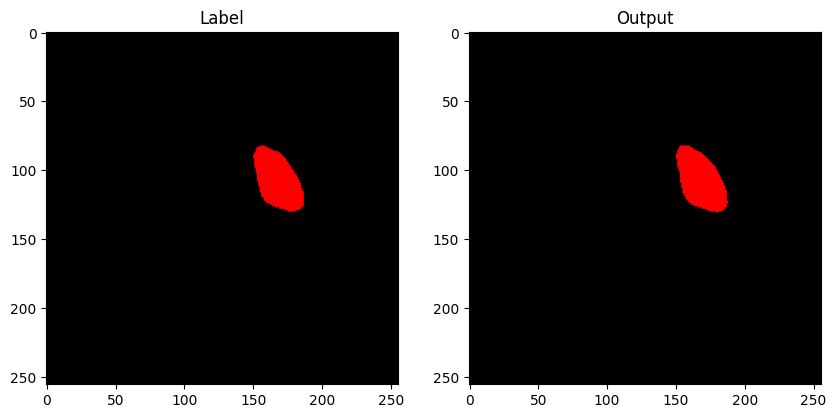

Epoch [195/200], Loss: 0.0903139646


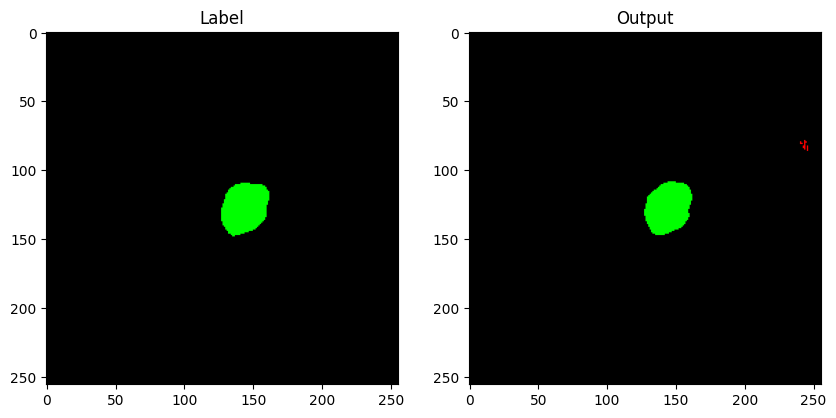

Epoch [196/200], Loss: 0.0878007635


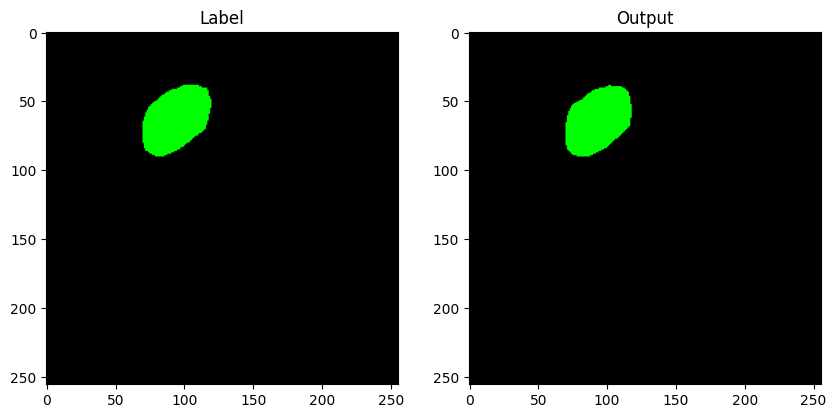

Epoch [197/200], Loss: 0.0844062266


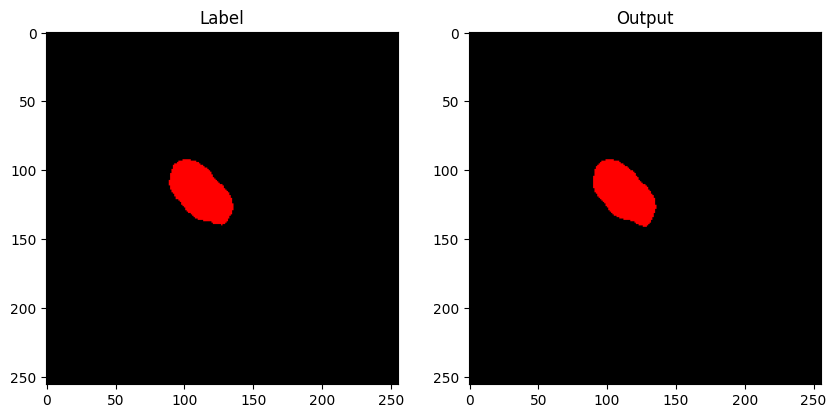

Epoch [198/200], Loss: 0.0850375149


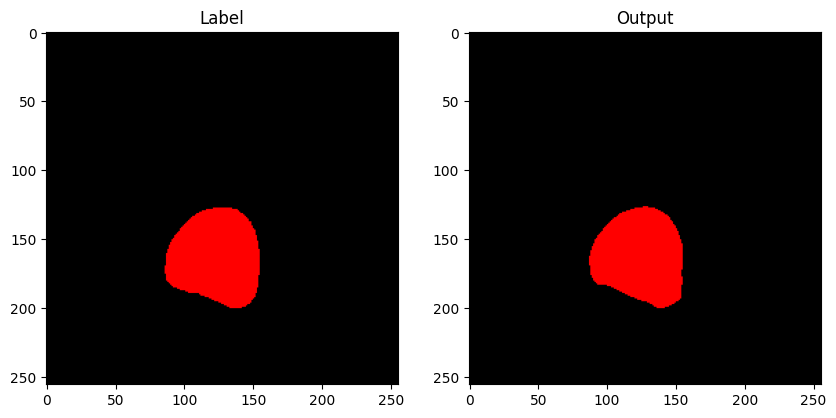

Epoch [199/200], Loss: 0.1002348654


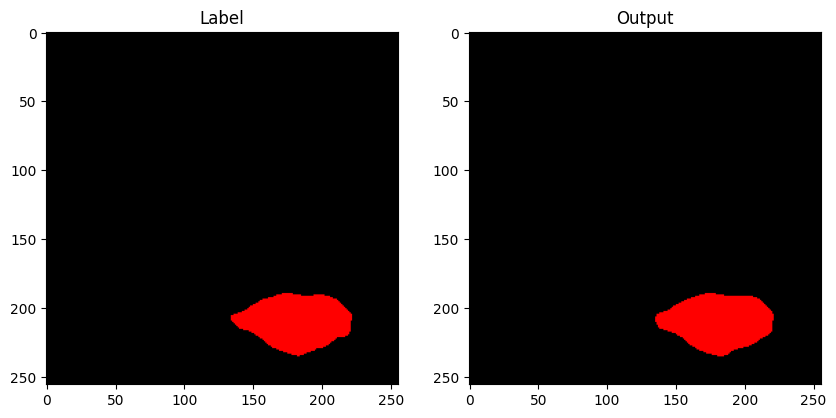

Epoch [200/200], Loss: 0.0819059937


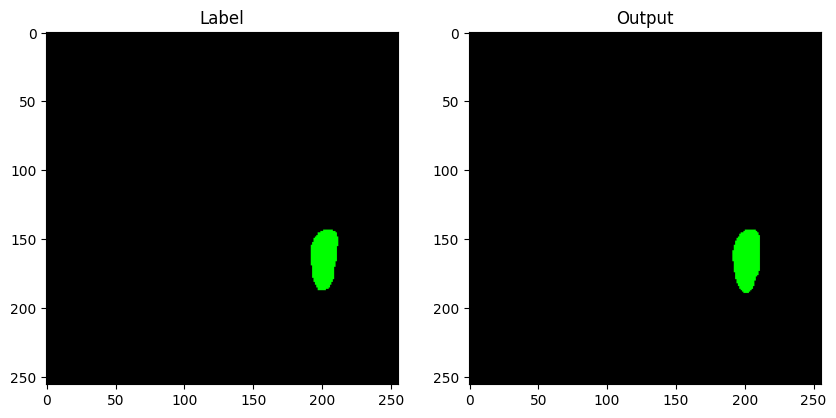

In [16]:
num_epochs = 200  # Training epochs  
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")  # Set device  
model.to(device)  # Move model to device  
criterion = nn.CrossEntropyLoss()  # Loss function  
best_val_loss = float('inf')  # Initialize best validation loss  

for epoch in range(num_epochs):  
    model.train()  # Set to training mode  
    train_loss = 0  # Reset training loss  
    for images, labels in train_loader:  
        images, labels = images.to(device), labels.to(device).squeeze(dim=1).long()  # Move to device and process  
        outputs = model(images)  # Forward pass  
        loss = criterion(outputs, labels)  # Calculate loss  
        loss.backward()  # Backward pass  
        optimizer.step()  # Update weights  
        optimizer.zero_grad()  # Clear gradients  
        train_loss += loss.item()  # Accumulate loss  

    model.eval()  # Set to evaluation mode  
    val_loss = sum(criterion(model(images.to(device)).float(), labels.to(device).squeeze(dim=1).long()).item() for images, labels in val_loader)  # Evaluate validation loss  

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {val_loss/len(val_loader):.10f}")  
    
    if val_loss < best_val_loss:  # Save model if validation loss improves  
        best_val_loss = val_loss  
        torch.save({'epoch': epoch, 'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'loss': val_loss}, 'colorization_model.pth')  

    label = mask_to_rgb(labels[0].cpu().numpy().squeeze(), color_dict)  
    output = mask_to_rgb(np.argmax(outputs[0].softmax(dim=0).detach().cpu().numpy(), axis=0), color_dict)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  
    axs[0].imshow(label); axs[0].set_title('Label')  
    axs[1].imshow(output); axs[1].set_title('Output')  
    plt.show()  # Show plots

In [17]:
checkpoint = torch.load('/kaggle/working/colorization_model.pth')  # Assign a value or initialize a variable
model.load_state_dict(checkpoint['model'])
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")  # Assign a value or initialize a variable
model.to(device)

/tmp/ipykernel_30/2875937862.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/working/colorization_model.pth')  # Assign a value or initi

UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [18]:
!mkdir prediction

In [19]:
trainsize = 256  # Image size for resizing  
model.eval()  
for filename in os.listdir("/kaggle/input/bkai-igh-neopolyp/test/test"):  
    img_path = os.path.join("/kaggle/input/bkai-igh-neopolyp/test/test", filename)  
    ori_img = cv2.imread(img_path)  # Read original image  
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)  # Convert to RGB  
    ori_h, ori_w = ori_img.shape[:2]  # Get original dimensions  
    img = cv2.resize(ori_img, (trainsize, trainsize))  # Resize for model input  
    transformed = val_transform(image=img)  # Apply transformations  
    input_img = transformed["image"].unsqueeze(0).to(device)  # Prepare input for the model  
    with torch.no_grad():  
        output_mask = model.forward(input_img).squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Get model output  
    mask = cv2.resize(output_mask, (ori_w, ori_h))  # Resize mask to original dimensions  
    mask = np.argmax(mask, axis=2)  # Get predicted classes  
    mask_rgb = mask_to_rgb(mask, color_dict)  # Convert mask to RGB format  
    mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_RGB2BGR)  # Convert back to BGR for saving  
    cv2.imwrite(f"prediction/{filename}", mask_rgb)  # Save the prediction

In [20]:
import numpy as np  # Import necessary libraries  
import pandas as pd   
import cv2  
import os  

def rle_to_string(runs):  # Convert run-length encoding to string  
    return ' '.join(str(x) for x in runs)  

def rle_encode_one_mask(mask):  # Encode a mask to run-length format  
    pixels = mask.flatten()  
    pixels[pixels > 225] = 255  
    pixels[pixels <= 225] = 0  
    use_padding = False  
    if pixels[0] or pixels[-1]:  
        use_padding = True  
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)  
        pixel_padded[1:-1] = pixels  
        pixels = pixel_padded  
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2  
    if use_padding:  
        rle = rle - 1  
    rle[1::2] = rle[1::2] - rle[:-1:2]  
    return rle_to_string(rle)  

def rle2mask(mask_rle, shape=(3, 3)):  # Decode run-length encoded string to mask  
    s = mask_rle.split()  
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]  
    starts -= 1  
    ends = starts + lengths  
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)  
    for lo, hi in zip(starts, ends):  
        img[lo:hi] = 1  
    return img.reshape(shape).T  

def mask2string(dir):  # Convert masks in directory to RLE strings  
    strings, ids, ws, hs = [], [], [], []  
    for image_id in os.listdir(dir):  
        id = image_id.split('.')[0]  
        path = os.path.join(dir, image_id)  
        img = cv2.imread(path)[:, :, ::-1]  
        h, w = img.shape[0], img.shape[1]  
        for channel in range(2):  
            ws.append(w)  
            hs.append(h)  
            ids.append(f'{id}_{channel}')  
            string = rle_encode_one_mask(img[:, :, channel])  
            strings.append(string)  
    return {'ids': ids, 'strings': strings}  

MASK_DIR_PATH = '/kaggle/working/prediction'  # Directory path for the masks  
res = mask2string(MASK_DIR_PATH)  # Process masks to get RLE strings  
df = pd.DataFrame({'Id': res['ids'], 'Expected': res['strings']})  # Create DataFrame  
df.to_csv(r'output.csv', index=False)  # Save DataFrame to CSV  
print('Done')

Done
